In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
data_table = list(data_table)
data_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [4]:
train_rows = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows:
    if 'text' in row:
        del row['text']

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [7]:
train_proc = Processor(train_rows, context)
test_proc = Processor(test_rows, context)

for row in train_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc.rows.append(value)

for row in test_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc.rows.append(value)

In [9]:
train_features = train_proc.extract_features()

KeyboardInterrupt: 

In [8]:
test_features = test_proc.extract_features()

In [9]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [ ]:
X_train, Y_train = convert_to_array(train_features)

In [ ]:
clf = CatBoostClassifier(iterations=15000, thread_count=15, random_seed=42)
params = {"iterations": [15000, 19000, 23000], "depth": [5, 6, 7]}
gs = GridSearchCV(clf, params, 'roc_auc', cv=5, refit=True, n_jobs=2)

In [ ]:
gs.fit(X_train, Y_train)
with open("log_assistant.txt", "a") as log:
    log.write("model is fitted\n")
    for key, value in gs.best_params_:
        myfile.write(str(key) + ': ' + str(value) + '\n')

In [27]:
clf = gs.estimator

In [10]:
gs = CatBoostClassifier()
gs.load_model('assistant_2019-09-26_prototype.clf')

In [11]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [12]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    if aggregated == 0:
        aggregated = 1
    accuracy = correct / aggregated
    if total_length == 0:
        total_length = 1
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost

In [13]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [14]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [15]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [128]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, max_cost=10, cluster_refernces=None, print_=True, add_threshold=0.0):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.cost != max_cost and hyp.confidence < treshhold + add_threshold) or hyp.confidence < treshhold:
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    if aggregated == 0:
        aggregated = 1
    accuracy = correct / aggregated
    if total_length == 0:
        total_length = 1
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [17]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [18]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          add_threshold=0.0):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, 
                                      aggregation_results, 
                                      treshhold, 
                                      max_cost, 
                                      cluster_refernces, 
                                      print_, 
                                      add_threshold)

In [ ]:
scores_clf_test_new_feature = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    gs, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_new_feature.append((treshhold, *metrics))
scores_clf_test_new_feature = np.array(scores_clf_test_new_feature)

0.7
Aggregated: 75.3586%
WER: 12.2137%
Accuracy: 68.0244%
Mean overlap: 3.007
0.71
Aggregated: 75.3873%
WER: 12.2298%
Accuracy: 68.0746%
Mean overlap: 3.01
0.72
Aggregated: 75.3873%
WER: 12.2429%
Accuracy: 68.1126%
Mean overlap: 3.011
0.73
Aggregated: 75.5307%
WER: 12.2668%
Accuracy: 67.9453%
Mean overlap: 3.016
0.74
Aggregated: 75.5307%
WER: 12.2743%
Accuracy: 67.9833%
Mean overlap: 3.018
0.75
Aggregated: 75.5020%
WER: 12.2443%
Accuracy: 68.0091%
Mean overlap: 3.02
0.76
Aggregated: 75.6454%
WER: 12.3375%
Accuracy: 67.9939%
Mean overlap: 3.026
0.77
Aggregated: 75.6454%
WER: 12.2995%
Accuracy: 68.0698%
Mean overlap: 3.029
0.7799999999999999
Aggregated: 75.5881%
WER: 12.2698%
Accuracy: 68.1594%
Mean overlap: 3.036
0.7899999999999999
Aggregated: 75.6741%
WER: 12.2402%
Accuracy: 68.1956%
Mean overlap: 3.042
0.7999999999999999
Aggregated: 75.7602%
WER: 12.2525%
Accuracy: 68.1181%
Mean overlap: 3.051
0.8099999999999999
Aggregated: 75.8462%
WER: 12.1545%
Accuracy: 68.2300%
Mean overlap: 3.061

In [87]:
res = aggregate_rover_with_clf_(valid_rows, 
                                test_features, 
                                'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                gs, 
                                0.94, 
                                3, 
                                7, 
                                None)

In [ ]:
clf_old = CatBoostClassifier().load_model('assistant_2019-09-23_prototype.clf')

In [ ]:
scores_clf_test_old = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_old, 
                                    treshhold, 
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_old.append((treshhold, *metrics))
scores_clf_test_old = np.array(scores_clf_test_old)

In [20]:
prod_agg_metrics = evaluate_metrics(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod) 

Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833


In [19]:
import matplotlib.pyplot as plt

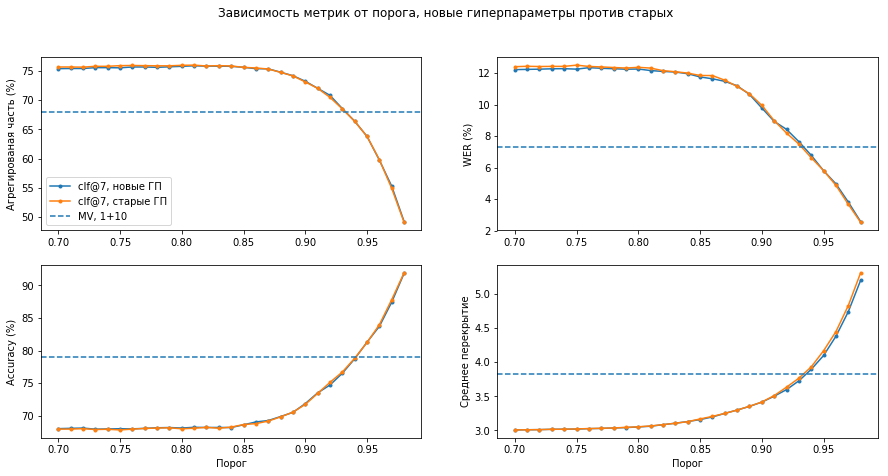

In [97]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, новые гиперпараметры против старых')
plt.subplot(221)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 1] * 100, 
         ".-", 
         label="clf@7, новые ГП")
plt.plot(scores_clf_test_old[:, 0], 
         scores_clf_test_old[:, 1] * 100, 
         ".-", 
         label="clf@7, старые ГП")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_old[:, 0], 
         scores_clf_test_old[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_old[:, 0], 
         scores_clf_test_old[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 4], 
         ".-")
plt.plot(scores_clf_test_old[:, 0], 
         scores_clf_test_old[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_new_hp_assistant.png")
plt.show()

In [108]:
train_rows_q = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [126]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [148]:
train_proc_q.rows['https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/8138894d-1014-4ed3-a09f-eb476cb0e577_029352a9-3753-4fa5-b2f7-bf4a186d36c8_265.opus']

TypeError: list indices must be integers or slices, not str

In [130]:
train_features_q = train_proc_q.extract_features()

In [145]:
len(train_features_q['https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/8138894d-1014-4ed3-a09f-eb476cb0e577_029352a9-3753-4fa5-b2f7-bf4a186d36c8_265.opus'][1][0][''][0])

254

In [39]:
len(test_features['https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus'][1][0][''][0])


248

In [131]:
test_features_q = test_proc_q.extract_features()

In [132]:
X_train_q, Y_train_q = convert_to_array(train_features_q)

In [134]:
clf_q = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("model is fitted\n")

Learning rate set to 0.006743
0:	learn: 0.6838997	total: 107ms	remaining: 33m 57s
1:	learn: 0.6750491	total: 209ms	remaining: 33m 9s
2:	learn: 0.6658977	total: 311ms	remaining: 32m 49s
3:	learn: 0.6570811	total: 409ms	remaining: 32m 21s
4:	learn: 0.6486501	total: 515ms	remaining: 32m 35s
5:	learn: 0.6402394	total: 621ms	remaining: 32m 46s
6:	learn: 0.6318617	total: 735ms	remaining: 33m 15s
7:	learn: 0.6239755	total: 843ms	remaining: 33m 21s
8:	learn: 0.6161089	total: 949ms	remaining: 33m 22s
9:	learn: 0.6082309	total: 1.05s	remaining: 33m 17s
10:	learn: 0.6006929	total: 1.15s	remaining: 33m 8s
11:	learn: 0.5930319	total: 1.25s	remaining: 33m 3s
12:	learn: 0.5857998	total: 1.41s	remaining: 34m 16s
13:	learn: 0.5788119	total: 1.56s	remaining: 35m 20s
14:	learn: 0.5717329	total: 1.75s	remaining: 36m 52s
15:	learn: 0.5649723	total: 1.88s	remaining: 37m 10s
16:	learn: 0.5581968	total: 2.02s	remaining: 37m 33s
17:	learn: 0.5516010	total: 2.22s	remaining: 39m
18:	learn: 0.5450429	total: 2.38s

156:	learn: 0.2366384	total: 17.8s	remaining: 35m 35s
157:	learn: 0.2361272	total: 17.9s	remaining: 35m 34s
158:	learn: 0.2356052	total: 18s	remaining: 35m 32s
159:	learn: 0.2351380	total: 18.1s	remaining: 35m 35s
160:	learn: 0.2346293	total: 18.3s	remaining: 35m 36s
161:	learn: 0.2341623	total: 18.4s	remaining: 35m 35s
162:	learn: 0.2336871	total: 18.5s	remaining: 35m 34s
163:	learn: 0.2332175	total: 18.6s	remaining: 35m 32s
164:	learn: 0.2327507	total: 18.7s	remaining: 35m 31s
165:	learn: 0.2322965	total: 18.8s	remaining: 35m 31s
166:	learn: 0.2318040	total: 18.9s	remaining: 35m 31s
167:	learn: 0.2313591	total: 19s	remaining: 35m 29s
168:	learn: 0.2309488	total: 19.1s	remaining: 35m 30s
169:	learn: 0.2305181	total: 19.2s	remaining: 35m 29s
170:	learn: 0.2301191	total: 19.3s	remaining: 35m 27s
171:	learn: 0.2296709	total: 19.4s	remaining: 35m 26s
172:	learn: 0.2292539	total: 19.5s	remaining: 35m 24s
173:	learn: 0.2288656	total: 19.6s	remaining: 35m 22s
174:	learn: 0.2284447	total: 19.

309:	learn: 0.2021475	total: 33.4s	remaining: 33m 34s
310:	learn: 0.2020641	total: 33.5s	remaining: 33m 34s
311:	learn: 0.2019825	total: 33.6s	remaining: 33m 33s
312:	learn: 0.2019012	total: 33.7s	remaining: 33m 32s
313:	learn: 0.2018182	total: 33.8s	remaining: 33m 32s
314:	learn: 0.2017426	total: 33.9s	remaining: 33m 31s
315:	learn: 0.2016536	total: 34s	remaining: 33m 31s
316:	learn: 0.2015562	total: 34.1s	remaining: 33m 30s
317:	learn: 0.2014794	total: 34.2s	remaining: 33m 30s
318:	learn: 0.2014185	total: 34.3s	remaining: 33m 29s
319:	learn: 0.2013482	total: 34.4s	remaining: 33m 28s
320:	learn: 0.2012852	total: 34.5s	remaining: 33m 27s
321:	learn: 0.2011807	total: 34.6s	remaining: 33m 27s
322:	learn: 0.2011186	total: 34.7s	remaining: 33m 26s
323:	learn: 0.2010227	total: 34.8s	remaining: 33m 25s
324:	learn: 0.2009151	total: 34.9s	remaining: 33m 25s
325:	learn: 0.2008419	total: 35s	remaining: 33m 25s
326:	learn: 0.2007669	total: 35.1s	remaining: 33m 25s
327:	learn: 0.2006995	total: 35.

463:	learn: 0.1937057	total: 49.5s	remaining: 32m 55s
464:	learn: 0.1936736	total: 49.6s	remaining: 32m 55s
465:	learn: 0.1936203	total: 49.7s	remaining: 32m 55s
466:	learn: 0.1935770	total: 49.8s	remaining: 32m 54s
467:	learn: 0.1935535	total: 49.9s	remaining: 32m 54s
468:	learn: 0.1935202	total: 50s	remaining: 32m 54s
469:	learn: 0.1934870	total: 50.1s	remaining: 32m 54s
470:	learn: 0.1934528	total: 50.2s	remaining: 32m 54s
471:	learn: 0.1934242	total: 50.3s	remaining: 32m 53s
472:	learn: 0.1934021	total: 50.4s	remaining: 32m 53s
473:	learn: 0.1933720	total: 50.5s	remaining: 32m 53s
474:	learn: 0.1933384	total: 50.6s	remaining: 32m 52s
475:	learn: 0.1932846	total: 50.7s	remaining: 32m 52s
476:	learn: 0.1932566	total: 50.8s	remaining: 32m 52s
477:	learn: 0.1932145	total: 50.9s	remaining: 32m 51s
478:	learn: 0.1931794	total: 51s	remaining: 32m 51s
479:	learn: 0.1931425	total: 51.1s	remaining: 32m 51s
480:	learn: 0.1931034	total: 51.2s	remaining: 32m 51s
481:	learn: 0.1930794	total: 51.

617:	learn: 0.1896855	total: 1m 5s	remaining: 32m 30s
618:	learn: 0.1896730	total: 1m 5s	remaining: 32m 29s
619:	learn: 0.1896550	total: 1m 5s	remaining: 32m 29s
620:	learn: 0.1896377	total: 1m 5s	remaining: 32m 29s
621:	learn: 0.1896131	total: 1m 5s	remaining: 32m 28s
622:	learn: 0.1895996	total: 1m 6s	remaining: 32m 28s
623:	learn: 0.1895861	total: 1m 6s	remaining: 32m 28s
624:	learn: 0.1895647	total: 1m 6s	remaining: 32m 27s
625:	learn: 0.1895335	total: 1m 6s	remaining: 32m 27s
626:	learn: 0.1895130	total: 1m 6s	remaining: 32m 27s
627:	learn: 0.1894999	total: 1m 6s	remaining: 32m 26s
628:	learn: 0.1894786	total: 1m 6s	remaining: 32m 26s
629:	learn: 0.1894543	total: 1m 6s	remaining: 32m 26s
630:	learn: 0.1894378	total: 1m 6s	remaining: 32m 27s
631:	learn: 0.1894176	total: 1m 7s	remaining: 32m 27s
632:	learn: 0.1894001	total: 1m 7s	remaining: 32m 27s
633:	learn: 0.1893739	total: 1m 7s	remaining: 32m 28s
634:	learn: 0.1893519	total: 1m 7s	remaining: 32m 28s
635:	learn: 0.1893287	total:

768:	learn: 0.1871897	total: 1m 20s	remaining: 31m 51s
769:	learn: 0.1871795	total: 1m 20s	remaining: 31m 50s
770:	learn: 0.1871546	total: 1m 20s	remaining: 31m 50s
771:	learn: 0.1871372	total: 1m 20s	remaining: 31m 50s
772:	learn: 0.1871287	total: 1m 21s	remaining: 31m 50s
773:	learn: 0.1871161	total: 1m 21s	remaining: 31m 49s
774:	learn: 0.1870985	total: 1m 21s	remaining: 31m 49s
775:	learn: 0.1870895	total: 1m 21s	remaining: 31m 48s
776:	learn: 0.1870697	total: 1m 21s	remaining: 31m 48s
777:	learn: 0.1870552	total: 1m 21s	remaining: 31m 48s
778:	learn: 0.1870421	total: 1m 21s	remaining: 31m 47s
779:	learn: 0.1870313	total: 1m 21s	remaining: 31m 47s
780:	learn: 0.1870203	total: 1m 21s	remaining: 31m 47s
781:	learn: 0.1870065	total: 1m 21s	remaining: 31m 46s
782:	learn: 0.1869898	total: 1m 21s	remaining: 31m 46s
783:	learn: 0.1869783	total: 1m 22s	remaining: 31m 46s
784:	learn: 0.1869613	total: 1m 22s	remaining: 31m 45s
785:	learn: 0.1869436	total: 1m 22s	remaining: 31m 45s
786:	learn

919:	learn: 0.1853950	total: 1m 34s	remaining: 31m 4s
920:	learn: 0.1853749	total: 1m 34s	remaining: 31m 4s
921:	learn: 0.1853695	total: 1m 35s	remaining: 31m 3s
922:	learn: 0.1853606	total: 1m 35s	remaining: 31m 3s
923:	learn: 0.1853524	total: 1m 35s	remaining: 31m 3s
924:	learn: 0.1853364	total: 1m 35s	remaining: 31m 3s
925:	learn: 0.1853196	total: 1m 35s	remaining: 31m 3s
926:	learn: 0.1853050	total: 1m 35s	remaining: 31m 3s
927:	learn: 0.1852955	total: 1m 35s	remaining: 31m 2s
928:	learn: 0.1852877	total: 1m 35s	remaining: 31m 2s
929:	learn: 0.1852771	total: 1m 35s	remaining: 31m 2s
930:	learn: 0.1852627	total: 1m 35s	remaining: 31m 2s
931:	learn: 0.1852527	total: 1m 36s	remaining: 31m 2s
932:	learn: 0.1852477	total: 1m 36s	remaining: 31m 1s
933:	learn: 0.1852360	total: 1m 36s	remaining: 31m 1s
934:	learn: 0.1852271	total: 1m 36s	remaining: 31m 1s
935:	learn: 0.1852141	total: 1m 36s	remaining: 31m 1s
936:	learn: 0.1852065	total: 1m 36s	remaining: 31m
937:	learn: 0.1851985	total: 1m

1069:	learn: 0.1839317	total: 1m 49s	remaining: 30m 31s
1070:	learn: 0.1839183	total: 1m 49s	remaining: 30m 31s
1071:	learn: 0.1839137	total: 1m 49s	remaining: 30m 31s
1072:	learn: 0.1839053	total: 1m 49s	remaining: 30m 31s
1073:	learn: 0.1838976	total: 1m 49s	remaining: 30m 31s
1074:	learn: 0.1838831	total: 1m 49s	remaining: 30m 31s
1075:	learn: 0.1838793	total: 1m 49s	remaining: 30m 30s
1076:	learn: 0.1838699	total: 1m 50s	remaining: 30m 30s
1077:	learn: 0.1838645	total: 1m 50s	remaining: 30m 30s
1078:	learn: 0.1838504	total: 1m 50s	remaining: 30m 30s
1079:	learn: 0.1838451	total: 1m 50s	remaining: 30m 30s
1080:	learn: 0.1838406	total: 1m 50s	remaining: 30m 29s
1081:	learn: 0.1838326	total: 1m 50s	remaining: 30m 29s
1082:	learn: 0.1838277	total: 1m 50s	remaining: 30m 29s
1083:	learn: 0.1838222	total: 1m 50s	remaining: 30m 29s
1084:	learn: 0.1838132	total: 1m 50s	remaining: 30m 29s
1085:	learn: 0.1838004	total: 1m 50s	remaining: 30m 29s
1086:	learn: 0.1837975	total: 1m 50s	remaining: 

1217:	learn: 0.1827343	total: 2m 3s	remaining: 30m 6s
1218:	learn: 0.1827226	total: 2m 3s	remaining: 30m 6s
1219:	learn: 0.1827118	total: 2m 3s	remaining: 30m 5s
1220:	learn: 0.1827084	total: 2m 3s	remaining: 30m 5s
1221:	learn: 0.1826938	total: 2m 4s	remaining: 30m 5s
1222:	learn: 0.1826868	total: 2m 4s	remaining: 30m 5s
1223:	learn: 0.1826788	total: 2m 4s	remaining: 30m 4s
1224:	learn: 0.1826726	total: 2m 4s	remaining: 30m 4s
1225:	learn: 0.1826647	total: 2m 4s	remaining: 30m 4s
1226:	learn: 0.1826584	total: 2m 4s	remaining: 30m 4s
1227:	learn: 0.1826530	total: 2m 4s	remaining: 30m 3s
1228:	learn: 0.1826439	total: 2m 4s	remaining: 30m 3s
1229:	learn: 0.1826367	total: 2m 4s	remaining: 30m 3s
1230:	learn: 0.1826317	total: 2m 4s	remaining: 30m 3s
1231:	learn: 0.1826179	total: 2m 5s	remaining: 30m 3s
1232:	learn: 0.1826079	total: 2m 5s	remaining: 30m 2s
1233:	learn: 0.1826010	total: 2m 5s	remaining: 30m 2s
1234:	learn: 0.1825945	total: 2m 5s	remaining: 30m 2s
1235:	learn: 0.1825882	total

1368:	learn: 0.1815655	total: 2m 18s	remaining: 29m 39s
1369:	learn: 0.1815581	total: 2m 18s	remaining: 29m 39s
1370:	learn: 0.1815431	total: 2m 18s	remaining: 29m 39s
1371:	learn: 0.1815388	total: 2m 18s	remaining: 29m 39s
1372:	learn: 0.1815330	total: 2m 18s	remaining: 29m 39s
1373:	learn: 0.1815248	total: 2m 18s	remaining: 29m 39s
1374:	learn: 0.1815186	total: 2m 18s	remaining: 29m 38s
1375:	learn: 0.1815064	total: 2m 18s	remaining: 29m 38s
1376:	learn: 0.1814962	total: 2m 18s	remaining: 29m 38s
1377:	learn: 0.1814893	total: 2m 19s	remaining: 29m 38s
1378:	learn: 0.1814854	total: 2m 19s	remaining: 29m 38s
1379:	learn: 0.1814764	total: 2m 19s	remaining: 29m 38s
1380:	learn: 0.1814689	total: 2m 19s	remaining: 29m 37s
1381:	learn: 0.1814624	total: 2m 19s	remaining: 29m 37s
1382:	learn: 0.1814583	total: 2m 19s	remaining: 29m 37s
1383:	learn: 0.1814558	total: 2m 19s	remaining: 29m 37s
1384:	learn: 0.1814516	total: 2m 19s	remaining: 29m 37s
1385:	learn: 0.1814471	total: 2m 19s	remaining: 

1515:	learn: 0.1805981	total: 2m 32s	remaining: 29m 15s
1516:	learn: 0.1805905	total: 2m 32s	remaining: 29m 14s
1517:	learn: 0.1805859	total: 2m 32s	remaining: 29m 14s
1518:	learn: 0.1805797	total: 2m 32s	remaining: 29m 14s
1519:	learn: 0.1805711	total: 2m 32s	remaining: 29m 14s
1520:	learn: 0.1805633	total: 2m 32s	remaining: 29m 14s
1521:	learn: 0.1805601	total: 2m 32s	remaining: 29m 14s
1522:	learn: 0.1805549	total: 2m 32s	remaining: 29m 13s
1523:	learn: 0.1805520	total: 2m 32s	remaining: 29m 13s
1524:	learn: 0.1805448	total: 2m 33s	remaining: 29m 13s
1525:	learn: 0.1805383	total: 2m 33s	remaining: 29m 13s
1526:	learn: 0.1805354	total: 2m 33s	remaining: 29m 13s
1527:	learn: 0.1805314	total: 2m 33s	remaining: 29m 12s
1528:	learn: 0.1805201	total: 2m 33s	remaining: 29m 12s
1529:	learn: 0.1805180	total: 2m 33s	remaining: 29m 12s
1530:	learn: 0.1805132	total: 2m 33s	remaining: 29m 12s
1531:	learn: 0.1805093	total: 2m 33s	remaining: 29m 12s
1532:	learn: 0.1805034	total: 2m 33s	remaining: 

1663:	learn: 0.1796699	total: 2m 46s	remaining: 28m 52s
1664:	learn: 0.1796657	total: 2m 46s	remaining: 28m 51s
1665:	learn: 0.1796599	total: 2m 46s	remaining: 28m 51s
1666:	learn: 0.1796554	total: 2m 46s	remaining: 28m 51s
1667:	learn: 0.1796515	total: 2m 46s	remaining: 28m 51s
1668:	learn: 0.1796475	total: 2m 46s	remaining: 28m 51s
1669:	learn: 0.1796445	total: 2m 46s	remaining: 28m 50s
1670:	learn: 0.1796421	total: 2m 46s	remaining: 28m 50s
1671:	learn: 0.1796392	total: 2m 46s	remaining: 28m 50s
1672:	learn: 0.1796299	total: 2m 47s	remaining: 28m 50s
1673:	learn: 0.1796254	total: 2m 47s	remaining: 28m 50s
1674:	learn: 0.1796134	total: 2m 47s	remaining: 28m 50s
1675:	learn: 0.1796089	total: 2m 47s	remaining: 28m 49s
1676:	learn: 0.1796049	total: 2m 47s	remaining: 28m 49s
1677:	learn: 0.1795991	total: 2m 47s	remaining: 28m 49s
1678:	learn: 0.1795892	total: 2m 47s	remaining: 28m 49s
1679:	learn: 0.1795835	total: 2m 47s	remaining: 28m 49s
1680:	learn: 0.1795774	total: 2m 47s	remaining: 

1812:	learn: 0.1788323	total: 3m	remaining: 28m 32s
1813:	learn: 0.1788247	total: 3m	remaining: 28m 32s
1814:	learn: 0.1788180	total: 3m	remaining: 28m 32s
1815:	learn: 0.1788133	total: 3m	remaining: 28m 31s
1816:	learn: 0.1788084	total: 3m	remaining: 28m 31s
1817:	learn: 0.1788024	total: 3m 1s	remaining: 28m 31s
1818:	learn: 0.1787970	total: 3m 1s	remaining: 28m 31s
1819:	learn: 0.1787915	total: 3m 1s	remaining: 28m 31s
1820:	learn: 0.1787851	total: 3m 1s	remaining: 28m 30s
1821:	learn: 0.1787799	total: 3m 1s	remaining: 28m 30s
1822:	learn: 0.1787737	total: 3m 1s	remaining: 28m 30s
1823:	learn: 0.1787690	total: 3m 1s	remaining: 28m 30s
1824:	learn: 0.1787614	total: 3m 1s	remaining: 28m 30s
1825:	learn: 0.1787578	total: 3m 1s	remaining: 28m 30s
1826:	learn: 0.1787533	total: 3m 1s	remaining: 28m 29s
1827:	learn: 0.1787489	total: 3m 2s	remaining: 28m 29s
1828:	learn: 0.1787450	total: 3m 2s	remaining: 28m 29s
1829:	learn: 0.1787432	total: 3m 2s	remaining: 28m 29s
1830:	learn: 0.1787388	to

1961:	learn: 0.1779313	total: 3m 14s	remaining: 28m 10s
1962:	learn: 0.1779261	total: 3m 14s	remaining: 28m 10s
1963:	learn: 0.1779192	total: 3m 14s	remaining: 28m 9s
1964:	learn: 0.1779151	total: 3m 14s	remaining: 28m 9s
1965:	learn: 0.1779078	total: 3m 14s	remaining: 28m 9s
1966:	learn: 0.1779037	total: 3m 15s	remaining: 28m 9s
1967:	learn: 0.1778968	total: 3m 15s	remaining: 28m 9s
1968:	learn: 0.1778905	total: 3m 15s	remaining: 28m 8s
1969:	learn: 0.1778868	total: 3m 15s	remaining: 28m 8s
1970:	learn: 0.1778756	total: 3m 15s	remaining: 28m 8s
1971:	learn: 0.1778728	total: 3m 15s	remaining: 28m 8s
1972:	learn: 0.1778705	total: 3m 15s	remaining: 28m 8s
1973:	learn: 0.1778682	total: 3m 15s	remaining: 28m 8s
1974:	learn: 0.1778555	total: 3m 15s	remaining: 28m 7s
1975:	learn: 0.1778499	total: 3m 15s	remaining: 28m 7s
1976:	learn: 0.1778412	total: 3m 16s	remaining: 28m 7s
1977:	learn: 0.1778389	total: 3m 16s	remaining: 28m 7s
1978:	learn: 0.1778364	total: 3m 16s	remaining: 28m 7s
1979:	le

2111:	learn: 0.1770612	total: 3m 28s	remaining: 27m 48s
2112:	learn: 0.1770575	total: 3m 28s	remaining: 27m 48s
2113:	learn: 0.1770530	total: 3m 28s	remaining: 27m 48s
2114:	learn: 0.1770480	total: 3m 28s	remaining: 27m 47s
2115:	learn: 0.1770417	total: 3m 29s	remaining: 27m 47s
2116:	learn: 0.1770352	total: 3m 29s	remaining: 27m 47s
2117:	learn: 0.1770314	total: 3m 29s	remaining: 27m 47s
2118:	learn: 0.1770259	total: 3m 29s	remaining: 27m 47s
2119:	learn: 0.1770207	total: 3m 29s	remaining: 27m 47s
2120:	learn: 0.1770169	total: 3m 29s	remaining: 27m 47s
2121:	learn: 0.1770097	total: 3m 29s	remaining: 27m 47s
2122:	learn: 0.1770022	total: 3m 29s	remaining: 27m 46s
2123:	learn: 0.1769979	total: 3m 29s	remaining: 27m 46s
2124:	learn: 0.1769889	total: 3m 29s	remaining: 27m 46s
2125:	learn: 0.1769803	total: 3m 29s	remaining: 27m 46s
2126:	learn: 0.1769767	total: 3m 30s	remaining: 27m 46s
2127:	learn: 0.1769736	total: 3m 30s	remaining: 27m 46s
2128:	learn: 0.1769671	total: 3m 30s	remaining: 

2258:	learn: 0.1762395	total: 3m 42s	remaining: 27m 29s
2259:	learn: 0.1762303	total: 3m 42s	remaining: 27m 29s
2260:	learn: 0.1762258	total: 3m 42s	remaining: 27m 29s
2261:	learn: 0.1762208	total: 3m 42s	remaining: 27m 29s
2262:	learn: 0.1762174	total: 3m 43s	remaining: 27m 29s
2263:	learn: 0.1762114	total: 3m 43s	remaining: 27m 29s
2264:	learn: 0.1762057	total: 3m 43s	remaining: 27m 29s
2265:	learn: 0.1762025	total: 3m 43s	remaining: 27m 28s
2266:	learn: 0.1761967	total: 3m 43s	remaining: 27m 28s
2267:	learn: 0.1761940	total: 3m 43s	remaining: 27m 28s
2268:	learn: 0.1761885	total: 3m 43s	remaining: 27m 28s
2269:	learn: 0.1761820	total: 3m 43s	remaining: 27m 28s
2270:	learn: 0.1761792	total: 3m 43s	remaining: 27m 28s
2271:	learn: 0.1761723	total: 3m 43s	remaining: 27m 28s
2272:	learn: 0.1761690	total: 3m 43s	remaining: 27m 28s
2273:	learn: 0.1761649	total: 3m 44s	remaining: 27m 28s
2274:	learn: 0.1761553	total: 3m 44s	remaining: 27m 28s
2275:	learn: 0.1761511	total: 3m 44s	remaining: 

2405:	learn: 0.1754407	total: 3m 56s	remaining: 27m 12s
2406:	learn: 0.1754366	total: 3m 56s	remaining: 27m 12s
2407:	learn: 0.1754291	total: 3m 56s	remaining: 27m 12s
2408:	learn: 0.1754266	total: 3m 56s	remaining: 27m 12s
2409:	learn: 0.1754223	total: 3m 57s	remaining: 27m 12s
2410:	learn: 0.1754155	total: 3m 57s	remaining: 27m 11s
2411:	learn: 0.1754097	total: 3m 57s	remaining: 27m 11s
2412:	learn: 0.1754032	total: 3m 57s	remaining: 27m 11s
2413:	learn: 0.1753984	total: 3m 57s	remaining: 27m 11s
2414:	learn: 0.1753925	total: 3m 57s	remaining: 27m 11s
2415:	learn: 0.1753865	total: 3m 57s	remaining: 27m 11s
2416:	learn: 0.1753776	total: 3m 57s	remaining: 27m 11s
2417:	learn: 0.1753722	total: 3m 57s	remaining: 27m 11s
2418:	learn: 0.1753700	total: 3m 57s	remaining: 27m 10s
2419:	learn: 0.1753613	total: 3m 58s	remaining: 27m 10s
2420:	learn: 0.1753553	total: 3m 58s	remaining: 27m 10s
2421:	learn: 0.1753483	total: 3m 58s	remaining: 27m 10s
2422:	learn: 0.1753456	total: 3m 58s	remaining: 

2557:	learn: 0.1746581	total: 4m 10s	remaining: 26m 52s
2558:	learn: 0.1746542	total: 4m 11s	remaining: 26m 52s
2559:	learn: 0.1746504	total: 4m 11s	remaining: 26m 52s
2560:	learn: 0.1746470	total: 4m 11s	remaining: 26m 52s
2561:	learn: 0.1746388	total: 4m 11s	remaining: 26m 52s
2562:	learn: 0.1746337	total: 4m 11s	remaining: 26m 52s
2563:	learn: 0.1746295	total: 4m 11s	remaining: 26m 52s
2564:	learn: 0.1746253	total: 4m 11s	remaining: 26m 52s
2565:	learn: 0.1746170	total: 4m 11s	remaining: 26m 51s
2566:	learn: 0.1746124	total: 4m 11s	remaining: 26m 51s
2567:	learn: 0.1746072	total: 4m 11s	remaining: 26m 51s
2568:	learn: 0.1746010	total: 4m 11s	remaining: 26m 51s
2569:	learn: 0.1745968	total: 4m 12s	remaining: 26m 51s
2570:	learn: 0.1745885	total: 4m 12s	remaining: 26m 51s
2571:	learn: 0.1745815	total: 4m 12s	remaining: 26m 51s
2572:	learn: 0.1745770	total: 4m 12s	remaining: 26m 50s
2573:	learn: 0.1745712	total: 4m 12s	remaining: 26m 50s
2574:	learn: 0.1745677	total: 4m 12s	remaining: 

2704:	learn: 0.1739256	total: 4m 24s	remaining: 26m 34s
2705:	learn: 0.1739197	total: 4m 24s	remaining: 26m 34s
2706:	learn: 0.1739152	total: 4m 24s	remaining: 26m 33s
2707:	learn: 0.1739128	total: 4m 24s	remaining: 26m 33s
2708:	learn: 0.1739061	total: 4m 25s	remaining: 26m 33s
2709:	learn: 0.1739017	total: 4m 25s	remaining: 26m 33s
2710:	learn: 0.1738982	total: 4m 25s	remaining: 26m 33s
2711:	learn: 0.1738918	total: 4m 25s	remaining: 26m 33s
2712:	learn: 0.1738862	total: 4m 25s	remaining: 26m 33s
2713:	learn: 0.1738843	total: 4m 25s	remaining: 26m 33s
2714:	learn: 0.1738787	total: 4m 25s	remaining: 26m 32s
2715:	learn: 0.1738739	total: 4m 25s	remaining: 26m 32s
2716:	learn: 0.1738697	total: 4m 25s	remaining: 26m 32s
2717:	learn: 0.1738670	total: 4m 25s	remaining: 26m 32s
2718:	learn: 0.1738616	total: 4m 25s	remaining: 26m 32s
2719:	learn: 0.1738588	total: 4m 26s	remaining: 26m 32s
2720:	learn: 0.1738523	total: 4m 26s	remaining: 26m 32s
2721:	learn: 0.1738453	total: 4m 26s	remaining: 

2852:	learn: 0.1732212	total: 4m 38s	remaining: 26m 17s
2853:	learn: 0.1732170	total: 4m 38s	remaining: 26m 17s
2854:	learn: 0.1732142	total: 4m 38s	remaining: 26m 16s
2855:	learn: 0.1732111	total: 4m 38s	remaining: 26m 16s
2856:	learn: 0.1732047	total: 4m 39s	remaining: 26m 16s
2857:	learn: 0.1731979	total: 4m 39s	remaining: 26m 16s
2858:	learn: 0.1731919	total: 4m 39s	remaining: 26m 16s
2859:	learn: 0.1731907	total: 4m 39s	remaining: 26m 16s
2860:	learn: 0.1731851	total: 4m 39s	remaining: 26m 16s
2861:	learn: 0.1731741	total: 4m 39s	remaining: 26m 16s
2862:	learn: 0.1731667	total: 4m 39s	remaining: 26m 15s
2863:	learn: 0.1731624	total: 4m 39s	remaining: 26m 15s
2864:	learn: 0.1731567	total: 4m 39s	remaining: 26m 15s
2865:	learn: 0.1731509	total: 4m 39s	remaining: 26m 15s
2866:	learn: 0.1731466	total: 4m 39s	remaining: 26m 15s
2867:	learn: 0.1731434	total: 4m 40s	remaining: 26m 15s
2868:	learn: 0.1731406	total: 4m 40s	remaining: 26m 15s
2869:	learn: 0.1731376	total: 4m 40s	remaining: 

3003:	learn: 0.1725171	total: 4m 52s	remaining: 25m 59s
3004:	learn: 0.1725103	total: 4m 52s	remaining: 25m 59s
3005:	learn: 0.1725072	total: 4m 53s	remaining: 25m 59s
3006:	learn: 0.1725021	total: 4m 53s	remaining: 25m 58s
3007:	learn: 0.1724943	total: 4m 53s	remaining: 25m 58s
3008:	learn: 0.1724886	total: 4m 53s	remaining: 25m 58s
3009:	learn: 0.1724853	total: 4m 53s	remaining: 25m 58s
3010:	learn: 0.1724819	total: 4m 53s	remaining: 25m 58s
3011:	learn: 0.1724793	total: 4m 53s	remaining: 25m 58s
3012:	learn: 0.1724752	total: 4m 53s	remaining: 25m 58s
3013:	learn: 0.1724729	total: 4m 53s	remaining: 25m 58s
3014:	learn: 0.1724703	total: 4m 53s	remaining: 25m 58s
3015:	learn: 0.1724653	total: 4m 53s	remaining: 25m 57s
3016:	learn: 0.1724590	total: 4m 54s	remaining: 25m 57s
3017:	learn: 0.1724531	total: 4m 54s	remaining: 25m 57s
3018:	learn: 0.1724487	total: 4m 54s	remaining: 25m 57s
3019:	learn: 0.1724436	total: 4m 54s	remaining: 25m 57s
3020:	learn: 0.1724333	total: 4m 54s	remaining: 

3154:	learn: 0.1718467	total: 5m 7s	remaining: 25m 44s
3155:	learn: 0.1718439	total: 5m 7s	remaining: 25m 44s
3156:	learn: 0.1718392	total: 5m 7s	remaining: 25m 44s
3157:	learn: 0.1718329	total: 5m 7s	remaining: 25m 44s
3158:	learn: 0.1718278	total: 5m 7s	remaining: 25m 44s
3159:	learn: 0.1718249	total: 5m 8s	remaining: 25m 44s
3160:	learn: 0.1718210	total: 5m 8s	remaining: 25m 44s
3161:	learn: 0.1718185	total: 5m 8s	remaining: 25m 44s
3162:	learn: 0.1718144	total: 5m 8s	remaining: 25m 43s
3163:	learn: 0.1718106	total: 5m 8s	remaining: 25m 43s
3164:	learn: 0.1718041	total: 5m 8s	remaining: 25m 43s
3165:	learn: 0.1717960	total: 5m 8s	remaining: 25m 43s
3166:	learn: 0.1717895	total: 5m 8s	remaining: 25m 43s
3167:	learn: 0.1717861	total: 5m 8s	remaining: 25m 43s
3168:	learn: 0.1717811	total: 5m 8s	remaining: 25m 43s
3169:	learn: 0.1717767	total: 5m 9s	remaining: 25m 43s
3170:	learn: 0.1717737	total: 5m 9s	remaining: 25m 42s
3171:	learn: 0.1717697	total: 5m 9s	remaining: 25m 42s
3172:	lear

3302:	learn: 0.1711945	total: 5m 21s	remaining: 25m 27s
3303:	learn: 0.1711909	total: 5m 21s	remaining: 25m 27s
3304:	learn: 0.1711876	total: 5m 21s	remaining: 25m 26s
3305:	learn: 0.1711840	total: 5m 21s	remaining: 25m 26s
3306:	learn: 0.1711808	total: 5m 21s	remaining: 25m 26s
3307:	learn: 0.1711767	total: 5m 21s	remaining: 25m 26s
3308:	learn: 0.1711726	total: 5m 21s	remaining: 25m 26s
3309:	learn: 0.1711691	total: 5m 21s	remaining: 25m 26s
3310:	learn: 0.1711651	total: 5m 22s	remaining: 25m 26s
3311:	learn: 0.1711636	total: 5m 22s	remaining: 25m 25s
3312:	learn: 0.1711600	total: 5m 22s	remaining: 25m 25s
3313:	learn: 0.1711552	total: 5m 22s	remaining: 25m 25s
3314:	learn: 0.1711491	total: 5m 22s	remaining: 25m 25s
3315:	learn: 0.1711457	total: 5m 22s	remaining: 25m 25s
3316:	learn: 0.1711432	total: 5m 22s	remaining: 25m 25s
3317:	learn: 0.1711364	total: 5m 22s	remaining: 25m 25s
3318:	learn: 0.1711320	total: 5m 22s	remaining: 25m 25s
3319:	learn: 0.1711283	total: 5m 22s	remaining: 

3450:	learn: 0.1705792	total: 5m 35s	remaining: 25m 11s
3451:	learn: 0.1705729	total: 5m 35s	remaining: 25m 10s
3452:	learn: 0.1705648	total: 5m 35s	remaining: 25m 10s
3453:	learn: 0.1705634	total: 5m 35s	remaining: 25m 10s
3454:	learn: 0.1705596	total: 5m 35s	remaining: 25m 10s
3455:	learn: 0.1705571	total: 5m 35s	remaining: 25m 10s
3456:	learn: 0.1705550	total: 5m 35s	remaining: 25m 10s
3457:	learn: 0.1705525	total: 5m 36s	remaining: 25m 10s
3458:	learn: 0.1705488	total: 5m 36s	remaining: 25m 10s
3459:	learn: 0.1705455	total: 5m 36s	remaining: 25m 10s
3460:	learn: 0.1705380	total: 5m 36s	remaining: 25m 9s
3461:	learn: 0.1705344	total: 5m 36s	remaining: 25m 9s
3462:	learn: 0.1705322	total: 5m 36s	remaining: 25m 9s
3463:	learn: 0.1705280	total: 5m 36s	remaining: 25m 9s
3464:	learn: 0.1705248	total: 5m 36s	remaining: 25m 9s
3465:	learn: 0.1705189	total: 5m 36s	remaining: 25m 9s
3466:	learn: 0.1705142	total: 5m 36s	remaining: 25m 9s
3467:	learn: 0.1705104	total: 5m 36s	remaining: 25m 9s


3600:	learn: 0.1699416	total: 5m 49s	remaining: 24m 55s
3601:	learn: 0.1699366	total: 5m 49s	remaining: 24m 55s
3602:	learn: 0.1699323	total: 5m 49s	remaining: 24m 55s
3603:	learn: 0.1699283	total: 5m 50s	remaining: 24m 55s
3604:	learn: 0.1699253	total: 5m 50s	remaining: 24m 55s
3605:	learn: 0.1699200	total: 5m 50s	remaining: 24m 55s
3606:	learn: 0.1699146	total: 5m 50s	remaining: 24m 55s
3607:	learn: 0.1699111	total: 5m 50s	remaining: 24m 55s
3608:	learn: 0.1699076	total: 5m 50s	remaining: 24m 55s
3609:	learn: 0.1699045	total: 5m 50s	remaining: 24m 55s
3610:	learn: 0.1698976	total: 5m 50s	remaining: 24m 55s
3611:	learn: 0.1698944	total: 5m 50s	remaining: 24m 54s
3612:	learn: 0.1698870	total: 5m 51s	remaining: 24m 54s
3613:	learn: 0.1698840	total: 5m 51s	remaining: 24m 54s
3614:	learn: 0.1698746	total: 5m 51s	remaining: 24m 54s
3615:	learn: 0.1698703	total: 5m 51s	remaining: 24m 54s
3616:	learn: 0.1698603	total: 5m 51s	remaining: 24m 54s
3617:	learn: 0.1698537	total: 5m 51s	remaining: 

3749:	learn: 0.1693143	total: 6m 4s	remaining: 24m 40s
3750:	learn: 0.1693111	total: 6m 4s	remaining: 24m 40s
3751:	learn: 0.1693073	total: 6m 4s	remaining: 24m 40s
3752:	learn: 0.1693020	total: 6m 4s	remaining: 24m 40s
3753:	learn: 0.1692972	total: 6m 4s	remaining: 24m 40s
3754:	learn: 0.1692931	total: 6m 4s	remaining: 24m 40s
3755:	learn: 0.1692902	total: 6m 4s	remaining: 24m 40s
3756:	learn: 0.1692872	total: 6m 4s	remaining: 24m 40s
3757:	learn: 0.1692831	total: 6m 4s	remaining: 24m 39s
3758:	learn: 0.1692791	total: 6m 4s	remaining: 24m 39s
3759:	learn: 0.1692769	total: 6m 5s	remaining: 24m 39s
3760:	learn: 0.1692726	total: 6m 5s	remaining: 24m 39s
3761:	learn: 0.1692669	total: 6m 5s	remaining: 24m 39s
3762:	learn: 0.1692620	total: 6m 5s	remaining: 24m 39s
3763:	learn: 0.1692567	total: 6m 5s	remaining: 24m 39s
3764:	learn: 0.1692526	total: 6m 5s	remaining: 24m 39s
3765:	learn: 0.1692470	total: 6m 5s	remaining: 24m 39s
3766:	learn: 0.1692456	total: 6m 5s	remaining: 24m 38s
3767:	lear

3898:	learn: 0.1687368	total: 6m 18s	remaining: 24m 24s
3899:	learn: 0.1687331	total: 6m 18s	remaining: 24m 24s
3900:	learn: 0.1687309	total: 6m 18s	remaining: 24m 24s
3901:	learn: 0.1687272	total: 6m 18s	remaining: 24m 24s
3902:	learn: 0.1687241	total: 6m 18s	remaining: 24m 24s
3903:	learn: 0.1687191	total: 6m 18s	remaining: 24m 24s
3904:	learn: 0.1687164	total: 6m 18s	remaining: 24m 24s
3905:	learn: 0.1687127	total: 6m 18s	remaining: 24m 23s
3906:	learn: 0.1687114	total: 6m 18s	remaining: 24m 23s
3907:	learn: 0.1687070	total: 6m 19s	remaining: 24m 23s
3908:	learn: 0.1687020	total: 6m 19s	remaining: 24m 23s
3909:	learn: 0.1686982	total: 6m 19s	remaining: 24m 23s
3910:	learn: 0.1686965	total: 6m 19s	remaining: 24m 23s
3911:	learn: 0.1686910	total: 6m 19s	remaining: 24m 23s
3912:	learn: 0.1686881	total: 6m 19s	remaining: 24m 23s
3913:	learn: 0.1686830	total: 6m 19s	remaining: 24m 23s
3914:	learn: 0.1686785	total: 6m 19s	remaining: 24m 23s
3915:	learn: 0.1686754	total: 6m 19s	remaining: 

4047:	learn: 0.1681705	total: 6m 32s	remaining: 24m 8s
4048:	learn: 0.1681650	total: 6m 32s	remaining: 24m 8s
4049:	learn: 0.1681586	total: 6m 32s	remaining: 24m 8s
4050:	learn: 0.1681541	total: 6m 32s	remaining: 24m 8s
4051:	learn: 0.1681508	total: 6m 32s	remaining: 24m 8s
4052:	learn: 0.1681488	total: 6m 32s	remaining: 24m 7s
4053:	learn: 0.1681447	total: 6m 32s	remaining: 24m 7s
4054:	learn: 0.1681419	total: 6m 32s	remaining: 24m 7s
4055:	learn: 0.1681404	total: 6m 32s	remaining: 24m 7s
4056:	learn: 0.1681341	total: 6m 32s	remaining: 24m 7s
4057:	learn: 0.1681299	total: 6m 33s	remaining: 24m 7s
4058:	learn: 0.1681249	total: 6m 33s	remaining: 24m 7s
4059:	learn: 0.1681233	total: 6m 33s	remaining: 24m 7s
4060:	learn: 0.1681215	total: 6m 33s	remaining: 24m 7s
4061:	learn: 0.1681189	total: 6m 33s	remaining: 24m 6s
4062:	learn: 0.1681147	total: 6m 33s	remaining: 24m 6s
4063:	learn: 0.1681100	total: 6m 33s	remaining: 24m 6s
4064:	learn: 0.1681066	total: 6m 33s	remaining: 24m 6s
4065:	lear

4196:	learn: 0.1676114	total: 6m 46s	remaining: 23m 52s
4197:	learn: 0.1676062	total: 6m 46s	remaining: 23m 52s
4198:	learn: 0.1676024	total: 6m 46s	remaining: 23m 52s
4199:	learn: 0.1675994	total: 6m 46s	remaining: 23m 52s
4200:	learn: 0.1675975	total: 6m 46s	remaining: 23m 52s
4201:	learn: 0.1675932	total: 6m 46s	remaining: 23m 52s
4202:	learn: 0.1675890	total: 6m 46s	remaining: 23m 52s
4203:	learn: 0.1675869	total: 6m 46s	remaining: 23m 51s
4204:	learn: 0.1675850	total: 6m 46s	remaining: 23m 51s
4205:	learn: 0.1675811	total: 6m 47s	remaining: 23m 51s
4206:	learn: 0.1675796	total: 6m 47s	remaining: 23m 51s
4207:	learn: 0.1675750	total: 6m 47s	remaining: 23m 51s
4208:	learn: 0.1675729	total: 6m 47s	remaining: 23m 51s
4209:	learn: 0.1675699	total: 6m 47s	remaining: 23m 51s
4210:	learn: 0.1675679	total: 6m 47s	remaining: 23m 51s
4211:	learn: 0.1675652	total: 6m 47s	remaining: 23m 51s
4212:	learn: 0.1675632	total: 6m 47s	remaining: 23m 50s
4213:	learn: 0.1675591	total: 6m 47s	remaining: 

4345:	learn: 0.1670463	total: 7m	remaining: 23m 38s
4346:	learn: 0.1670419	total: 7m	remaining: 23m 38s
4347:	learn: 0.1670394	total: 7m	remaining: 23m 38s
4348:	learn: 0.1670377	total: 7m	remaining: 23m 37s
4349:	learn: 0.1670355	total: 7m	remaining: 23m 37s
4350:	learn: 0.1670340	total: 7m 1s	remaining: 23m 37s
4351:	learn: 0.1670294	total: 7m 1s	remaining: 23m 37s
4352:	learn: 0.1670244	total: 7m 1s	remaining: 23m 37s
4353:	learn: 0.1670213	total: 7m 1s	remaining: 23m 37s
4354:	learn: 0.1670199	total: 7m 1s	remaining: 23m 37s
4355:	learn: 0.1670166	total: 7m 1s	remaining: 23m 37s
4356:	learn: 0.1670137	total: 7m 1s	remaining: 23m 37s
4357:	learn: 0.1670116	total: 7m 1s	remaining: 23m 36s
4358:	learn: 0.1670078	total: 7m 1s	remaining: 23m 36s
4359:	learn: 0.1670057	total: 7m 1s	remaining: 23m 36s
4360:	learn: 0.1670020	total: 7m 2s	remaining: 23m 36s
4361:	learn: 0.1669995	total: 7m 2s	remaining: 23m 36s
4362:	learn: 0.1669969	total: 7m 2s	remaining: 23m 36s
4363:	learn: 0.1669953	to

4495:	learn: 0.1665207	total: 7m 14s	remaining: 23m 22s
4496:	learn: 0.1665178	total: 7m 15s	remaining: 23m 22s
4497:	learn: 0.1665121	total: 7m 15s	remaining: 23m 22s
4498:	learn: 0.1665044	total: 7m 15s	remaining: 23m 22s
4499:	learn: 0.1665025	total: 7m 15s	remaining: 23m 22s
4500:	learn: 0.1664999	total: 7m 15s	remaining: 23m 22s
4501:	learn: 0.1664968	total: 7m 15s	remaining: 23m 22s
4502:	learn: 0.1664948	total: 7m 15s	remaining: 23m 22s
4503:	learn: 0.1664915	total: 7m 15s	remaining: 23m 22s
4504:	learn: 0.1664884	total: 7m 15s	remaining: 23m 22s
4505:	learn: 0.1664868	total: 7m 15s	remaining: 23m 22s
4506:	learn: 0.1664816	total: 7m 15s	remaining: 23m 21s
4507:	learn: 0.1664803	total: 7m 16s	remaining: 23m 21s
4508:	learn: 0.1664774	total: 7m 16s	remaining: 23m 21s
4509:	learn: 0.1664724	total: 7m 16s	remaining: 23m 21s
4510:	learn: 0.1664715	total: 7m 16s	remaining: 23m 21s
4511:	learn: 0.1664694	total: 7m 16s	remaining: 23m 21s
4512:	learn: 0.1664650	total: 7m 16s	remaining: 

4642:	learn: 0.1660221	total: 7m 29s	remaining: 23m 8s
4643:	learn: 0.1660198	total: 7m 29s	remaining: 23m 8s
4644:	learn: 0.1660171	total: 7m 29s	remaining: 23m 8s
4645:	learn: 0.1660141	total: 7m 29s	remaining: 23m 8s
4646:	learn: 0.1660092	total: 7m 29s	remaining: 23m 8s
4647:	learn: 0.1660066	total: 7m 29s	remaining: 23m 8s
4648:	learn: 0.1660045	total: 7m 29s	remaining: 23m 7s
4649:	learn: 0.1660020	total: 7m 29s	remaining: 23m 7s
4650:	learn: 0.1659990	total: 7m 29s	remaining: 23m 7s
4651:	learn: 0.1659979	total: 7m 29s	remaining: 23m 7s
4652:	learn: 0.1659939	total: 7m 29s	remaining: 23m 7s
4653:	learn: 0.1659904	total: 7m 30s	remaining: 23m 7s
4654:	learn: 0.1659879	total: 7m 30s	remaining: 23m 7s
4655:	learn: 0.1659866	total: 7m 30s	remaining: 23m 7s
4656:	learn: 0.1659828	total: 7m 30s	remaining: 23m 7s
4657:	learn: 0.1659786	total: 7m 30s	remaining: 23m 6s
4658:	learn: 0.1659763	total: 7m 30s	remaining: 23m 6s
4659:	learn: 0.1659704	total: 7m 30s	remaining: 23m 6s
4660:	lear

4791:	learn: 0.1655028	total: 7m 43s	remaining: 22m 54s
4792:	learn: 0.1655008	total: 7m 43s	remaining: 22m 54s
4793:	learn: 0.1654983	total: 7m 43s	remaining: 22m 53s
4794:	learn: 0.1654960	total: 7m 43s	remaining: 22m 53s
4795:	learn: 0.1654938	total: 7m 43s	remaining: 22m 53s
4796:	learn: 0.1654907	total: 7m 43s	remaining: 22m 53s
4797:	learn: 0.1654877	total: 7m 44s	remaining: 22m 53s
4798:	learn: 0.1654837	total: 7m 44s	remaining: 22m 53s
4799:	learn: 0.1654821	total: 7m 44s	remaining: 22m 53s
4800:	learn: 0.1654798	total: 7m 44s	remaining: 22m 53s
4801:	learn: 0.1654753	total: 7m 44s	remaining: 22m 53s
4802:	learn: 0.1654739	total: 7m 44s	remaining: 22m 53s
4803:	learn: 0.1654722	total: 7m 44s	remaining: 22m 52s
4804:	learn: 0.1654666	total: 7m 44s	remaining: 22m 52s
4805:	learn: 0.1654625	total: 7m 44s	remaining: 22m 52s
4806:	learn: 0.1654592	total: 7m 44s	remaining: 22m 52s
4807:	learn: 0.1654561	total: 7m 45s	remaining: 22m 52s
4808:	learn: 0.1654539	total: 7m 45s	remaining: 

4939:	learn: 0.1650109	total: 7m 57s	remaining: 22m 39s
4940:	learn: 0.1650081	total: 7m 57s	remaining: 22m 39s
4941:	learn: 0.1650049	total: 7m 57s	remaining: 22m 39s
4942:	learn: 0.1650024	total: 7m 57s	remaining: 22m 39s
4943:	learn: 0.1650005	total: 7m 57s	remaining: 22m 38s
4944:	learn: 0.1649987	total: 7m 58s	remaining: 22m 38s
4945:	learn: 0.1649934	total: 7m 58s	remaining: 22m 38s
4946:	learn: 0.1649889	total: 7m 58s	remaining: 22m 38s
4947:	learn: 0.1649849	total: 7m 58s	remaining: 22m 38s
4948:	learn: 0.1649813	total: 7m 58s	remaining: 22m 38s
4949:	learn: 0.1649807	total: 7m 58s	remaining: 22m 38s
4950:	learn: 0.1649791	total: 7m 58s	remaining: 22m 38s
4951:	learn: 0.1649766	total: 7m 58s	remaining: 22m 37s
4952:	learn: 0.1649723	total: 7m 58s	remaining: 22m 37s
4953:	learn: 0.1649651	total: 7m 58s	remaining: 22m 37s
4954:	learn: 0.1649597	total: 7m 59s	remaining: 22m 37s
4955:	learn: 0.1649573	total: 7m 59s	remaining: 22m 37s
4956:	learn: 0.1649554	total: 7m 59s	remaining: 

5089:	learn: 0.1644898	total: 8m 11s	remaining: 22m 23s
5090:	learn: 0.1644872	total: 8m 11s	remaining: 22m 23s
5091:	learn: 0.1644845	total: 8m 11s	remaining: 22m 23s
5092:	learn: 0.1644807	total: 8m 11s	remaining: 22m 23s
5093:	learn: 0.1644768	total: 8m 12s	remaining: 22m 23s
5094:	learn: 0.1644733	total: 8m 12s	remaining: 22m 23s
5095:	learn: 0.1644711	total: 8m 12s	remaining: 22m 22s
5096:	learn: 0.1644697	total: 8m 12s	remaining: 22m 22s
5097:	learn: 0.1644685	total: 8m 12s	remaining: 22m 22s
5098:	learn: 0.1644659	total: 8m 12s	remaining: 22m 22s
5099:	learn: 0.1644621	total: 8m 12s	remaining: 22m 22s
5100:	learn: 0.1644603	total: 8m 12s	remaining: 22m 22s
5101:	learn: 0.1644578	total: 8m 12s	remaining: 22m 22s
5102:	learn: 0.1644517	total: 8m 12s	remaining: 22m 22s
5103:	learn: 0.1644469	total: 8m 12s	remaining: 22m 22s
5104:	learn: 0.1644427	total: 8m 13s	remaining: 22m 22s
5105:	learn: 0.1644395	total: 8m 13s	remaining: 22m 21s
5106:	learn: 0.1644361	total: 8m 13s	remaining: 

5238:	learn: 0.1639499	total: 8m 25s	remaining: 22m 8s
5239:	learn: 0.1639457	total: 8m 25s	remaining: 22m 7s
5240:	learn: 0.1639413	total: 8m 25s	remaining: 22m 7s
5241:	learn: 0.1639372	total: 8m 25s	remaining: 22m 7s
5242:	learn: 0.1639358	total: 8m 25s	remaining: 22m 7s
5243:	learn: 0.1639339	total: 8m 26s	remaining: 22m 7s
5244:	learn: 0.1639271	total: 8m 26s	remaining: 22m 7s
5245:	learn: 0.1639248	total: 8m 26s	remaining: 22m 7s
5246:	learn: 0.1639232	total: 8m 26s	remaining: 22m 7s
5247:	learn: 0.1639210	total: 8m 26s	remaining: 22m 7s
5248:	learn: 0.1639177	total: 8m 26s	remaining: 22m 7s
5249:	learn: 0.1639142	total: 8m 26s	remaining: 22m 6s
5250:	learn: 0.1639067	total: 8m 26s	remaining: 22m 6s
5251:	learn: 0.1639003	total: 8m 26s	remaining: 22m 6s
5252:	learn: 0.1638971	total: 8m 26s	remaining: 22m 6s
5253:	learn: 0.1638954	total: 8m 27s	remaining: 22m 6s
5254:	learn: 0.1638937	total: 8m 27s	remaining: 22m 6s
5255:	learn: 0.1638916	total: 8m 27s	remaining: 22m 6s
5256:	lear

5387:	learn: 0.1634762	total: 8m 39s	remaining: 21m 51s
5388:	learn: 0.1634727	total: 8m 39s	remaining: 21m 51s
5389:	learn: 0.1634711	total: 8m 39s	remaining: 21m 51s
5390:	learn: 0.1634667	total: 8m 39s	remaining: 21m 51s
5391:	learn: 0.1634630	total: 8m 39s	remaining: 21m 51s
5392:	learn: 0.1634597	total: 8m 39s	remaining: 21m 51s
5393:	learn: 0.1634571	total: 8m 39s	remaining: 21m 51s
5394:	learn: 0.1634504	total: 8m 39s	remaining: 21m 51s
5395:	learn: 0.1634451	total: 8m 40s	remaining: 21m 51s
5396:	learn: 0.1634419	total: 8m 40s	remaining: 21m 51s
5397:	learn: 0.1634394	total: 8m 40s	remaining: 21m 50s
5398:	learn: 0.1634369	total: 8m 40s	remaining: 21m 50s
5399:	learn: 0.1634342	total: 8m 40s	remaining: 21m 50s
5400:	learn: 0.1634313	total: 8m 40s	remaining: 21m 50s
5401:	learn: 0.1634292	total: 8m 40s	remaining: 21m 50s
5402:	learn: 0.1634260	total: 8m 40s	remaining: 21m 50s
5403:	learn: 0.1634243	total: 8m 40s	remaining: 21m 50s
5404:	learn: 0.1634194	total: 8m 40s	remaining: 

5535:	learn: 0.1629789	total: 8m 53s	remaining: 21m 36s
5536:	learn: 0.1629764	total: 8m 53s	remaining: 21m 36s
5537:	learn: 0.1629730	total: 8m 53s	remaining: 21m 36s
5538:	learn: 0.1629705	total: 8m 53s	remaining: 21m 36s
5539:	learn: 0.1629678	total: 8m 53s	remaining: 21m 36s
5540:	learn: 0.1629652	total: 8m 53s	remaining: 21m 36s
5541:	learn: 0.1629610	total: 8m 53s	remaining: 21m 36s
5542:	learn: 0.1629576	total: 8m 53s	remaining: 21m 36s
5543:	learn: 0.1629562	total: 8m 54s	remaining: 21m 36s
5544:	learn: 0.1629514	total: 8m 54s	remaining: 21m 36s
5545:	learn: 0.1629472	total: 8m 54s	remaining: 21m 35s
5546:	learn: 0.1629443	total: 8m 54s	remaining: 21m 35s
5547:	learn: 0.1629420	total: 8m 54s	remaining: 21m 35s
5548:	learn: 0.1629393	total: 8m 54s	remaining: 21m 35s
5549:	learn: 0.1629385	total: 8m 54s	remaining: 21m 35s
5550:	learn: 0.1629353	total: 8m 54s	remaining: 21m 35s
5551:	learn: 0.1629337	total: 8m 54s	remaining: 21m 35s
5552:	learn: 0.1629329	total: 8m 54s	remaining: 

5686:	learn: 0.1624900	total: 9m 7s	remaining: 21m 22s
5687:	learn: 0.1624864	total: 9m 7s	remaining: 21m 21s
5688:	learn: 0.1624854	total: 9m 7s	remaining: 21m 21s
5689:	learn: 0.1624833	total: 9m 7s	remaining: 21m 21s
5690:	learn: 0.1624800	total: 9m 8s	remaining: 21m 21s
5691:	learn: 0.1624754	total: 9m 8s	remaining: 21m 21s
5692:	learn: 0.1624718	total: 9m 8s	remaining: 21m 21s
5693:	learn: 0.1624699	total: 9m 8s	remaining: 21m 21s
5694:	learn: 0.1624653	total: 9m 8s	remaining: 21m 21s
5695:	learn: 0.1624632	total: 9m 8s	remaining: 21m 21s
5696:	learn: 0.1624611	total: 9m 8s	remaining: 21m 21s
5697:	learn: 0.1624586	total: 9m 8s	remaining: 21m 21s
5698:	learn: 0.1624533	total: 9m 8s	remaining: 21m 20s
5699:	learn: 0.1624515	total: 9m 8s	remaining: 21m 20s
5700:	learn: 0.1624500	total: 9m 9s	remaining: 21m 20s
5701:	learn: 0.1624455	total: 9m 9s	remaining: 21m 20s
5702:	learn: 0.1624433	total: 9m 9s	remaining: 21m 20s
5703:	learn: 0.1624423	total: 9m 9s	remaining: 21m 20s
5704:	lear

5835:	learn: 0.1620367	total: 9m 21s	remaining: 21m 6s
5836:	learn: 0.1620325	total: 9m 21s	remaining: 21m 6s
5837:	learn: 0.1620303	total: 9m 21s	remaining: 21m 6s
5838:	learn: 0.1620244	total: 9m 21s	remaining: 21m 6s
5839:	learn: 0.1620219	total: 9m 22s	remaining: 21m 6s
5840:	learn: 0.1620177	total: 9m 22s	remaining: 21m 6s
5841:	learn: 0.1620164	total: 9m 22s	remaining: 21m 6s
5842:	learn: 0.1620152	total: 9m 22s	remaining: 21m 6s
5843:	learn: 0.1620127	total: 9m 22s	remaining: 21m 6s
5844:	learn: 0.1620106	total: 9m 22s	remaining: 21m 5s
5845:	learn: 0.1620062	total: 9m 22s	remaining: 21m 5s
5846:	learn: 0.1620047	total: 9m 22s	remaining: 21m 5s
5847:	learn: 0.1620025	total: 9m 22s	remaining: 21m 5s
5848:	learn: 0.1619979	total: 9m 22s	remaining: 21m 5s
5849:	learn: 0.1619908	total: 9m 23s	remaining: 21m 5s
5850:	learn: 0.1619886	total: 9m 23s	remaining: 21m 5s
5851:	learn: 0.1619859	total: 9m 23s	remaining: 21m 5s
5852:	learn: 0.1619817	total: 9m 23s	remaining: 21m 5s
5853:	lear

5984:	learn: 0.1615976	total: 9m 35s	remaining: 20m 52s
5985:	learn: 0.1615920	total: 9m 35s	remaining: 20m 51s
5986:	learn: 0.1615879	total: 9m 35s	remaining: 20m 51s
5987:	learn: 0.1615846	total: 9m 36s	remaining: 20m 51s
5988:	learn: 0.1615836	total: 9m 36s	remaining: 20m 51s
5989:	learn: 0.1615794	total: 9m 36s	remaining: 20m 51s
5990:	learn: 0.1615773	total: 9m 36s	remaining: 20m 51s
5991:	learn: 0.1615745	total: 9m 36s	remaining: 20m 51s
5992:	learn: 0.1615715	total: 9m 36s	remaining: 20m 51s
5993:	learn: 0.1615657	total: 9m 36s	remaining: 20m 51s
5994:	learn: 0.1615610	total: 9m 36s	remaining: 20m 51s
5995:	learn: 0.1615595	total: 9m 36s	remaining: 20m 50s
5996:	learn: 0.1615575	total: 9m 36s	remaining: 20m 50s
5997:	learn: 0.1615534	total: 9m 36s	remaining: 20m 50s
5998:	learn: 0.1615524	total: 9m 37s	remaining: 20m 50s
5999:	learn: 0.1615499	total: 9m 37s	remaining: 20m 50s
6000:	learn: 0.1615440	total: 9m 37s	remaining: 20m 50s
6001:	learn: 0.1615416	total: 9m 37s	remaining: 

6133:	learn: 0.1611489	total: 9m 50s	remaining: 20m 38s
6134:	learn: 0.1611473	total: 9m 50s	remaining: 20m 38s
6135:	learn: 0.1611435	total: 9m 50s	remaining: 20m 38s
6136:	learn: 0.1611385	total: 9m 50s	remaining: 20m 38s
6137:	learn: 0.1611364	total: 9m 50s	remaining: 20m 38s
6138:	learn: 0.1611295	total: 9m 51s	remaining: 20m 38s
6139:	learn: 0.1611262	total: 9m 51s	remaining: 20m 38s
6140:	learn: 0.1611241	total: 9m 51s	remaining: 20m 38s
6141:	learn: 0.1611218	total: 9m 51s	remaining: 20m 38s
6142:	learn: 0.1611178	total: 9m 51s	remaining: 20m 37s
6143:	learn: 0.1611144	total: 9m 51s	remaining: 20m 37s
6144:	learn: 0.1611089	total: 9m 51s	remaining: 20m 37s
6145:	learn: 0.1611074	total: 9m 51s	remaining: 20m 37s
6146:	learn: 0.1611015	total: 9m 51s	remaining: 20m 37s
6147:	learn: 0.1610990	total: 9m 51s	remaining: 20m 37s
6148:	learn: 0.1610949	total: 9m 52s	remaining: 20m 37s
6149:	learn: 0.1610920	total: 9m 52s	remaining: 20m 37s
6150:	learn: 0.1610901	total: 9m 52s	remaining: 

6282:	learn: 0.1607045	total: 10m 4s	remaining: 20m 24s
6283:	learn: 0.1607027	total: 10m 4s	remaining: 20m 24s
6284:	learn: 0.1606989	total: 10m 5s	remaining: 20m 24s
6285:	learn: 0.1606960	total: 10m 5s	remaining: 20m 24s
6286:	learn: 0.1606946	total: 10m 5s	remaining: 20m 23s
6287:	learn: 0.1606923	total: 10m 5s	remaining: 20m 23s
6288:	learn: 0.1606902	total: 10m 5s	remaining: 20m 23s
6289:	learn: 0.1606879	total: 10m 5s	remaining: 20m 23s
6290:	learn: 0.1606844	total: 10m 5s	remaining: 20m 23s
6291:	learn: 0.1606812	total: 10m 5s	remaining: 20m 23s
6292:	learn: 0.1606787	total: 10m 5s	remaining: 20m 23s
6293:	learn: 0.1606758	total: 10m 5s	remaining: 20m 23s
6294:	learn: 0.1606711	total: 10m 5s	remaining: 20m 23s
6295:	learn: 0.1606674	total: 10m 6s	remaining: 20m 22s
6296:	learn: 0.1606661	total: 10m 6s	remaining: 20m 22s
6297:	learn: 0.1606604	total: 10m 6s	remaining: 20m 22s
6298:	learn: 0.1606554	total: 10m 6s	remaining: 20m 22s
6299:	learn: 0.1606532	total: 10m 6s	remaining: 

6427:	learn: 0.1602870	total: 10m 18s	remaining: 20m 9s
6428:	learn: 0.1602852	total: 10m 18s	remaining: 20m 9s
6429:	learn: 0.1602835	total: 10m 18s	remaining: 20m 9s
6430:	learn: 0.1602806	total: 10m 18s	remaining: 20m 9s
6431:	learn: 0.1602799	total: 10m 18s	remaining: 20m 8s
6432:	learn: 0.1602781	total: 10m 18s	remaining: 20m 8s
6433:	learn: 0.1602751	total: 10m 18s	remaining: 20m 8s
6434:	learn: 0.1602726	total: 10m 18s	remaining: 20m 8s
6435:	learn: 0.1602696	total: 10m 19s	remaining: 20m 8s
6436:	learn: 0.1602662	total: 10m 19s	remaining: 20m 8s
6437:	learn: 0.1602633	total: 10m 19s	remaining: 20m 8s
6438:	learn: 0.1602614	total: 10m 19s	remaining: 20m 8s
6439:	learn: 0.1602542	total: 10m 19s	remaining: 20m 8s
6440:	learn: 0.1602523	total: 10m 19s	remaining: 20m 8s
6441:	learn: 0.1602513	total: 10m 19s	remaining: 20m 7s
6442:	learn: 0.1602500	total: 10m 19s	remaining: 20m 7s
6443:	learn: 0.1602470	total: 10m 19s	remaining: 20m 7s
6444:	learn: 0.1602442	total: 10m 19s	remaining:

6575:	learn: 0.1598793	total: 10m 32s	remaining: 19m 54s
6576:	learn: 0.1598764	total: 10m 32s	remaining: 19m 54s
6577:	learn: 0.1598715	total: 10m 32s	remaining: 19m 54s
6578:	learn: 0.1598687	total: 10m 32s	remaining: 19m 54s
6579:	learn: 0.1598674	total: 10m 32s	remaining: 19m 54s
6580:	learn: 0.1598640	total: 10m 32s	remaining: 19m 54s
6581:	learn: 0.1598620	total: 10m 32s	remaining: 19m 53s
6582:	learn: 0.1598601	total: 10m 32s	remaining: 19m 53s
6583:	learn: 0.1598580	total: 10m 33s	remaining: 19m 53s
6584:	learn: 0.1598560	total: 10m 33s	remaining: 19m 53s
6585:	learn: 0.1598525	total: 10m 33s	remaining: 19m 53s
6586:	learn: 0.1598509	total: 10m 33s	remaining: 19m 53s
6587:	learn: 0.1598477	total: 10m 33s	remaining: 19m 53s
6588:	learn: 0.1598437	total: 10m 33s	remaining: 19m 53s
6589:	learn: 0.1598409	total: 10m 33s	remaining: 19m 53s
6590:	learn: 0.1598400	total: 10m 33s	remaining: 19m 53s
6591:	learn: 0.1598379	total: 10m 33s	remaining: 19m 52s
6592:	learn: 0.1598333	total: 1

6720:	learn: 0.1594680	total: 10m 46s	remaining: 19m 40s
6721:	learn: 0.1594660	total: 10m 46s	remaining: 19m 40s
6722:	learn: 0.1594637	total: 10m 46s	remaining: 19m 40s
6723:	learn: 0.1594625	total: 10m 46s	remaining: 19m 40s
6724:	learn: 0.1594610	total: 10m 46s	remaining: 19m 40s
6725:	learn: 0.1594577	total: 10m 46s	remaining: 19m 40s
6726:	learn: 0.1594553	total: 10m 46s	remaining: 19m 40s
6727:	learn: 0.1594511	total: 10m 46s	remaining: 19m 39s
6728:	learn: 0.1594483	total: 10m 46s	remaining: 19m 39s
6729:	learn: 0.1594452	total: 10m 47s	remaining: 19m 39s
6730:	learn: 0.1594434	total: 10m 47s	remaining: 19m 39s
6731:	learn: 0.1594398	total: 10m 47s	remaining: 19m 39s
6732:	learn: 0.1594388	total: 10m 47s	remaining: 19m 39s
6733:	learn: 0.1594362	total: 10m 47s	remaining: 19m 39s
6734:	learn: 0.1594343	total: 10m 47s	remaining: 19m 39s
6735:	learn: 0.1594330	total: 10m 47s	remaining: 19m 39s
6736:	learn: 0.1594288	total: 10m 47s	remaining: 19m 39s
6737:	learn: 0.1594254	total: 1

6864:	learn: 0.1590376	total: 11m	remaining: 19m 26s
6865:	learn: 0.1590360	total: 11m	remaining: 19m 26s
6866:	learn: 0.1590299	total: 11m	remaining: 19m 26s
6867:	learn: 0.1590244	total: 11m	remaining: 19m 26s
6868:	learn: 0.1590221	total: 11m	remaining: 19m 26s
6869:	learn: 0.1590202	total: 11m	remaining: 19m 26s
6870:	learn: 0.1590179	total: 11m	remaining: 19m 26s
6871:	learn: 0.1590139	total: 11m	remaining: 19m 26s
6872:	learn: 0.1590106	total: 11m	remaining: 19m 26s
6873:	learn: 0.1590081	total: 11m	remaining: 19m 25s
6874:	learn: 0.1590046	total: 11m 1s	remaining: 19m 25s
6875:	learn: 0.1590028	total: 11m 1s	remaining: 19m 25s
6876:	learn: 0.1589999	total: 11m 1s	remaining: 19m 25s
6877:	learn: 0.1589988	total: 11m 1s	remaining: 19m 25s
6878:	learn: 0.1589935	total: 11m 1s	remaining: 19m 25s
6879:	learn: 0.1589903	total: 11m 1s	remaining: 19m 25s
6880:	learn: 0.1589885	total: 11m 1s	remaining: 19m 25s
6881:	learn: 0.1589863	total: 11m 1s	remaining: 19m 25s
6882:	learn: 0.1589846

7013:	learn: 0.1586140	total: 11m 13s	remaining: 19m 11s
7014:	learn: 0.1586105	total: 11m 13s	remaining: 19m 11s
7015:	learn: 0.1586086	total: 11m 14s	remaining: 19m 11s
7016:	learn: 0.1586062	total: 11m 14s	remaining: 19m 11s
7017:	learn: 0.1586044	total: 11m 14s	remaining: 19m 11s
7018:	learn: 0.1586004	total: 11m 14s	remaining: 19m 11s
7019:	learn: 0.1585961	total: 11m 14s	remaining: 19m 11s
7020:	learn: 0.1585914	total: 11m 14s	remaining: 19m 10s
7021:	learn: 0.1585879	total: 11m 14s	remaining: 19m 10s
7022:	learn: 0.1585849	total: 11m 14s	remaining: 19m 10s
7023:	learn: 0.1585823	total: 11m 14s	remaining: 19m 10s
7024:	learn: 0.1585809	total: 11m 14s	remaining: 19m 10s
7025:	learn: 0.1585788	total: 11m 15s	remaining: 19m 10s
7026:	learn: 0.1585775	total: 11m 15s	remaining: 19m 10s
7027:	learn: 0.1585743	total: 11m 15s	remaining: 19m 10s
7028:	learn: 0.1585719	total: 11m 15s	remaining: 19m 10s
7029:	learn: 0.1585686	total: 11m 15s	remaining: 19m 9s
7030:	learn: 0.1585647	total: 11

7160:	learn: 0.1582102	total: 11m 28s	remaining: 18m 57s
7161:	learn: 0.1582079	total: 11m 28s	remaining: 18m 57s
7162:	learn: 0.1582060	total: 11m 28s	remaining: 18m 57s
7163:	learn: 0.1582037	total: 11m 28s	remaining: 18m 57s
7164:	learn: 0.1582000	total: 11m 28s	remaining: 18m 57s
7165:	learn: 0.1581976	total: 11m 28s	remaining: 18m 57s
7166:	learn: 0.1581963	total: 11m 28s	remaining: 18m 56s
7167:	learn: 0.1581948	total: 11m 28s	remaining: 18m 56s
7168:	learn: 0.1581928	total: 11m 28s	remaining: 18m 56s
7169:	learn: 0.1581897	total: 11m 28s	remaining: 18m 56s
7170:	learn: 0.1581850	total: 11m 28s	remaining: 18m 56s
7171:	learn: 0.1581819	total: 11m 29s	remaining: 18m 56s
7172:	learn: 0.1581785	total: 11m 29s	remaining: 18m 56s
7173:	learn: 0.1581776	total: 11m 29s	remaining: 18m 56s
7174:	learn: 0.1581747	total: 11m 29s	remaining: 18m 56s
7175:	learn: 0.1581734	total: 11m 29s	remaining: 18m 56s
7176:	learn: 0.1581688	total: 11m 29s	remaining: 18m 55s
7177:	learn: 0.1581640	total: 1

7305:	learn: 0.1578239	total: 11m 42s	remaining: 18m 43s
7306:	learn: 0.1578214	total: 11m 42s	remaining: 18m 43s
7307:	learn: 0.1578200	total: 11m 42s	remaining: 18m 43s
7308:	learn: 0.1578174	total: 11m 42s	remaining: 18m 43s
7309:	learn: 0.1578144	total: 11m 42s	remaining: 18m 43s
7310:	learn: 0.1578134	total: 11m 42s	remaining: 18m 43s
7311:	learn: 0.1578108	total: 11m 42s	remaining: 18m 43s
7312:	learn: 0.1578079	total: 11m 42s	remaining: 18m 43s
7313:	learn: 0.1578034	total: 11m 42s	remaining: 18m 42s
7314:	learn: 0.1578003	total: 11m 42s	remaining: 18m 42s
7315:	learn: 0.1577992	total: 11m 43s	remaining: 18m 42s
7316:	learn: 0.1577956	total: 11m 43s	remaining: 18m 42s
7317:	learn: 0.1577924	total: 11m 43s	remaining: 18m 42s
7318:	learn: 0.1577905	total: 11m 43s	remaining: 18m 42s
7319:	learn: 0.1577854	total: 11m 43s	remaining: 18m 42s
7320:	learn: 0.1577826	total: 11m 43s	remaining: 18m 42s
7321:	learn: 0.1577791	total: 11m 43s	remaining: 18m 42s
7322:	learn: 0.1577749	total: 1

7449:	learn: 0.1574415	total: 11m 55s	remaining: 18m 29s
7450:	learn: 0.1574399	total: 11m 55s	remaining: 18m 29s
7451:	learn: 0.1574327	total: 11m 55s	remaining: 18m 29s
7452:	learn: 0.1574319	total: 11m 56s	remaining: 18m 29s
7453:	learn: 0.1574272	total: 11m 56s	remaining: 18m 29s
7454:	learn: 0.1574231	total: 11m 56s	remaining: 18m 29s
7455:	learn: 0.1574211	total: 11m 56s	remaining: 18m 29s
7456:	learn: 0.1574184	total: 11m 56s	remaining: 18m 28s
7457:	learn: 0.1574172	total: 11m 56s	remaining: 18m 28s
7458:	learn: 0.1574144	total: 11m 56s	remaining: 18m 28s
7459:	learn: 0.1574114	total: 11m 56s	remaining: 18m 28s
7460:	learn: 0.1574089	total: 11m 56s	remaining: 18m 28s
7461:	learn: 0.1574063	total: 11m 56s	remaining: 18m 28s
7462:	learn: 0.1574041	total: 11m 56s	remaining: 18m 28s
7463:	learn: 0.1574007	total: 11m 57s	remaining: 18m 28s
7464:	learn: 0.1573991	total: 11m 57s	remaining: 18m 28s
7465:	learn: 0.1573978	total: 11m 57s	remaining: 18m 27s
7466:	learn: 0.1573959	total: 1

7598:	learn: 0.1570566	total: 12m 9s	remaining: 18m 14s
7599:	learn: 0.1570553	total: 12m 9s	remaining: 18m 14s
7600:	learn: 0.1570522	total: 12m 9s	remaining: 18m 14s
7601:	learn: 0.1570510	total: 12m 10s	remaining: 18m 14s
7602:	learn: 0.1570484	total: 12m 10s	remaining: 18m 14s
7603:	learn: 0.1570469	total: 12m 10s	remaining: 18m 14s
7604:	learn: 0.1570456	total: 12m 10s	remaining: 18m 14s
7605:	learn: 0.1570445	total: 12m 10s	remaining: 18m 14s
7606:	learn: 0.1570388	total: 12m 10s	remaining: 18m 14s
7607:	learn: 0.1570376	total: 12m 10s	remaining: 18m 13s
7608:	learn: 0.1570354	total: 12m 10s	remaining: 18m 13s
7609:	learn: 0.1570325	total: 12m 10s	remaining: 18m 13s
7610:	learn: 0.1570308	total: 12m 10s	remaining: 18m 13s
7611:	learn: 0.1570240	total: 12m 10s	remaining: 18m 13s
7612:	learn: 0.1570218	total: 12m 11s	remaining: 18m 13s
7613:	learn: 0.1570199	total: 12m 11s	remaining: 18m 13s
7614:	learn: 0.1570171	total: 12m 11s	remaining: 18m 13s
7615:	learn: 0.1570153	total: 12m 

7745:	learn: 0.1566585	total: 12m 23s	remaining: 18m
7746:	learn: 0.1566555	total: 12m 23s	remaining: 18m
7747:	learn: 0.1566543	total: 12m 23s	remaining: 18m
7748:	learn: 0.1566499	total: 12m 23s	remaining: 18m
7749:	learn: 0.1566476	total: 12m 24s	remaining: 18m
7750:	learn: 0.1566456	total: 12m 24s	remaining: 18m
7751:	learn: 0.1566430	total: 12m 24s	remaining: 17m 59s
7752:	learn: 0.1566402	total: 12m 24s	remaining: 17m 59s
7753:	learn: 0.1566377	total: 12m 24s	remaining: 17m 59s
7754:	learn: 0.1566348	total: 12m 24s	remaining: 17m 59s
7755:	learn: 0.1566316	total: 12m 24s	remaining: 17m 59s
7756:	learn: 0.1566303	total: 12m 24s	remaining: 17m 59s
7757:	learn: 0.1566289	total: 12m 24s	remaining: 17m 59s
7758:	learn: 0.1566281	total: 12m 24s	remaining: 17m 59s
7759:	learn: 0.1566270	total: 12m 24s	remaining: 17m 59s
7760:	learn: 0.1566230	total: 12m 25s	remaining: 17m 58s
7761:	learn: 0.1566191	total: 12m 25s	remaining: 17m 58s
7762:	learn: 0.1566139	total: 12m 25s	remaining: 17m 58

7892:	learn: 0.1562600	total: 12m 37s	remaining: 17m 46s
7893:	learn: 0.1562577	total: 12m 38s	remaining: 17m 46s
7894:	learn: 0.1562546	total: 12m 38s	remaining: 17m 46s
7895:	learn: 0.1562520	total: 12m 38s	remaining: 17m 46s
7896:	learn: 0.1562487	total: 12m 38s	remaining: 17m 46s
7897:	learn: 0.1562462	total: 12m 38s	remaining: 17m 46s
7898:	learn: 0.1562440	total: 12m 38s	remaining: 17m 45s
7899:	learn: 0.1562423	total: 12m 38s	remaining: 17m 45s
7900:	learn: 0.1562378	total: 12m 38s	remaining: 17m 45s
7901:	learn: 0.1562365	total: 12m 38s	remaining: 17m 45s
7902:	learn: 0.1562336	total: 12m 38s	remaining: 17m 45s
7903:	learn: 0.1562264	total: 12m 38s	remaining: 17m 45s
7904:	learn: 0.1562230	total: 12m 39s	remaining: 17m 45s
7905:	learn: 0.1562216	total: 12m 39s	remaining: 17m 45s
7906:	learn: 0.1562182	total: 12m 39s	remaining: 17m 45s
7907:	learn: 0.1562173	total: 12m 39s	remaining: 17m 45s
7908:	learn: 0.1562129	total: 12m 39s	remaining: 17m 44s
7909:	learn: 0.1562103	total: 1

8037:	learn: 0.1558660	total: 12m 51s	remaining: 17m 32s
8038:	learn: 0.1558642	total: 12m 51s	remaining: 17m 32s
8039:	learn: 0.1558623	total: 12m 51s	remaining: 17m 31s
8040:	learn: 0.1558582	total: 12m 51s	remaining: 17m 31s
8041:	learn: 0.1558544	total: 12m 51s	remaining: 17m 31s
8042:	learn: 0.1558515	total: 12m 51s	remaining: 17m 31s
8043:	learn: 0.1558483	total: 12m 52s	remaining: 17m 31s
8044:	learn: 0.1558452	total: 12m 52s	remaining: 17m 31s
8045:	learn: 0.1558426	total: 12m 52s	remaining: 17m 31s
8046:	learn: 0.1558402	total: 12m 52s	remaining: 17m 31s
8047:	learn: 0.1558366	total: 12m 52s	remaining: 17m 31s
8048:	learn: 0.1558329	total: 12m 52s	remaining: 17m 31s
8049:	learn: 0.1558317	total: 12m 52s	remaining: 17m 30s
8050:	learn: 0.1558276	total: 12m 52s	remaining: 17m 30s
8051:	learn: 0.1558251	total: 12m 52s	remaining: 17m 30s
8052:	learn: 0.1558228	total: 12m 52s	remaining: 17m 30s
8053:	learn: 0.1558215	total: 12m 52s	remaining: 17m 30s
8054:	learn: 0.1558204	total: 1

8184:	learn: 0.1554875	total: 13m 5s	remaining: 17m 17s
8185:	learn: 0.1554862	total: 13m 5s	remaining: 17m 17s
8186:	learn: 0.1554841	total: 13m 5s	remaining: 17m 17s
8187:	learn: 0.1554800	total: 13m 5s	remaining: 17m 17s
8188:	learn: 0.1554778	total: 13m 5s	remaining: 17m 17s
8189:	learn: 0.1554761	total: 13m 5s	remaining: 17m 17s
8190:	learn: 0.1554743	total: 13m 5s	remaining: 17m 17s
8191:	learn: 0.1554719	total: 13m 5s	remaining: 17m 16s
8192:	learn: 0.1554703	total: 13m 6s	remaining: 17m 16s
8193:	learn: 0.1554689	total: 13m 6s	remaining: 17m 16s
8194:	learn: 0.1554676	total: 13m 6s	remaining: 17m 16s
8195:	learn: 0.1554646	total: 13m 6s	remaining: 17m 16s
8196:	learn: 0.1554633	total: 13m 6s	remaining: 17m 16s
8197:	learn: 0.1554587	total: 13m 6s	remaining: 17m 16s
8198:	learn: 0.1554571	total: 13m 6s	remaining: 17m 16s
8199:	learn: 0.1554558	total: 13m 6s	remaining: 17m 16s
8200:	learn: 0.1554543	total: 13m 6s	remaining: 17m 16s
8201:	learn: 0.1554503	total: 13m 6s	remaining: 

8331:	learn: 0.1551196	total: 13m 19s	remaining: 17m 3s
8332:	learn: 0.1551181	total: 13m 19s	remaining: 17m 3s
8333:	learn: 0.1551168	total: 13m 19s	remaining: 17m 2s
8334:	learn: 0.1551156	total: 13m 19s	remaining: 17m 2s
8335:	learn: 0.1551126	total: 13m 19s	remaining: 17m 2s
8336:	learn: 0.1551102	total: 13m 19s	remaining: 17m 2s
8337:	learn: 0.1551053	total: 13m 19s	remaining: 17m 2s
8338:	learn: 0.1551010	total: 13m 19s	remaining: 17m 2s
8339:	learn: 0.1550997	total: 13m 19s	remaining: 17m 2s
8340:	learn: 0.1550984	total: 13m 19s	remaining: 17m 2s
8341:	learn: 0.1550934	total: 13m 20s	remaining: 17m 2s
8342:	learn: 0.1550914	total: 13m 20s	remaining: 17m 2s
8343:	learn: 0.1550875	total: 13m 20s	remaining: 17m 1s
8344:	learn: 0.1550844	total: 13m 20s	remaining: 17m 1s
8345:	learn: 0.1550816	total: 13m 20s	remaining: 17m 1s
8346:	learn: 0.1550799	total: 13m 20s	remaining: 17m 1s
8347:	learn: 0.1550784	total: 13m 20s	remaining: 17m 1s
8348:	learn: 0.1550756	total: 13m 20s	remaining:

8476:	learn: 0.1547557	total: 13m 32s	remaining: 16m 49s
8477:	learn: 0.1547532	total: 13m 32s	remaining: 16m 48s
8478:	learn: 0.1547500	total: 13m 33s	remaining: 16m 48s
8479:	learn: 0.1547477	total: 13m 33s	remaining: 16m 48s
8480:	learn: 0.1547445	total: 13m 33s	remaining: 16m 48s
8481:	learn: 0.1547392	total: 13m 33s	remaining: 16m 48s
8482:	learn: 0.1547374	total: 13m 33s	remaining: 16m 48s
8483:	learn: 0.1547353	total: 13m 33s	remaining: 16m 48s
8484:	learn: 0.1547330	total: 13m 33s	remaining: 16m 48s
8485:	learn: 0.1547288	total: 13m 33s	remaining: 16m 48s
8486:	learn: 0.1547275	total: 13m 33s	remaining: 16m 48s
8487:	learn: 0.1547233	total: 13m 33s	remaining: 16m 48s
8488:	learn: 0.1547203	total: 13m 34s	remaining: 16m 47s
8489:	learn: 0.1547177	total: 13m 34s	remaining: 16m 47s
8490:	learn: 0.1547145	total: 13m 34s	remaining: 16m 47s
8491:	learn: 0.1547133	total: 13m 34s	remaining: 16m 47s
8492:	learn: 0.1547110	total: 13m 34s	remaining: 16m 47s
8493:	learn: 0.1547073	total: 1

8622:	learn: 0.1543926	total: 13m 46s	remaining: 16m 34s
8623:	learn: 0.1543909	total: 13m 46s	remaining: 16m 34s
8624:	learn: 0.1543883	total: 13m 46s	remaining: 16m 34s
8625:	learn: 0.1543870	total: 13m 46s	remaining: 16m 34s
8626:	learn: 0.1543857	total: 13m 47s	remaining: 16m 34s
8627:	learn: 0.1543840	total: 13m 47s	remaining: 16m 34s
8628:	learn: 0.1543814	total: 13m 47s	remaining: 16m 34s
8629:	learn: 0.1543770	total: 13m 47s	remaining: 16m 34s
8630:	learn: 0.1543757	total: 13m 47s	remaining: 16m 34s
8631:	learn: 0.1543726	total: 13m 47s	remaining: 16m 33s
8632:	learn: 0.1543717	total: 13m 47s	remaining: 16m 33s
8633:	learn: 0.1543697	total: 13m 47s	remaining: 16m 33s
8634:	learn: 0.1543679	total: 13m 47s	remaining: 16m 33s
8635:	learn: 0.1543668	total: 13m 47s	remaining: 16m 33s
8636:	learn: 0.1543625	total: 13m 47s	remaining: 16m 33s
8637:	learn: 0.1543593	total: 13m 48s	remaining: 16m 33s
8638:	learn: 0.1543565	total: 13m 48s	remaining: 16m 33s
8639:	learn: 0.1543520	total: 1

8766:	learn: 0.1540438	total: 14m	remaining: 16m 20s
8767:	learn: 0.1540410	total: 14m	remaining: 16m 20s
8768:	learn: 0.1540393	total: 14m	remaining: 16m 20s
8769:	learn: 0.1540368	total: 14m	remaining: 16m 20s
8770:	learn: 0.1540345	total: 14m	remaining: 16m 20s
8771:	learn: 0.1540332	total: 14m	remaining: 16m 20s
8772:	learn: 0.1540294	total: 14m	remaining: 16m 19s
8773:	learn: 0.1540253	total: 14m	remaining: 16m 19s
8774:	learn: 0.1540228	total: 14m	remaining: 16m 19s
8775:	learn: 0.1540215	total: 14m	remaining: 16m 19s
8776:	learn: 0.1540182	total: 14m 1s	remaining: 16m 19s
8777:	learn: 0.1540160	total: 14m 1s	remaining: 16m 19s
8778:	learn: 0.1540146	total: 14m 1s	remaining: 16m 19s
8779:	learn: 0.1540106	total: 14m 1s	remaining: 16m 19s
8780:	learn: 0.1540065	total: 14m 1s	remaining: 16m 19s
8781:	learn: 0.1540049	total: 14m 1s	remaining: 16m 19s
8782:	learn: 0.1540009	total: 14m 1s	remaining: 16m 19s
8783:	learn: 0.1539994	total: 14m 1s	remaining: 16m 18s
8784:	learn: 0.1539966

8914:	learn: 0.1536700	total: 14m 14s	remaining: 16m 6s
8915:	learn: 0.1536692	total: 14m 14s	remaining: 16m 5s
8916:	learn: 0.1536675	total: 14m 14s	remaining: 16m 5s
8917:	learn: 0.1536649	total: 14m 14s	remaining: 16m 5s
8918:	learn: 0.1536631	total: 14m 14s	remaining: 16m 5s
8919:	learn: 0.1536610	total: 14m 14s	remaining: 16m 5s
8920:	learn: 0.1536595	total: 14m 14s	remaining: 16m 5s
8921:	learn: 0.1536562	total: 14m 14s	remaining: 16m 5s
8922:	learn: 0.1536527	total: 14m 14s	remaining: 16m 5s
8923:	learn: 0.1536499	total: 14m 14s	remaining: 16m 5s
8924:	learn: 0.1536484	total: 14m 14s	remaining: 16m 5s
8925:	learn: 0.1536442	total: 14m 15s	remaining: 16m 5s
8926:	learn: 0.1536422	total: 14m 15s	remaining: 16m 4s
8927:	learn: 0.1536396	total: 14m 15s	remaining: 16m 4s
8928:	learn: 0.1536375	total: 14m 15s	remaining: 16m 4s
8929:	learn: 0.1536348	total: 14m 15s	remaining: 16m 4s
8930:	learn: 0.1536288	total: 14m 15s	remaining: 16m 4s
8931:	learn: 0.1536263	total: 14m 15s	remaining:

9060:	learn: 0.1532988	total: 14m 28s	remaining: 15m 52s
9061:	learn: 0.1532959	total: 14m 28s	remaining: 15m 52s
9062:	learn: 0.1532946	total: 14m 28s	remaining: 15m 52s
9063:	learn: 0.1532941	total: 14m 28s	remaining: 15m 52s
9064:	learn: 0.1532924	total: 14m 28s	remaining: 15m 52s
9065:	learn: 0.1532895	total: 14m 28s	remaining: 15m 51s
9066:	learn: 0.1532870	total: 14m 28s	remaining: 15m 51s
9067:	learn: 0.1532847	total: 14m 28s	remaining: 15m 51s
9068:	learn: 0.1532818	total: 14m 29s	remaining: 15m 51s
9069:	learn: 0.1532782	total: 14m 29s	remaining: 15m 51s
9070:	learn: 0.1532764	total: 14m 29s	remaining: 15m 51s
9071:	learn: 0.1532711	total: 14m 29s	remaining: 15m 51s
9072:	learn: 0.1532657	total: 14m 29s	remaining: 15m 51s
9073:	learn: 0.1532642	total: 14m 29s	remaining: 15m 51s
9074:	learn: 0.1532629	total: 14m 29s	remaining: 15m 51s
9075:	learn: 0.1532620	total: 14m 29s	remaining: 15m 51s
9076:	learn: 0.1532609	total: 14m 29s	remaining: 15m 50s
9077:	learn: 0.1532582	total: 1

9204:	learn: 0.1529374	total: 14m 41s	remaining: 15m 38s
9205:	learn: 0.1529357	total: 14m 42s	remaining: 15m 38s
9206:	learn: 0.1529337	total: 14m 42s	remaining: 15m 38s
9207:	learn: 0.1529314	total: 14m 42s	remaining: 15m 38s
9208:	learn: 0.1529281	total: 14m 42s	remaining: 15m 38s
9209:	learn: 0.1529263	total: 14m 42s	remaining: 15m 38s
9210:	learn: 0.1529258	total: 14m 42s	remaining: 15m 37s
9211:	learn: 0.1529247	total: 14m 42s	remaining: 15m 37s
9212:	learn: 0.1529217	total: 14m 42s	remaining: 15m 37s
9213:	learn: 0.1529190	total: 14m 42s	remaining: 15m 37s
9214:	learn: 0.1529157	total: 14m 42s	remaining: 15m 37s
9215:	learn: 0.1529135	total: 14m 43s	remaining: 15m 37s
9216:	learn: 0.1529118	total: 14m 43s	remaining: 15m 37s
9217:	learn: 0.1529082	total: 14m 43s	remaining: 15m 37s
9218:	learn: 0.1529030	total: 14m 43s	remaining: 15m 37s
9219:	learn: 0.1529008	total: 14m 43s	remaining: 15m 37s
9220:	learn: 0.1528984	total: 14m 43s	remaining: 15m 36s
9221:	learn: 0.1528967	total: 1

9349:	learn: 0.1525920	total: 14m 55s	remaining: 15m 24s
9350:	learn: 0.1525895	total: 14m 55s	remaining: 15m 24s
9351:	learn: 0.1525867	total: 14m 55s	remaining: 15m 24s
9352:	learn: 0.1525848	total: 14m 55s	remaining: 15m 24s
9353:	learn: 0.1525813	total: 14m 55s	remaining: 15m 23s
9354:	learn: 0.1525786	total: 14m 56s	remaining: 15m 23s
9355:	learn: 0.1525762	total: 14m 56s	remaining: 15m 23s
9356:	learn: 0.1525726	total: 14m 56s	remaining: 15m 23s
9357:	learn: 0.1525711	total: 14m 56s	remaining: 15m 23s
9358:	learn: 0.1525702	total: 14m 56s	remaining: 15m 23s
9359:	learn: 0.1525676	total: 14m 56s	remaining: 15m 23s
9360:	learn: 0.1525626	total: 14m 56s	remaining: 15m 23s
9361:	learn: 0.1525610	total: 14m 56s	remaining: 15m 23s
9362:	learn: 0.1525604	total: 14m 56s	remaining: 15m 23s
9363:	learn: 0.1525586	total: 14m 56s	remaining: 15m 22s
9364:	learn: 0.1525553	total: 14m 56s	remaining: 15m 22s
9365:	learn: 0.1525538	total: 14m 57s	remaining: 15m 22s
9366:	learn: 0.1525508	total: 1

9495:	learn: 0.1522419	total: 15m 9s	remaining: 15m 10s
9496:	learn: 0.1522408	total: 15m 9s	remaining: 15m 10s
9497:	learn: 0.1522395	total: 15m 9s	remaining: 15m 10s
9498:	learn: 0.1522374	total: 15m 9s	remaining: 15m 10s
9499:	learn: 0.1522356	total: 15m 10s	remaining: 15m 10s
9500:	learn: 0.1522339	total: 15m 10s	remaining: 15m 9s
9501:	learn: 0.1522318	total: 15m 10s	remaining: 15m 9s
9502:	learn: 0.1522277	total: 15m 10s	remaining: 15m 9s
9503:	learn: 0.1522249	total: 15m 10s	remaining: 15m 9s
9504:	learn: 0.1522235	total: 15m 10s	remaining: 15m 9s
9505:	learn: 0.1522219	total: 15m 10s	remaining: 15m 9s
9506:	learn: 0.1522198	total: 15m 10s	remaining: 15m 9s
9507:	learn: 0.1522186	total: 15m 10s	remaining: 15m 9s
9508:	learn: 0.1522166	total: 15m 10s	remaining: 15m 9s
9509:	learn: 0.1522132	total: 15m 10s	remaining: 15m 9s
9510:	learn: 0.1522124	total: 15m 11s	remaining: 15m 8s
9511:	learn: 0.1522108	total: 15m 11s	remaining: 15m 8s
9512:	learn: 0.1522076	total: 15m 11s	remaining

9642:	learn: 0.1519094	total: 15m 23s	remaining: 14m 56s
9643:	learn: 0.1519076	total: 15m 23s	remaining: 14m 56s
9644:	learn: 0.1519054	total: 15m 24s	remaining: 14m 56s
9645:	learn: 0.1519008	total: 15m 24s	remaining: 14m 56s
9646:	learn: 0.1518989	total: 15m 24s	remaining: 14m 56s
9647:	learn: 0.1518979	total: 15m 24s	remaining: 14m 55s
9648:	learn: 0.1518955	total: 15m 24s	remaining: 14m 55s
9649:	learn: 0.1518919	total: 15m 24s	remaining: 14m 55s
9650:	learn: 0.1518907	total: 15m 24s	remaining: 14m 55s
9651:	learn: 0.1518892	total: 15m 24s	remaining: 14m 55s
9652:	learn: 0.1518877	total: 15m 24s	remaining: 14m 55s
9653:	learn: 0.1518862	total: 15m 24s	remaining: 14m 55s
9654:	learn: 0.1518825	total: 15m 25s	remaining: 14m 55s
9655:	learn: 0.1518811	total: 15m 25s	remaining: 14m 55s
9656:	learn: 0.1518791	total: 15m 25s	remaining: 14m 55s
9657:	learn: 0.1518766	total: 15m 25s	remaining: 14m 55s
9658:	learn: 0.1518746	total: 15m 25s	remaining: 14m 54s
9659:	learn: 0.1518724	total: 1

9786:	learn: 0.1515568	total: 15m 37s	remaining: 14m 42s
9787:	learn: 0.1515533	total: 15m 37s	remaining: 14m 42s
9788:	learn: 0.1515517	total: 15m 37s	remaining: 14m 42s
9789:	learn: 0.1515490	total: 15m 37s	remaining: 14m 42s
9790:	learn: 0.1515475	total: 15m 37s	remaining: 14m 42s
9791:	learn: 0.1515454	total: 15m 38s	remaining: 14m 42s
9792:	learn: 0.1515443	total: 15m 38s	remaining: 14m 41s
9793:	learn: 0.1515428	total: 15m 38s	remaining: 14m 41s
9794:	learn: 0.1515412	total: 15m 38s	remaining: 14m 41s
9795:	learn: 0.1515394	total: 15m 38s	remaining: 14m 41s
9796:	learn: 0.1515374	total: 15m 38s	remaining: 14m 41s
9797:	learn: 0.1515338	total: 15m 38s	remaining: 14m 41s
9798:	learn: 0.1515328	total: 15m 38s	remaining: 14m 41s
9799:	learn: 0.1515318	total: 15m 38s	remaining: 14m 41s
9800:	learn: 0.1515295	total: 15m 38s	remaining: 14m 41s
9801:	learn: 0.1515258	total: 15m 38s	remaining: 14m 41s
9802:	learn: 0.1515236	total: 15m 39s	remaining: 14m 40s
9803:	learn: 0.1515221	total: 1

9930:	learn: 0.1512197	total: 15m 50s	remaining: 14m 28s
9931:	learn: 0.1512181	total: 15m 51s	remaining: 14m 28s
9932:	learn: 0.1512174	total: 15m 51s	remaining: 14m 28s
9933:	learn: 0.1512142	total: 15m 51s	remaining: 14m 28s
9934:	learn: 0.1512132	total: 15m 51s	remaining: 14m 27s
9935:	learn: 0.1512112	total: 15m 51s	remaining: 14m 27s
9936:	learn: 0.1512077	total: 15m 51s	remaining: 14m 27s
9937:	learn: 0.1512054	total: 15m 51s	remaining: 14m 27s
9938:	learn: 0.1512037	total: 15m 51s	remaining: 14m 27s
9939:	learn: 0.1512023	total: 15m 51s	remaining: 14m 27s
9940:	learn: 0.1512014	total: 15m 51s	remaining: 14m 27s
9941:	learn: 0.1512003	total: 15m 51s	remaining: 14m 27s
9942:	learn: 0.1511985	total: 15m 52s	remaining: 14m 27s
9943:	learn: 0.1511971	total: 15m 52s	remaining: 14m 27s
9944:	learn: 0.1511941	total: 15m 52s	remaining: 14m 27s
9945:	learn: 0.1511931	total: 15m 52s	remaining: 14m 26s
9946:	learn: 0.1511902	total: 15m 52s	remaining: 14m 26s
9947:	learn: 0.1511871	total: 1

10076:	learn: 0.1508853	total: 16m 4s	remaining: 14m 13s
10077:	learn: 0.1508834	total: 16m 4s	remaining: 14m 13s
10078:	learn: 0.1508810	total: 16m 4s	remaining: 14m 13s
10079:	learn: 0.1508779	total: 16m 4s	remaining: 14m 13s
10080:	learn: 0.1508763	total: 16m 4s	remaining: 14m 13s
10081:	learn: 0.1508747	total: 16m 4s	remaining: 14m 13s
10082:	learn: 0.1508735	total: 16m 4s	remaining: 14m 13s
10083:	learn: 0.1508710	total: 16m 5s	remaining: 14m 13s
10084:	learn: 0.1508670	total: 16m 5s	remaining: 14m 13s
10085:	learn: 0.1508591	total: 16m 5s	remaining: 14m 13s
10086:	learn: 0.1508559	total: 16m 5s	remaining: 14m 12s
10087:	learn: 0.1508533	total: 16m 5s	remaining: 14m 12s
10088:	learn: 0.1508514	total: 16m 5s	remaining: 14m 12s
10089:	learn: 0.1508489	total: 16m 5s	remaining: 14m 12s
10090:	learn: 0.1508466	total: 16m 5s	remaining: 14m 12s
10091:	learn: 0.1508452	total: 16m 5s	remaining: 14m 12s
10092:	learn: 0.1508408	total: 16m 5s	remaining: 14m 12s
10093:	learn: 0.1508395	total: 

10222:	learn: 0.1505502	total: 16m 18s	remaining: 13m 59s
10223:	learn: 0.1505475	total: 16m 18s	remaining: 13m 59s
10224:	learn: 0.1505462	total: 16m 18s	remaining: 13m 59s
10225:	learn: 0.1505427	total: 16m 18s	remaining: 13m 59s
10226:	learn: 0.1505414	total: 16m 18s	remaining: 13m 59s
10227:	learn: 0.1505391	total: 16m 18s	remaining: 13m 59s
10228:	learn: 0.1505367	total: 16m 18s	remaining: 13m 59s
10229:	learn: 0.1505360	total: 16m 19s	remaining: 13m 59s
10230:	learn: 0.1505353	total: 16m 19s	remaining: 13m 59s
10231:	learn: 0.1505341	total: 16m 19s	remaining: 13m 59s
10232:	learn: 0.1505332	total: 16m 19s	remaining: 13m 59s
10233:	learn: 0.1505290	total: 16m 19s	remaining: 13m 59s
10234:	learn: 0.1505277	total: 16m 19s	remaining: 13m 58s
10235:	learn: 0.1505260	total: 16m 19s	remaining: 13m 58s
10236:	learn: 0.1505241	total: 16m 19s	remaining: 13m 58s
10237:	learn: 0.1505228	total: 16m 19s	remaining: 13m 58s
10238:	learn: 0.1505203	total: 16m 19s	remaining: 13m 58s
10239:	learn: 

10365:	learn: 0.1502338	total: 16m 32s	remaining: 13m 46s
10366:	learn: 0.1502307	total: 16m 32s	remaining: 13m 46s
10367:	learn: 0.1502286	total: 16m 32s	remaining: 13m 46s
10368:	learn: 0.1502266	total: 16m 32s	remaining: 13m 46s
10369:	learn: 0.1502254	total: 16m 32s	remaining: 13m 45s
10370:	learn: 0.1502232	total: 16m 32s	remaining: 13m 45s
10371:	learn: 0.1502219	total: 16m 32s	remaining: 13m 45s
10372:	learn: 0.1502194	total: 16m 32s	remaining: 13m 45s
10373:	learn: 0.1502152	total: 16m 32s	remaining: 13m 45s
10374:	learn: 0.1502123	total: 16m 32s	remaining: 13m 45s
10375:	learn: 0.1502104	total: 16m 33s	remaining: 13m 45s
10376:	learn: 0.1502094	total: 16m 33s	remaining: 13m 45s
10377:	learn: 0.1502074	total: 16m 33s	remaining: 13m 45s
10378:	learn: 0.1502032	total: 16m 33s	remaining: 13m 45s
10379:	learn: 0.1502004	total: 16m 33s	remaining: 13m 44s
10380:	learn: 0.1501985	total: 16m 33s	remaining: 13m 44s
10381:	learn: 0.1501964	total: 16m 33s	remaining: 13m 44s
10382:	learn: 

10507:	learn: 0.1499196	total: 16m 45s	remaining: 13m 32s
10508:	learn: 0.1499155	total: 16m 45s	remaining: 13m 32s
10509:	learn: 0.1499136	total: 16m 45s	remaining: 13m 32s
10510:	learn: 0.1499114	total: 16m 45s	remaining: 13m 32s
10511:	learn: 0.1499094	total: 16m 45s	remaining: 13m 32s
10512:	learn: 0.1499072	total: 16m 46s	remaining: 13m 32s
10513:	learn: 0.1499061	total: 16m 46s	remaining: 13m 32s
10514:	learn: 0.1499042	total: 16m 46s	remaining: 13m 31s
10515:	learn: 0.1499028	total: 16m 46s	remaining: 13m 31s
10516:	learn: 0.1499015	total: 16m 46s	remaining: 13m 31s
10517:	learn: 0.1499001	total: 16m 46s	remaining: 13m 31s
10518:	learn: 0.1498975	total: 16m 46s	remaining: 13m 31s
10519:	learn: 0.1498958	total: 16m 46s	remaining: 13m 31s
10520:	learn: 0.1498942	total: 16m 46s	remaining: 13m 31s
10521:	learn: 0.1498924	total: 16m 46s	remaining: 13m 31s
10522:	learn: 0.1498910	total: 16m 46s	remaining: 13m 31s
10523:	learn: 0.1498897	total: 16m 47s	remaining: 13m 31s
10524:	learn: 

10649:	learn: 0.1496164	total: 16m 59s	remaining: 13m 18s
10650:	learn: 0.1496144	total: 16m 59s	remaining: 13m 18s
10651:	learn: 0.1496115	total: 16m 59s	remaining: 13m 18s
10652:	learn: 0.1496085	total: 16m 59s	remaining: 13m 18s
10653:	learn: 0.1496065	total: 16m 59s	remaining: 13m 18s
10654:	learn: 0.1496036	total: 16m 59s	remaining: 13m 18s
10655:	learn: 0.1496022	total: 16m 59s	remaining: 13m 18s
10656:	learn: 0.1495992	total: 16m 59s	remaining: 13m 18s
10657:	learn: 0.1495966	total: 16m 59s	remaining: 13m 18s
10658:	learn: 0.1495951	total: 16m 59s	remaining: 13m 18s
10659:	learn: 0.1495903	total: 17m	remaining: 13m 18s
10660:	learn: 0.1495897	total: 17m	remaining: 13m 17s
10661:	learn: 0.1495884	total: 17m	remaining: 13m 17s
10662:	learn: 0.1495861	total: 17m	remaining: 13m 17s
10663:	learn: 0.1495845	total: 17m	remaining: 13m 17s
10664:	learn: 0.1495827	total: 17m	remaining: 13m 17s
10665:	learn: 0.1495785	total: 17m	remaining: 13m 17s
10666:	learn: 0.1495771	total: 17m	remaini

10796:	learn: 0.1492848	total: 17m 13s	remaining: 13m 4s
10797:	learn: 0.1492832	total: 17m 13s	remaining: 13m 4s
10798:	learn: 0.1492792	total: 17m 13s	remaining: 13m 4s
10799:	learn: 0.1492734	total: 17m 13s	remaining: 13m 4s
10800:	learn: 0.1492719	total: 17m 13s	remaining: 13m 4s
10801:	learn: 0.1492698	total: 17m 13s	remaining: 13m 4s
10802:	learn: 0.1492689	total: 17m 13s	remaining: 13m 4s
10803:	learn: 0.1492673	total: 17m 13s	remaining: 13m 4s
10804:	learn: 0.1492653	total: 17m 13s	remaining: 13m 4s
10805:	learn: 0.1492635	total: 17m 13s	remaining: 13m 4s
10806:	learn: 0.1492624	total: 17m 14s	remaining: 13m 3s
10807:	learn: 0.1492606	total: 17m 14s	remaining: 13m 3s
10808:	learn: 0.1492598	total: 17m 14s	remaining: 13m 3s
10809:	learn: 0.1492572	total: 17m 14s	remaining: 13m 3s
10810:	learn: 0.1492553	total: 17m 14s	remaining: 13m 3s
10811:	learn: 0.1492528	total: 17m 14s	remaining: 13m 3s
10812:	learn: 0.1492504	total: 17m 14s	remaining: 13m 3s
10813:	learn: 0.1492485	total: 

10941:	learn: 0.1489665	total: 17m 26s	remaining: 12m 50s
10942:	learn: 0.1489651	total: 17m 26s	remaining: 12m 50s
10943:	learn: 0.1489642	total: 17m 26s	remaining: 12m 50s
10944:	learn: 0.1489602	total: 17m 27s	remaining: 12m 50s
10945:	learn: 0.1489583	total: 17m 27s	remaining: 12m 50s
10946:	learn: 0.1489561	total: 17m 27s	remaining: 12m 50s
10947:	learn: 0.1489542	total: 17m 27s	remaining: 12m 50s
10948:	learn: 0.1489509	total: 17m 27s	remaining: 12m 50s
10949:	learn: 0.1489491	total: 17m 27s	remaining: 12m 50s
10950:	learn: 0.1489476	total: 17m 27s	remaining: 12m 50s
10951:	learn: 0.1489462	total: 17m 27s	remaining: 12m 49s
10952:	learn: 0.1489446	total: 17m 27s	remaining: 12m 49s
10953:	learn: 0.1489400	total: 17m 27s	remaining: 12m 49s
10954:	learn: 0.1489382	total: 17m 28s	remaining: 12m 49s
10955:	learn: 0.1489351	total: 17m 28s	remaining: 12m 49s
10956:	learn: 0.1489328	total: 17m 28s	remaining: 12m 49s
10957:	learn: 0.1489305	total: 17m 28s	remaining: 12m 49s
10958:	learn: 

11084:	learn: 0.1486355	total: 17m 40s	remaining: 12m 37s
11085:	learn: 0.1486334	total: 17m 40s	remaining: 12m 37s
11086:	learn: 0.1486285	total: 17m 40s	remaining: 12m 36s
11087:	learn: 0.1486259	total: 17m 40s	remaining: 12m 36s
11088:	learn: 0.1486227	total: 17m 40s	remaining: 12m 36s
11089:	learn: 0.1486196	total: 17m 40s	remaining: 12m 36s
11090:	learn: 0.1486179	total: 17m 40s	remaining: 12m 36s
11091:	learn: 0.1486164	total: 17m 40s	remaining: 12m 36s
11092:	learn: 0.1486118	total: 17m 41s	remaining: 12m 36s
11093:	learn: 0.1486108	total: 17m 41s	remaining: 12m 36s
11094:	learn: 0.1486101	total: 17m 41s	remaining: 12m 36s
11095:	learn: 0.1486069	total: 17m 41s	remaining: 12m 36s
11096:	learn: 0.1486045	total: 17m 41s	remaining: 12m 35s
11097:	learn: 0.1486016	total: 17m 41s	remaining: 12m 35s
11098:	learn: 0.1485998	total: 17m 41s	remaining: 12m 35s
11099:	learn: 0.1485977	total: 17m 41s	remaining: 12m 35s
11100:	learn: 0.1485923	total: 17m 41s	remaining: 12m 35s
11101:	learn: 

11227:	learn: 0.1482953	total: 17m 54s	remaining: 12m 23s
11228:	learn: 0.1482945	total: 17m 54s	remaining: 12m 23s
11229:	learn: 0.1482929	total: 17m 54s	remaining: 12m 23s
11230:	learn: 0.1482921	total: 17m 54s	remaining: 12m 23s
11231:	learn: 0.1482896	total: 17m 54s	remaining: 12m 23s
11232:	learn: 0.1482861	total: 17m 54s	remaining: 12m 22s
11233:	learn: 0.1482838	total: 17m 54s	remaining: 12m 22s
11234:	learn: 0.1482827	total: 17m 54s	remaining: 12m 22s
11235:	learn: 0.1482804	total: 17m 54s	remaining: 12m 22s
11236:	learn: 0.1482787	total: 17m 54s	remaining: 12m 22s
11237:	learn: 0.1482756	total: 17m 54s	remaining: 12m 22s
11238:	learn: 0.1482739	total: 17m 55s	remaining: 12m 22s
11239:	learn: 0.1482727	total: 17m 55s	remaining: 12m 22s
11240:	learn: 0.1482696	total: 17m 55s	remaining: 12m 22s
11241:	learn: 0.1482679	total: 17m 55s	remaining: 12m 22s
11242:	learn: 0.1482654	total: 17m 55s	remaining: 12m 21s
11243:	learn: 0.1482631	total: 17m 55s	remaining: 12m 21s
11244:	learn: 

11371:	learn: 0.1479689	total: 18m 7s	remaining: 12m 9s
11372:	learn: 0.1479645	total: 18m 7s	remaining: 12m 9s
11373:	learn: 0.1479631	total: 18m 8s	remaining: 12m 9s
11374:	learn: 0.1479613	total: 18m 8s	remaining: 12m 9s
11375:	learn: 0.1479597	total: 18m 8s	remaining: 12m 9s
11376:	learn: 0.1479584	total: 18m 8s	remaining: 12m 9s
11377:	learn: 0.1479565	total: 18m 8s	remaining: 12m 9s
11378:	learn: 0.1479545	total: 18m 8s	remaining: 12m 8s
11379:	learn: 0.1479524	total: 18m 8s	remaining: 12m 8s
11380:	learn: 0.1479503	total: 18m 8s	remaining: 12m 8s
11381:	learn: 0.1479477	total: 18m 8s	remaining: 12m 8s
11382:	learn: 0.1479468	total: 18m 8s	remaining: 12m 8s
11383:	learn: 0.1479458	total: 18m 8s	remaining: 12m 8s
11384:	learn: 0.1479449	total: 18m 9s	remaining: 12m 8s
11385:	learn: 0.1479421	total: 18m 9s	remaining: 12m 8s
11386:	learn: 0.1479390	total: 18m 9s	remaining: 12m 8s
11387:	learn: 0.1479369	total: 18m 9s	remaining: 12m 8s
11388:	learn: 0.1479340	total: 18m 9s	remaining:

11515:	learn: 0.1476562	total: 18m 21s	remaining: 11m 55s
11516:	learn: 0.1476553	total: 18m 21s	remaining: 11m 55s
11517:	learn: 0.1476537	total: 18m 21s	remaining: 11m 55s
11518:	learn: 0.1476521	total: 18m 21s	remaining: 11m 55s
11519:	learn: 0.1476497	total: 18m 22s	remaining: 11m 55s
11520:	learn: 0.1476465	total: 18m 22s	remaining: 11m 55s
11521:	learn: 0.1476449	total: 18m 22s	remaining: 11m 55s
11522:	learn: 0.1476437	total: 18m 22s	remaining: 11m 55s
11523:	learn: 0.1476425	total: 18m 22s	remaining: 11m 55s
11524:	learn: 0.1476385	total: 18m 22s	remaining: 11m 55s
11525:	learn: 0.1476373	total: 18m 22s	remaining: 11m 55s
11526:	learn: 0.1476351	total: 18m 22s	remaining: 11m 54s
11527:	learn: 0.1476335	total: 18m 22s	remaining: 11m 54s
11528:	learn: 0.1476317	total: 18m 22s	remaining: 11m 54s
11529:	learn: 0.1476292	total: 18m 23s	remaining: 11m 54s
11530:	learn: 0.1476237	total: 18m 23s	remaining: 11m 54s
11531:	learn: 0.1476192	total: 18m 23s	remaining: 11m 54s
11532:	learn: 

11657:	learn: 0.1473565	total: 18m 35s	remaining: 11m 42s
11658:	learn: 0.1473551	total: 18m 35s	remaining: 11m 42s
11659:	learn: 0.1473520	total: 18m 35s	remaining: 11m 42s
11660:	learn: 0.1473479	total: 18m 35s	remaining: 11m 41s
11661:	learn: 0.1473455	total: 18m 35s	remaining: 11m 41s
11662:	learn: 0.1473420	total: 18m 35s	remaining: 11m 41s
11663:	learn: 0.1473398	total: 18m 35s	remaining: 11m 41s
11664:	learn: 0.1473389	total: 18m 35s	remaining: 11m 41s
11665:	learn: 0.1473376	total: 18m 35s	remaining: 11m 41s
11666:	learn: 0.1473292	total: 18m 35s	remaining: 11m 41s
11667:	learn: 0.1473283	total: 18m 35s	remaining: 11m 41s
11668:	learn: 0.1473260	total: 18m 36s	remaining: 11m 41s
11669:	learn: 0.1473230	total: 18m 36s	remaining: 11m 41s
11670:	learn: 0.1473204	total: 18m 36s	remaining: 11m 40s
11671:	learn: 0.1473193	total: 18m 36s	remaining: 11m 40s
11672:	learn: 0.1473175	total: 18m 36s	remaining: 11m 40s
11673:	learn: 0.1473145	total: 18m 36s	remaining: 11m 40s
11674:	learn: 

11799:	learn: 0.1470397	total: 18m 48s	remaining: 11m 28s
11800:	learn: 0.1470387	total: 18m 48s	remaining: 11m 28s
11801:	learn: 0.1470373	total: 18m 48s	remaining: 11m 28s
11802:	learn: 0.1470359	total: 18m 48s	remaining: 11m 28s
11803:	learn: 0.1470326	total: 18m 48s	remaining: 11m 28s
11804:	learn: 0.1470316	total: 18m 49s	remaining: 11m 28s
11805:	learn: 0.1470291	total: 18m 49s	remaining: 11m 28s
11806:	learn: 0.1470281	total: 18m 49s	remaining: 11m 27s
11807:	learn: 0.1470263	total: 18m 49s	remaining: 11m 27s
11808:	learn: 0.1470236	total: 18m 49s	remaining: 11m 27s
11809:	learn: 0.1470223	total: 18m 49s	remaining: 11m 27s
11810:	learn: 0.1470214	total: 18m 49s	remaining: 11m 27s
11811:	learn: 0.1470200	total: 18m 49s	remaining: 11m 27s
11812:	learn: 0.1470184	total: 18m 49s	remaining: 11m 27s
11813:	learn: 0.1470166	total: 18m 49s	remaining: 11m 27s
11814:	learn: 0.1470131	total: 18m 49s	remaining: 11m 27s
11815:	learn: 0.1470107	total: 18m 50s	remaining: 11m 27s
11816:	learn: 

11942:	learn: 0.1467605	total: 19m 2s	remaining: 11m 15s
11943:	learn: 0.1467574	total: 19m 2s	remaining: 11m 14s
11944:	learn: 0.1467552	total: 19m 2s	remaining: 11m 14s
11945:	learn: 0.1467539	total: 19m 2s	remaining: 11m 14s
11946:	learn: 0.1467529	total: 19m 2s	remaining: 11m 14s
11947:	learn: 0.1467516	total: 19m 2s	remaining: 11m 14s
11948:	learn: 0.1467486	total: 19m 2s	remaining: 11m 14s
11949:	learn: 0.1467469	total: 19m 3s	remaining: 11m 14s
11950:	learn: 0.1467435	total: 19m 3s	remaining: 11m 14s
11951:	learn: 0.1467378	total: 19m 3s	remaining: 11m 14s
11952:	learn: 0.1467367	total: 19m 3s	remaining: 11m 14s
11953:	learn: 0.1467361	total: 19m 3s	remaining: 11m 13s
11954:	learn: 0.1467355	total: 19m 3s	remaining: 11m 13s
11955:	learn: 0.1467322	total: 19m 3s	remaining: 11m 13s
11956:	learn: 0.1467301	total: 19m 3s	remaining: 11m 13s
11957:	learn: 0.1467295	total: 19m 3s	remaining: 11m 13s
11958:	learn: 0.1467276	total: 19m 4s	remaining: 11m 13s
11959:	learn: 0.1467250	total: 

12088:	learn: 0.1464199	total: 19m 16s	remaining: 11m 1s
12089:	learn: 0.1464184	total: 19m 17s	remaining: 11m 1s
12090:	learn: 0.1464166	total: 19m 17s	remaining: 11m 1s
12091:	learn: 0.1464155	total: 19m 17s	remaining: 11m 1s
12092:	learn: 0.1464139	total: 19m 17s	remaining: 11m 1s
12093:	learn: 0.1464103	total: 19m 17s	remaining: 11m
12094:	learn: 0.1464081	total: 19m 17s	remaining: 11m
12095:	learn: 0.1464072	total: 19m 17s	remaining: 11m
12096:	learn: 0.1464057	total: 19m 17s	remaining: 11m
12097:	learn: 0.1464042	total: 19m 17s	remaining: 11m
12098:	learn: 0.1464035	total: 19m 17s	remaining: 11m
12099:	learn: 0.1463988	total: 19m 18s	remaining: 11m
12100:	learn: 0.1463955	total: 19m 18s	remaining: 11m
12101:	learn: 0.1463928	total: 19m 18s	remaining: 11m
12102:	learn: 0.1463905	total: 19m 18s	remaining: 11m
12103:	learn: 0.1463896	total: 19m 18s	remaining: 10m 59s
12104:	learn: 0.1463882	total: 19m 18s	remaining: 10m 59s
12105:	learn: 0.1463874	total: 19m 18s	remaining: 10m 59s
1

12232:	learn: 0.1461133	total: 19m 30s	remaining: 10m 47s
12233:	learn: 0.1461118	total: 19m 30s	remaining: 10m 47s
12234:	learn: 0.1461100	total: 19m 30s	remaining: 10m 47s
12235:	learn: 0.1461066	total: 19m 30s	remaining: 10m 47s
12236:	learn: 0.1461035	total: 19m 31s	remaining: 10m 47s
12237:	learn: 0.1461019	total: 19m 31s	remaining: 10m 47s
12238:	learn: 0.1460993	total: 19m 31s	remaining: 10m 46s
12239:	learn: 0.1460968	total: 19m 31s	remaining: 10m 46s
12240:	learn: 0.1460962	total: 19m 31s	remaining: 10m 46s
12241:	learn: 0.1460930	total: 19m 31s	remaining: 10m 46s
12242:	learn: 0.1460916	total: 19m 31s	remaining: 10m 46s
12243:	learn: 0.1460904	total: 19m 31s	remaining: 10m 46s
12244:	learn: 0.1460883	total: 19m 31s	remaining: 10m 46s
12245:	learn: 0.1460870	total: 19m 31s	remaining: 10m 46s
12246:	learn: 0.1460853	total: 19m 31s	remaining: 10m 46s
12247:	learn: 0.1460825	total: 19m 32s	remaining: 10m 46s
12248:	learn: 0.1460798	total: 19m 32s	remaining: 10m 46s
12249:	learn: 

12374:	learn: 0.1458124	total: 19m 44s	remaining: 10m 34s
12375:	learn: 0.1458091	total: 19m 44s	remaining: 10m 33s
12376:	learn: 0.1458060	total: 19m 44s	remaining: 10m 33s
12377:	learn: 0.1458043	total: 19m 44s	remaining: 10m 33s
12378:	learn: 0.1458026	total: 19m 44s	remaining: 10m 33s
12379:	learn: 0.1457982	total: 19m 44s	remaining: 10m 33s
12380:	learn: 0.1457955	total: 19m 44s	remaining: 10m 33s
12381:	learn: 0.1457939	total: 19m 44s	remaining: 10m 33s
12382:	learn: 0.1457926	total: 19m 45s	remaining: 10m 33s
12383:	learn: 0.1457906	total: 19m 45s	remaining: 10m 33s
12384:	learn: 0.1457889	total: 19m 45s	remaining: 10m 33s
12385:	learn: 0.1457860	total: 19m 45s	remaining: 10m 32s
12386:	learn: 0.1457842	total: 19m 45s	remaining: 10m 32s
12387:	learn: 0.1457800	total: 19m 45s	remaining: 10m 32s
12388:	learn: 0.1457788	total: 19m 45s	remaining: 10m 32s
12389:	learn: 0.1457762	total: 19m 45s	remaining: 10m 32s
12390:	learn: 0.1457719	total: 19m 45s	remaining: 10m 32s
12391:	learn: 

12517:	learn: 0.1455250	total: 19m 58s	remaining: 10m 20s
12518:	learn: 0.1455227	total: 19m 58s	remaining: 10m 20s
12519:	learn: 0.1455195	total: 19m 58s	remaining: 10m 20s
12520:	learn: 0.1455187	total: 19m 58s	remaining: 10m 20s
12521:	learn: 0.1455171	total: 19m 58s	remaining: 10m 20s
12522:	learn: 0.1455160	total: 19m 58s	remaining: 10m 19s
12523:	learn: 0.1455141	total: 19m 58s	remaining: 10m 19s
12524:	learn: 0.1455135	total: 19m 58s	remaining: 10m 19s
12525:	learn: 0.1455125	total: 19m 58s	remaining: 10m 19s
12526:	learn: 0.1455107	total: 19m 58s	remaining: 10m 19s
12527:	learn: 0.1455098	total: 19m 59s	remaining: 10m 19s
12528:	learn: 0.1455060	total: 19m 59s	remaining: 10m 19s
12529:	learn: 0.1455051	total: 19m 59s	remaining: 10m 19s
12530:	learn: 0.1455041	total: 19m 59s	remaining: 10m 19s
12531:	learn: 0.1455012	total: 19m 59s	remaining: 10m 19s
12532:	learn: 0.1454993	total: 19m 59s	remaining: 10m 18s
12533:	learn: 0.1454972	total: 19m 59s	remaining: 10m 18s
12534:	learn: 

12662:	learn: 0.1452267	total: 20m 11s	remaining: 10m 6s
12663:	learn: 0.1452247	total: 20m 11s	remaining: 10m 6s
12664:	learn: 0.1452220	total: 20m 12s	remaining: 10m 6s
12665:	learn: 0.1452204	total: 20m 12s	remaining: 10m 6s
12666:	learn: 0.1452166	total: 20m 12s	remaining: 10m 6s
12667:	learn: 0.1452145	total: 20m 12s	remaining: 10m 5s
12668:	learn: 0.1452131	total: 20m 12s	remaining: 10m 5s
12669:	learn: 0.1452103	total: 20m 12s	remaining: 10m 5s
12670:	learn: 0.1452084	total: 20m 12s	remaining: 10m 5s
12671:	learn: 0.1452059	total: 20m 12s	remaining: 10m 5s
12672:	learn: 0.1452044	total: 20m 12s	remaining: 10m 5s
12673:	learn: 0.1452020	total: 20m 12s	remaining: 10m 5s
12674:	learn: 0.1451986	total: 20m 13s	remaining: 10m 5s
12675:	learn: 0.1451974	total: 20m 13s	remaining: 10m 5s
12676:	learn: 0.1451965	total: 20m 13s	remaining: 10m 5s
12677:	learn: 0.1451943	total: 20m 13s	remaining: 10m 5s
12678:	learn: 0.1451934	total: 20m 13s	remaining: 10m 4s
12679:	learn: 0.1451924	total: 

12808:	learn: 0.1449353	total: 20m 25s	remaining: 9m 52s
12809:	learn: 0.1449334	total: 20m 25s	remaining: 9m 52s
12810:	learn: 0.1449308	total: 20m 25s	remaining: 9m 52s
12811:	learn: 0.1449281	total: 20m 26s	remaining: 9m 52s
12812:	learn: 0.1449259	total: 20m 26s	remaining: 9m 52s
12813:	learn: 0.1449241	total: 20m 26s	remaining: 9m 51s
12814:	learn: 0.1449191	total: 20m 26s	remaining: 9m 51s
12815:	learn: 0.1449182	total: 20m 26s	remaining: 9m 51s
12816:	learn: 0.1449167	total: 20m 26s	remaining: 9m 51s
12817:	learn: 0.1449139	total: 20m 26s	remaining: 9m 51s
12818:	learn: 0.1449122	total: 20m 26s	remaining: 9m 51s
12819:	learn: 0.1449093	total: 20m 26s	remaining: 9m 51s
12820:	learn: 0.1449070	total: 20m 26s	remaining: 9m 51s
12821:	learn: 0.1449033	total: 20m 27s	remaining: 9m 51s
12822:	learn: 0.1448998	total: 20m 27s	remaining: 9m 51s
12823:	learn: 0.1448968	total: 20m 27s	remaining: 9m 51s
12824:	learn: 0.1448948	total: 20m 27s	remaining: 9m 50s
12825:	learn: 0.1448919	total: 

12952:	learn: 0.1446183	total: 20m 39s	remaining: 9m 38s
12953:	learn: 0.1446174	total: 20m 39s	remaining: 9m 38s
12954:	learn: 0.1446132	total: 20m 39s	remaining: 9m 38s
12955:	learn: 0.1446119	total: 20m 39s	remaining: 9m 38s
12956:	learn: 0.1446104	total: 20m 39s	remaining: 9m 38s
12957:	learn: 0.1446068	total: 20m 40s	remaining: 9m 38s
12958:	learn: 0.1446037	total: 20m 40s	remaining: 9m 38s
12959:	learn: 0.1446022	total: 20m 40s	remaining: 9m 38s
12960:	learn: 0.1446005	total: 20m 40s	remaining: 9m 37s
12961:	learn: 0.1445977	total: 20m 40s	remaining: 9m 37s
12962:	learn: 0.1445946	total: 20m 40s	remaining: 9m 37s
12963:	learn: 0.1445919	total: 20m 40s	remaining: 9m 37s
12964:	learn: 0.1445891	total: 20m 40s	remaining: 9m 37s
12965:	learn: 0.1445858	total: 20m 40s	remaining: 9m 37s
12966:	learn: 0.1445841	total: 20m 40s	remaining: 9m 37s
12967:	learn: 0.1445833	total: 20m 41s	remaining: 9m 37s
12968:	learn: 0.1445796	total: 20m 41s	remaining: 9m 37s
12969:	learn: 0.1445782	total: 

13098:	learn: 0.1443029	total: 20m 53s	remaining: 9m 24s
13099:	learn: 0.1443020	total: 20m 53s	remaining: 9m 24s
13100:	learn: 0.1443002	total: 20m 53s	remaining: 9m 24s
13101:	learn: 0.1442971	total: 20m 54s	remaining: 9m 24s
13102:	learn: 0.1442963	total: 20m 54s	remaining: 9m 24s
13103:	learn: 0.1442956	total: 20m 54s	remaining: 9m 24s
13104:	learn: 0.1442939	total: 20m 54s	remaining: 9m 24s
13105:	learn: 0.1442917	total: 20m 54s	remaining: 9m 24s
13106:	learn: 0.1442901	total: 20m 54s	remaining: 9m 24s
13107:	learn: 0.1442890	total: 20m 54s	remaining: 9m 23s
13108:	learn: 0.1442880	total: 20m 54s	remaining: 9m 23s
13109:	learn: 0.1442860	total: 20m 54s	remaining: 9m 23s
13110:	learn: 0.1442840	total: 20m 54s	remaining: 9m 23s
13111:	learn: 0.1442833	total: 20m 54s	remaining: 9m 23s
13112:	learn: 0.1442815	total: 20m 55s	remaining: 9m 23s
13113:	learn: 0.1442777	total: 20m 55s	remaining: 9m 23s
13114:	learn: 0.1442771	total: 20m 55s	remaining: 9m 23s
13115:	learn: 0.1442755	total: 

13244:	learn: 0.1440273	total: 21m 7s	remaining: 9m 10s
13245:	learn: 0.1440266	total: 21m 7s	remaining: 9m 10s
13246:	learn: 0.1440238	total: 21m 7s	remaining: 9m 10s
13247:	learn: 0.1440206	total: 21m 7s	remaining: 9m 10s
13248:	learn: 0.1440198	total: 21m 7s	remaining: 9m 10s
13249:	learn: 0.1440186	total: 21m 7s	remaining: 9m 10s
13250:	learn: 0.1440174	total: 21m 7s	remaining: 9m 10s
13251:	learn: 0.1440155	total: 21m 8s	remaining: 9m 10s
13252:	learn: 0.1440145	total: 21m 8s	remaining: 9m 9s
13253:	learn: 0.1440132	total: 21m 8s	remaining: 9m 9s
13254:	learn: 0.1440108	total: 21m 8s	remaining: 9m 9s
13255:	learn: 0.1440073	total: 21m 8s	remaining: 9m 9s
13256:	learn: 0.1440065	total: 21m 8s	remaining: 9m 9s
13257:	learn: 0.1440057	total: 21m 8s	remaining: 9m 9s
13258:	learn: 0.1440041	total: 21m 8s	remaining: 9m 9s
13259:	learn: 0.1440033	total: 21m 8s	remaining: 9m 9s
13260:	learn: 0.1440003	total: 21m 8s	remaining: 9m 9s
13261:	learn: 0.1439993	total: 21m 8s	remaining: 9m 9s
13

13391:	learn: 0.1437325	total: 21m 21s	remaining: 8m 56s
13392:	learn: 0.1437297	total: 21m 21s	remaining: 8m 56s
13393:	learn: 0.1437266	total: 21m 21s	remaining: 8m 56s
13394:	learn: 0.1437247	total: 21m 21s	remaining: 8m 56s
13395:	learn: 0.1437234	total: 21m 21s	remaining: 8m 56s
13396:	learn: 0.1437208	total: 21m 21s	remaining: 8m 56s
13397:	learn: 0.1437179	total: 21m 21s	remaining: 8m 56s
13398:	learn: 0.1437156	total: 21m 22s	remaining: 8m 55s
13399:	learn: 0.1437111	total: 21m 22s	remaining: 8m 55s
13400:	learn: 0.1437092	total: 21m 22s	remaining: 8m 55s
13401:	learn: 0.1437082	total: 21m 22s	remaining: 8m 55s
13402:	learn: 0.1437063	total: 21m 22s	remaining: 8m 55s
13403:	learn: 0.1437060	total: 21m 22s	remaining: 8m 55s
13404:	learn: 0.1437013	total: 21m 22s	remaining: 8m 55s
13405:	learn: 0.1436993	total: 21m 22s	remaining: 8m 55s
13406:	learn: 0.1436980	total: 21m 22s	remaining: 8m 55s
13407:	learn: 0.1436952	total: 21m 22s	remaining: 8m 55s
13408:	learn: 0.1436938	total: 

13535:	learn: 0.1434311	total: 21m 35s	remaining: 8m 42s
13536:	learn: 0.1434289	total: 21m 35s	remaining: 8m 42s
13537:	learn: 0.1434272	total: 21m 35s	remaining: 8m 42s
13538:	learn: 0.1434259	total: 21m 35s	remaining: 8m 42s
13539:	learn: 0.1434246	total: 21m 35s	remaining: 8m 42s
13540:	learn: 0.1434228	total: 21m 35s	remaining: 8m 42s
13541:	learn: 0.1434197	total: 21m 35s	remaining: 8m 42s
13542:	learn: 0.1434158	total: 21m 35s	remaining: 8m 42s
13543:	learn: 0.1434144	total: 21m 35s	remaining: 8m 42s
13544:	learn: 0.1434123	total: 21m 35s	remaining: 8m 41s
13545:	learn: 0.1434109	total: 21m 36s	remaining: 8m 41s
13546:	learn: 0.1434097	total: 21m 36s	remaining: 8m 41s
13547:	learn: 0.1434076	total: 21m 36s	remaining: 8m 41s
13548:	learn: 0.1434060	total: 21m 36s	remaining: 8m 41s
13549:	learn: 0.1434050	total: 21m 36s	remaining: 8m 41s
13550:	learn: 0.1434036	total: 21m 36s	remaining: 8m 41s
13551:	learn: 0.1434015	total: 21m 36s	remaining: 8m 41s
13552:	learn: 0.1434000	total: 

13679:	learn: 0.1431390	total: 21m 49s	remaining: 8m 29s
13680:	learn: 0.1431359	total: 21m 49s	remaining: 8m 28s
13681:	learn: 0.1431341	total: 21m 49s	remaining: 8m 28s
13682:	learn: 0.1431329	total: 21m 49s	remaining: 8m 28s
13683:	learn: 0.1431314	total: 21m 49s	remaining: 8m 28s
13684:	learn: 0.1431299	total: 21m 49s	remaining: 8m 28s
13685:	learn: 0.1431291	total: 21m 49s	remaining: 8m 28s
13686:	learn: 0.1431282	total: 21m 49s	remaining: 8m 28s
13687:	learn: 0.1431261	total: 21m 49s	remaining: 8m 28s
13688:	learn: 0.1431250	total: 21m 49s	remaining: 8m 28s
13689:	learn: 0.1431219	total: 21m 49s	remaining: 8m 28s
13690:	learn: 0.1431210	total: 21m 50s	remaining: 8m 28s
13691:	learn: 0.1431199	total: 21m 50s	remaining: 8m 27s
13692:	learn: 0.1431186	total: 21m 50s	remaining: 8m 27s
13693:	learn: 0.1431138	total: 21m 50s	remaining: 8m 27s
13694:	learn: 0.1431112	total: 21m 50s	remaining: 8m 27s
13695:	learn: 0.1431086	total: 21m 50s	remaining: 8m 27s
13696:	learn: 0.1431071	total: 

13825:	learn: 0.1428709	total: 22m 2s	remaining: 8m 14s
13826:	learn: 0.1428703	total: 22m 2s	remaining: 8m 14s
13827:	learn: 0.1428683	total: 22m 2s	remaining: 8m 14s
13828:	learn: 0.1428669	total: 22m 3s	remaining: 8m 14s
13829:	learn: 0.1428657	total: 22m 3s	remaining: 8m 14s
13830:	learn: 0.1428650	total: 22m 3s	remaining: 8m 14s
13831:	learn: 0.1428631	total: 22m 3s	remaining: 8m 14s
13832:	learn: 0.1428602	total: 22m 3s	remaining: 8m 14s
13833:	learn: 0.1428585	total: 22m 3s	remaining: 8m 14s
13834:	learn: 0.1428542	total: 22m 3s	remaining: 8m 14s
13835:	learn: 0.1428524	total: 22m 3s	remaining: 8m 14s
13836:	learn: 0.1428497	total: 22m 3s	remaining: 8m 13s
13837:	learn: 0.1428479	total: 22m 3s	remaining: 8m 13s
13838:	learn: 0.1428470	total: 22m 4s	remaining: 8m 13s
13839:	learn: 0.1428456	total: 22m 4s	remaining: 8m 13s
13840:	learn: 0.1428418	total: 22m 4s	remaining: 8m 13s
13841:	learn: 0.1428381	total: 22m 4s	remaining: 8m 13s
13842:	learn: 0.1428364	total: 22m 4s	remaining:

13972:	learn: 0.1425687	total: 22m 16s	remaining: 8m
13973:	learn: 0.1425668	total: 22m 16s	remaining: 8m
13974:	learn: 0.1425636	total: 22m 16s	remaining: 8m
13975:	learn: 0.1425606	total: 22m 16s	remaining: 8m
13976:	learn: 0.1425579	total: 22m 17s	remaining: 8m
13977:	learn: 0.1425560	total: 22m 17s	remaining: 8m
13978:	learn: 0.1425540	total: 22m 17s	remaining: 8m
13979:	learn: 0.1425529	total: 22m 17s	remaining: 8m
13980:	learn: 0.1425475	total: 22m 17s	remaining: 8m
13981:	learn: 0.1425464	total: 22m 17s	remaining: 8m
13982:	learn: 0.1425454	total: 22m 17s	remaining: 7m 59s
13983:	learn: 0.1425444	total: 22m 17s	remaining: 7m 59s
13984:	learn: 0.1425422	total: 22m 17s	remaining: 7m 59s
13985:	learn: 0.1425406	total: 22m 17s	remaining: 7m 59s
13986:	learn: 0.1425372	total: 22m 18s	remaining: 7m 59s
13987:	learn: 0.1425352	total: 22m 18s	remaining: 7m 59s
13988:	learn: 0.1425333	total: 22m 18s	remaining: 7m 59s
13989:	learn: 0.1425315	total: 22m 18s	remaining: 7m 59s
13990:	learn: 

14117:	learn: 0.1422968	total: 22m 30s	remaining: 7m 46s
14118:	learn: 0.1422944	total: 22m 30s	remaining: 7m 46s
14119:	learn: 0.1422928	total: 22m 30s	remaining: 7m 46s
14120:	learn: 0.1422905	total: 22m 30s	remaining: 7m 46s
14121:	learn: 0.1422893	total: 22m 30s	remaining: 7m 46s
14122:	learn: 0.1422850	total: 22m 30s	remaining: 7m 46s
14123:	learn: 0.1422841	total: 22m 30s	remaining: 7m 46s
14124:	learn: 0.1422831	total: 22m 31s	remaining: 7m 46s
14125:	learn: 0.1422813	total: 22m 31s	remaining: 7m 46s
14126:	learn: 0.1422801	total: 22m 31s	remaining: 7m 46s
14127:	learn: 0.1422773	total: 22m 31s	remaining: 7m 45s
14128:	learn: 0.1422764	total: 22m 31s	remaining: 7m 45s
14129:	learn: 0.1422748	total: 22m 31s	remaining: 7m 45s
14130:	learn: 0.1422712	total: 22m 31s	remaining: 7m 45s
14131:	learn: 0.1422666	total: 22m 31s	remaining: 7m 45s
14132:	learn: 0.1422649	total: 22m 31s	remaining: 7m 45s
14133:	learn: 0.1422635	total: 22m 31s	remaining: 7m 45s
14134:	learn: 0.1422614	total: 

14261:	learn: 0.1420196	total: 22m 44s	remaining: 7m 33s
14262:	learn: 0.1420161	total: 22m 44s	remaining: 7m 33s
14263:	learn: 0.1420124	total: 22m 44s	remaining: 7m 33s
14264:	learn: 0.1420111	total: 22m 44s	remaining: 7m 32s
14265:	learn: 0.1420097	total: 22m 44s	remaining: 7m 32s
14266:	learn: 0.1420086	total: 22m 44s	remaining: 7m 32s
14267:	learn: 0.1420078	total: 22m 44s	remaining: 7m 32s
14268:	learn: 0.1420051	total: 22m 44s	remaining: 7m 32s
14269:	learn: 0.1420039	total: 22m 45s	remaining: 7m 32s
14270:	learn: 0.1420012	total: 22m 45s	remaining: 7m 32s
14271:	learn: 0.1420003	total: 22m 45s	remaining: 7m 32s
14272:	learn: 0.1419988	total: 22m 45s	remaining: 7m 32s
14273:	learn: 0.1419966	total: 22m 45s	remaining: 7m 32s
14274:	learn: 0.1419951	total: 22m 45s	remaining: 7m 31s
14275:	learn: 0.1419942	total: 22m 45s	remaining: 7m 31s
14276:	learn: 0.1419920	total: 22m 45s	remaining: 7m 31s
14277:	learn: 0.1419902	total: 22m 45s	remaining: 7m 31s
14278:	learn: 0.1419883	total: 

14406:	learn: 0.1417579	total: 22m 57s	remaining: 7m 19s
14407:	learn: 0.1417547	total: 22m 58s	remaining: 7m 19s
14408:	learn: 0.1417508	total: 22m 58s	remaining: 7m 19s
14409:	learn: 0.1417487	total: 22m 58s	remaining: 7m 19s
14410:	learn: 0.1417473	total: 22m 58s	remaining: 7m 18s
14411:	learn: 0.1417444	total: 22m 58s	remaining: 7m 18s
14412:	learn: 0.1417435	total: 22m 58s	remaining: 7m 18s
14413:	learn: 0.1417413	total: 22m 58s	remaining: 7m 18s
14414:	learn: 0.1417393	total: 22m 58s	remaining: 7m 18s
14415:	learn: 0.1417356	total: 22m 58s	remaining: 7m 18s
14416:	learn: 0.1417343	total: 22m 58s	remaining: 7m 18s
14417:	learn: 0.1417334	total: 22m 58s	remaining: 7m 18s
14418:	learn: 0.1417313	total: 22m 59s	remaining: 7m 18s
14419:	learn: 0.1417282	total: 22m 59s	remaining: 7m 18s
14420:	learn: 0.1417256	total: 22m 59s	remaining: 7m 17s
14421:	learn: 0.1417218	total: 22m 59s	remaining: 7m 17s
14422:	learn: 0.1417209	total: 22m 59s	remaining: 7m 17s
14423:	learn: 0.1417197	total: 

14555:	learn: 0.1414579	total: 23m 11s	remaining: 7m 4s
14556:	learn: 0.1414566	total: 23m 11s	remaining: 7m 4s
14557:	learn: 0.1414543	total: 23m 11s	remaining: 7m 4s
14558:	learn: 0.1414528	total: 23m 11s	remaining: 7m 4s
14559:	learn: 0.1414496	total: 23m 12s	remaining: 7m 4s
14560:	learn: 0.1414466	total: 23m 12s	remaining: 7m 4s
14561:	learn: 0.1414456	total: 23m 12s	remaining: 7m 4s
14562:	learn: 0.1414432	total: 23m 12s	remaining: 7m 4s
14563:	learn: 0.1414390	total: 23m 12s	remaining: 7m 4s
14564:	learn: 0.1414364	total: 23m 12s	remaining: 7m 4s
14565:	learn: 0.1414358	total: 23m 12s	remaining: 7m 3s
14566:	learn: 0.1414333	total: 23m 12s	remaining: 7m 3s
14567:	learn: 0.1414320	total: 23m 12s	remaining: 7m 3s
14568:	learn: 0.1414298	total: 23m 12s	remaining: 7m 3s
14569:	learn: 0.1414291	total: 23m 13s	remaining: 7m 3s
14570:	learn: 0.1414277	total: 23m 13s	remaining: 7m 3s
14571:	learn: 0.1414252	total: 23m 13s	remaining: 7m 3s
14572:	learn: 0.1414238	total: 23m 13s	remaining

14701:	learn: 0.1411685	total: 23m 25s	remaining: 6m 50s
14702:	learn: 0.1411629	total: 23m 25s	remaining: 6m 50s
14703:	learn: 0.1411622	total: 23m 25s	remaining: 6m 50s
14704:	learn: 0.1411616	total: 23m 26s	remaining: 6m 50s
14705:	learn: 0.1411590	total: 23m 26s	remaining: 6m 50s
14706:	learn: 0.1411578	total: 23m 26s	remaining: 6m 50s
14707:	learn: 0.1411569	total: 23m 26s	remaining: 6m 50s
14708:	learn: 0.1411559	total: 23m 26s	remaining: 6m 50s
14709:	learn: 0.1411554	total: 23m 26s	remaining: 6m 50s
14710:	learn: 0.1411534	total: 23m 26s	remaining: 6m 50s
14711:	learn: 0.1411520	total: 23m 26s	remaining: 6m 50s
14712:	learn: 0.1411502	total: 23m 26s	remaining: 6m 49s
14713:	learn: 0.1411484	total: 23m 26s	remaining: 6m 49s
14714:	learn: 0.1411470	total: 23m 27s	remaining: 6m 49s
14715:	learn: 0.1411461	total: 23m 27s	remaining: 6m 49s
14716:	learn: 0.1411447	total: 23m 27s	remaining: 6m 49s
14717:	learn: 0.1411423	total: 23m 27s	remaining: 6m 49s
14718:	learn: 0.1411383	total: 

14845:	learn: 0.1409048	total: 23m 39s	remaining: 6m 37s
14846:	learn: 0.1409005	total: 23m 40s	remaining: 6m 37s
14847:	learn: 0.1408994	total: 23m 40s	remaining: 6m 37s
14848:	learn: 0.1408976	total: 23m 40s	remaining: 6m 37s
14849:	learn: 0.1408956	total: 23m 40s	remaining: 6m 36s
14850:	learn: 0.1408939	total: 23m 40s	remaining: 6m 36s
14851:	learn: 0.1408919	total: 23m 40s	remaining: 6m 36s
14852:	learn: 0.1408894	total: 23m 40s	remaining: 6m 36s
14853:	learn: 0.1408868	total: 23m 40s	remaining: 6m 36s
14854:	learn: 0.1408850	total: 23m 40s	remaining: 6m 36s
14855:	learn: 0.1408833	total: 23m 40s	remaining: 6m 36s
14856:	learn: 0.1408821	total: 23m 40s	remaining: 6m 36s
14857:	learn: 0.1408809	total: 23m 41s	remaining: 6m 36s
14858:	learn: 0.1408789	total: 23m 41s	remaining: 6m 36s
14859:	learn: 0.1408777	total: 23m 41s	remaining: 6m 35s
14860:	learn: 0.1408763	total: 23m 41s	remaining: 6m 35s
14861:	learn: 0.1408751	total: 23m 41s	remaining: 6m 35s
14862:	learn: 0.1408736	total: 

14991:	learn: 0.1406368	total: 23m 53s	remaining: 6m 23s
14992:	learn: 0.1406318	total: 23m 53s	remaining: 6m 23s
14993:	learn: 0.1406298	total: 23m 54s	remaining: 6m 23s
14994:	learn: 0.1406281	total: 23m 54s	remaining: 6m 23s
14995:	learn: 0.1406267	total: 23m 54s	remaining: 6m 22s
14996:	learn: 0.1406237	total: 23m 54s	remaining: 6m 22s
14997:	learn: 0.1406230	total: 23m 54s	remaining: 6m 22s
14998:	learn: 0.1406185	total: 23m 54s	remaining: 6m 22s
14999:	learn: 0.1406169	total: 23m 54s	remaining: 6m 22s
15000:	learn: 0.1406147	total: 23m 54s	remaining: 6m 22s
15001:	learn: 0.1406127	total: 23m 54s	remaining: 6m 22s
15002:	learn: 0.1406099	total: 23m 54s	remaining: 6m 22s
15003:	learn: 0.1406087	total: 23m 55s	remaining: 6m 22s
15004:	learn: 0.1406066	total: 23m 55s	remaining: 6m 22s
15005:	learn: 0.1406051	total: 23m 55s	remaining: 6m 21s
15006:	learn: 0.1406035	total: 23m 55s	remaining: 6m 21s
15007:	learn: 0.1406001	total: 23m 55s	remaining: 6m 21s
15008:	learn: 0.1405981	total: 

15137:	learn: 0.1403494	total: 24m 7s	remaining: 6m 9s
15138:	learn: 0.1403473	total: 24m 7s	remaining: 6m 9s
15139:	learn: 0.1403438	total: 24m 7s	remaining: 6m 9s
15140:	learn: 0.1403417	total: 24m 8s	remaining: 6m 9s
15141:	learn: 0.1403394	total: 24m 8s	remaining: 6m 8s
15142:	learn: 0.1403372	total: 24m 8s	remaining: 6m 8s
15143:	learn: 0.1403351	total: 24m 8s	remaining: 6m 8s
15144:	learn: 0.1403335	total: 24m 8s	remaining: 6m 8s
15145:	learn: 0.1403308	total: 24m 8s	remaining: 6m 8s
15146:	learn: 0.1403299	total: 24m 8s	remaining: 6m 8s
15147:	learn: 0.1403287	total: 24m 8s	remaining: 6m 8s
15148:	learn: 0.1403270	total: 24m 8s	remaining: 6m 8s
15149:	learn: 0.1403254	total: 24m 8s	remaining: 6m 8s
15150:	learn: 0.1403235	total: 24m 9s	remaining: 6m 8s
15151:	learn: 0.1403225	total: 24m 9s	remaining: 6m 8s
15152:	learn: 0.1403210	total: 24m 9s	remaining: 6m 7s
15153:	learn: 0.1403202	total: 24m 9s	remaining: 6m 7s
15154:	learn: 0.1403186	total: 24m 9s	remaining: 6m 7s
15155:	lea

15284:	learn: 0.1400649	total: 24m 22s	remaining: 5m 55s
15285:	learn: 0.1400617	total: 24m 22s	remaining: 5m 55s
15286:	learn: 0.1400609	total: 24m 22s	remaining: 5m 55s
15287:	learn: 0.1400593	total: 24m 22s	remaining: 5m 55s
15288:	learn: 0.1400583	total: 24m 22s	remaining: 5m 55s
15289:	learn: 0.1400570	total: 24m 22s	remaining: 5m 54s
15290:	learn: 0.1400553	total: 24m 22s	remaining: 5m 54s
15291:	learn: 0.1400543	total: 24m 22s	remaining: 5m 54s
15292:	learn: 0.1400533	total: 24m 22s	remaining: 5m 54s
15293:	learn: 0.1400507	total: 24m 23s	remaining: 5m 54s
15294:	learn: 0.1400456	total: 24m 23s	remaining: 5m 54s
15295:	learn: 0.1400429	total: 24m 23s	remaining: 5m 54s
15296:	learn: 0.1400408	total: 24m 23s	remaining: 5m 54s
15297:	learn: 0.1400388	total: 24m 23s	remaining: 5m 54s
15298:	learn: 0.1400373	total: 24m 23s	remaining: 5m 54s
15299:	learn: 0.1400344	total: 24m 23s	remaining: 5m 53s
15300:	learn: 0.1400319	total: 24m 23s	remaining: 5m 53s
15301:	learn: 0.1400294	total: 

15429:	learn: 0.1398093	total: 24m 36s	remaining: 5m 41s
15430:	learn: 0.1398065	total: 24m 36s	remaining: 5m 41s
15431:	learn: 0.1398045	total: 24m 36s	remaining: 5m 41s
15432:	learn: 0.1398027	total: 24m 36s	remaining: 5m 41s
15433:	learn: 0.1397993	total: 24m 36s	remaining: 5m 41s
15434:	learn: 0.1397969	total: 24m 36s	remaining: 5m 41s
15435:	learn: 0.1397944	total: 24m 36s	remaining: 5m 40s
15436:	learn: 0.1397934	total: 24m 36s	remaining: 5m 40s
15437:	learn: 0.1397895	total: 24m 36s	remaining: 5m 40s
15438:	learn: 0.1397876	total: 24m 36s	remaining: 5m 40s
15439:	learn: 0.1397863	total: 24m 37s	remaining: 5m 40s
15440:	learn: 0.1397848	total: 24m 37s	remaining: 5m 40s
15441:	learn: 0.1397824	total: 24m 37s	remaining: 5m 40s
15442:	learn: 0.1397819	total: 24m 37s	remaining: 5m 40s
15443:	learn: 0.1397805	total: 24m 37s	remaining: 5m 40s
15444:	learn: 0.1397790	total: 24m 37s	remaining: 5m 40s
15445:	learn: 0.1397771	total: 24m 37s	remaining: 5m 40s
15446:	learn: 0.1397739	total: 

15574:	learn: 0.1395281	total: 24m 50s	remaining: 5m 27s
15575:	learn: 0.1395273	total: 24m 50s	remaining: 5m 27s
15576:	learn: 0.1395260	total: 24m 50s	remaining: 5m 27s
15577:	learn: 0.1395251	total: 24m 50s	remaining: 5m 27s
15578:	learn: 0.1395215	total: 24m 50s	remaining: 5m 27s
15579:	learn: 0.1395193	total: 24m 50s	remaining: 5m 27s
15580:	learn: 0.1395167	total: 24m 50s	remaining: 5m 27s
15581:	learn: 0.1395149	total: 24m 50s	remaining: 5m 27s
15582:	learn: 0.1395133	total: 24m 50s	remaining: 5m 26s
15583:	learn: 0.1395106	total: 24m 50s	remaining: 5m 26s
15584:	learn: 0.1395086	total: 24m 51s	remaining: 5m 26s
15585:	learn: 0.1395078	total: 24m 51s	remaining: 5m 26s
15586:	learn: 0.1395068	total: 24m 51s	remaining: 5m 26s
15587:	learn: 0.1395033	total: 24m 51s	remaining: 5m 26s
15588:	learn: 0.1395005	total: 24m 51s	remaining: 5m 26s
15589:	learn: 0.1394988	total: 24m 51s	remaining: 5m 26s
15590:	learn: 0.1394979	total: 24m 51s	remaining: 5m 26s
15591:	learn: 0.1394968	total: 

15720:	learn: 0.1392632	total: 25m 4s	remaining: 5m 13s
15721:	learn: 0.1392616	total: 25m 4s	remaining: 5m 13s
15722:	learn: 0.1392576	total: 25m 4s	remaining: 5m 13s
15723:	learn: 0.1392564	total: 25m 4s	remaining: 5m 13s
15724:	learn: 0.1392552	total: 25m 4s	remaining: 5m 13s
15725:	learn: 0.1392533	total: 25m 4s	remaining: 5m 13s
15726:	learn: 0.1392511	total: 25m 4s	remaining: 5m 13s
15727:	learn: 0.1392484	total: 25m 4s	remaining: 5m 13s
15728:	learn: 0.1392460	total: 25m 4s	remaining: 5m 12s
15729:	learn: 0.1392448	total: 25m 4s	remaining: 5m 12s
15730:	learn: 0.1392428	total: 25m 5s	remaining: 5m 12s
15731:	learn: 0.1392419	total: 25m 5s	remaining: 5m 12s
15732:	learn: 0.1392409	total: 25m 5s	remaining: 5m 12s
15733:	learn: 0.1392397	total: 25m 5s	remaining: 5m 12s
15734:	learn: 0.1392375	total: 25m 5s	remaining: 5m 12s
15735:	learn: 0.1392357	total: 25m 5s	remaining: 5m 12s
15736:	learn: 0.1392342	total: 25m 5s	remaining: 5m 12s
15737:	learn: 0.1392321	total: 25m 5s	remaining:

15869:	learn: 0.1390016	total: 25m 18s	remaining: 4m 59s
15870:	learn: 0.1389996	total: 25m 18s	remaining: 4m 59s
15871:	learn: 0.1389978	total: 25m 18s	remaining: 4m 59s
15872:	learn: 0.1389976	total: 25m 18s	remaining: 4m 59s
15873:	learn: 0.1389961	total: 25m 18s	remaining: 4m 59s
15874:	learn: 0.1389941	total: 25m 18s	remaining: 4m 58s
15875:	learn: 0.1389919	total: 25m 18s	remaining: 4m 58s
15876:	learn: 0.1389911	total: 25m 19s	remaining: 4m 58s
15877:	learn: 0.1389898	total: 25m 19s	remaining: 4m 58s
15878:	learn: 0.1389886	total: 25m 19s	remaining: 4m 58s
15879:	learn: 0.1389872	total: 25m 19s	remaining: 4m 58s
15880:	learn: 0.1389858	total: 25m 19s	remaining: 4m 58s
15881:	learn: 0.1389849	total: 25m 19s	remaining: 4m 58s
15882:	learn: 0.1389819	total: 25m 19s	remaining: 4m 58s
15883:	learn: 0.1389798	total: 25m 19s	remaining: 4m 58s
15884:	learn: 0.1389783	total: 25m 19s	remaining: 4m 58s
15885:	learn: 0.1389777	total: 25m 19s	remaining: 4m 57s
15886:	learn: 0.1389757	total: 

16013:	learn: 0.1387740	total: 25m 32s	remaining: 4m 45s
16014:	learn: 0.1387720	total: 25m 32s	remaining: 4m 45s
16015:	learn: 0.1387694	total: 25m 32s	remaining: 4m 45s
16016:	learn: 0.1387675	total: 25m 32s	remaining: 4m 45s
16017:	learn: 0.1387648	total: 25m 32s	remaining: 4m 45s
16018:	learn: 0.1387636	total: 25m 32s	remaining: 4m 45s
16019:	learn: 0.1387614	total: 25m 32s	remaining: 4m 45s
16020:	learn: 0.1387604	total: 25m 33s	remaining: 4m 45s
16021:	learn: 0.1387600	total: 25m 33s	remaining: 4m 44s
16022:	learn: 0.1387572	total: 25m 33s	remaining: 4m 44s
16023:	learn: 0.1387541	total: 25m 33s	remaining: 4m 44s
16024:	learn: 0.1387535	total: 25m 33s	remaining: 4m 44s
16025:	learn: 0.1387524	total: 25m 33s	remaining: 4m 44s
16026:	learn: 0.1387511	total: 25m 33s	remaining: 4m 44s
16027:	learn: 0.1387480	total: 25m 33s	remaining: 4m 44s
16028:	learn: 0.1387458	total: 25m 33s	remaining: 4m 44s
16029:	learn: 0.1387439	total: 25m 33s	remaining: 4m 44s
16030:	learn: 0.1387427	total: 

16158:	learn: 0.1385195	total: 25m 46s	remaining: 4m 31s
16159:	learn: 0.1385174	total: 25m 46s	remaining: 4m 31s
16160:	learn: 0.1385156	total: 25m 46s	remaining: 4m 31s
16161:	learn: 0.1385138	total: 25m 46s	remaining: 4m 31s
16162:	learn: 0.1385113	total: 25m 46s	remaining: 4m 31s
16163:	learn: 0.1385090	total: 25m 46s	remaining: 4m 31s
16164:	learn: 0.1385065	total: 25m 46s	remaining: 4m 31s
16165:	learn: 0.1385049	total: 25m 46s	remaining: 4m 31s
16166:	learn: 0.1385038	total: 25m 47s	remaining: 4m 31s
16167:	learn: 0.1385023	total: 25m 47s	remaining: 4m 31s
16168:	learn: 0.1385008	total: 25m 47s	remaining: 4m 30s
16169:	learn: 0.1384988	total: 25m 47s	remaining: 4m 30s
16170:	learn: 0.1384971	total: 25m 47s	remaining: 4m 30s
16171:	learn: 0.1384947	total: 25m 47s	remaining: 4m 30s
16172:	learn: 0.1384934	total: 25m 47s	remaining: 4m 30s
16173:	learn: 0.1384919	total: 25m 47s	remaining: 4m 30s
16174:	learn: 0.1384886	total: 25m 47s	remaining: 4m 30s
16175:	learn: 0.1384871	total: 

16303:	learn: 0.1382477	total: 26m	remaining: 4m 18s
16304:	learn: 0.1382467	total: 26m	remaining: 4m 17s
16305:	learn: 0.1382443	total: 26m	remaining: 4m 17s
16306:	learn: 0.1382427	total: 26m	remaining: 4m 17s
16307:	learn: 0.1382399	total: 26m 1s	remaining: 4m 17s
16308:	learn: 0.1382373	total: 26m 1s	remaining: 4m 17s
16309:	learn: 0.1382365	total: 26m 1s	remaining: 4m 17s
16310:	learn: 0.1382332	total: 26m 1s	remaining: 4m 17s
16311:	learn: 0.1382320	total: 26m 1s	remaining: 4m 17s
16312:	learn: 0.1382309	total: 26m 1s	remaining: 4m 17s
16313:	learn: 0.1382291	total: 26m 1s	remaining: 4m 17s
16314:	learn: 0.1382245	total: 26m 1s	remaining: 4m 17s
16315:	learn: 0.1382237	total: 26m 1s	remaining: 4m 16s
16316:	learn: 0.1382217	total: 26m 2s	remaining: 4m 16s
16317:	learn: 0.1382204	total: 26m 2s	remaining: 4m 16s
16318:	learn: 0.1382182	total: 26m 2s	remaining: 4m 16s
16319:	learn: 0.1382172	total: 26m 2s	remaining: 4m 16s
16320:	learn: 0.1382161	total: 26m 2s	remaining: 4m 16s
1632

16451:	learn: 0.1379832	total: 26m 15s	remaining: 4m 4s
16452:	learn: 0.1379822	total: 26m 15s	remaining: 4m 3s
16453:	learn: 0.1379813	total: 26m 15s	remaining: 4m 3s
16454:	learn: 0.1379785	total: 26m 15s	remaining: 4m 3s
16455:	learn: 0.1379769	total: 26m 15s	remaining: 4m 3s
16456:	learn: 0.1379732	total: 26m 16s	remaining: 4m 3s
16457:	learn: 0.1379705	total: 26m 16s	remaining: 4m 3s
16458:	learn: 0.1379697	total: 26m 16s	remaining: 4m 3s
16459:	learn: 0.1379675	total: 26m 16s	remaining: 4m 3s
16460:	learn: 0.1379658	total: 26m 16s	remaining: 4m 3s
16461:	learn: 0.1379633	total: 26m 16s	remaining: 4m 3s
16462:	learn: 0.1379607	total: 26m 16s	remaining: 4m 2s
16463:	learn: 0.1379585	total: 26m 16s	remaining: 4m 2s
16464:	learn: 0.1379574	total: 26m 16s	remaining: 4m 2s
16465:	learn: 0.1379545	total: 26m 16s	remaining: 4m 2s
16466:	learn: 0.1379538	total: 26m 16s	remaining: 4m 2s
16467:	learn: 0.1379522	total: 26m 17s	remaining: 4m 2s
16468:	learn: 0.1379513	total: 26m 17s	remaining

16597:	learn: 0.1377332	total: 26m 29s	remaining: 3m 50s
16598:	learn: 0.1377311	total: 26m 29s	remaining: 3m 49s
16599:	learn: 0.1377299	total: 26m 29s	remaining: 3m 49s
16600:	learn: 0.1377288	total: 26m 29s	remaining: 3m 49s
16601:	learn: 0.1377272	total: 26m 29s	remaining: 3m 49s
16602:	learn: 0.1377266	total: 26m 29s	remaining: 3m 49s
16603:	learn: 0.1377232	total: 26m 29s	remaining: 3m 49s
16604:	learn: 0.1377219	total: 26m 30s	remaining: 3m 49s
16605:	learn: 0.1377206	total: 26m 30s	remaining: 3m 49s
16606:	learn: 0.1377182	total: 26m 30s	remaining: 3m 49s
16607:	learn: 0.1377170	total: 26m 30s	remaining: 3m 49s
16608:	learn: 0.1377155	total: 26m 30s	remaining: 3m 48s
16609:	learn: 0.1377131	total: 26m 30s	remaining: 3m 48s
16610:	learn: 0.1377108	total: 26m 30s	remaining: 3m 48s
16611:	learn: 0.1377089	total: 26m 30s	remaining: 3m 48s
16612:	learn: 0.1377063	total: 26m 30s	remaining: 3m 48s
16613:	learn: 0.1377041	total: 26m 30s	remaining: 3m 48s
16614:	learn: 0.1377030	total: 

16743:	learn: 0.1375066	total: 26m 43s	remaining: 3m 35s
16744:	learn: 0.1375060	total: 26m 43s	remaining: 3m 35s
16745:	learn: 0.1375047	total: 26m 43s	remaining: 3m 35s
16746:	learn: 0.1375024	total: 26m 43s	remaining: 3m 35s
16747:	learn: 0.1374989	total: 26m 43s	remaining: 3m 35s
16748:	learn: 0.1374981	total: 26m 43s	remaining: 3m 35s
16749:	learn: 0.1374960	total: 26m 43s	remaining: 3m 35s
16750:	learn: 0.1374940	total: 26m 43s	remaining: 3m 35s
16751:	learn: 0.1374931	total: 26m 43s	remaining: 3m 35s
16752:	learn: 0.1374914	total: 26m 43s	remaining: 3m 35s
16753:	learn: 0.1374905	total: 26m 43s	remaining: 3m 35s
16754:	learn: 0.1374900	total: 26m 44s	remaining: 3m 34s
16755:	learn: 0.1374893	total: 26m 44s	remaining: 3m 34s
16756:	learn: 0.1374867	total: 26m 44s	remaining: 3m 34s
16757:	learn: 0.1374850	total: 26m 44s	remaining: 3m 34s
16758:	learn: 0.1374816	total: 26m 44s	remaining: 3m 34s
16759:	learn: 0.1374795	total: 26m 44s	remaining: 3m 34s
16760:	learn: 0.1374780	total: 

16887:	learn: 0.1372478	total: 26m 57s	remaining: 3m 22s
16888:	learn: 0.1372448	total: 26m 57s	remaining: 3m 22s
16889:	learn: 0.1372425	total: 26m 57s	remaining: 3m 22s
16890:	learn: 0.1372416	total: 26m 57s	remaining: 3m 21s
16891:	learn: 0.1372404	total: 26m 57s	remaining: 3m 21s
16892:	learn: 0.1372383	total: 26m 57s	remaining: 3m 21s
16893:	learn: 0.1372368	total: 26m 57s	remaining: 3m 21s
16894:	learn: 0.1372354	total: 26m 57s	remaining: 3m 21s
16895:	learn: 0.1372345	total: 26m 57s	remaining: 3m 21s
16896:	learn: 0.1372340	total: 26m 57s	remaining: 3m 21s
16897:	learn: 0.1372317	total: 26m 57s	remaining: 3m 21s
16898:	learn: 0.1372283	total: 26m 58s	remaining: 3m 21s
16899:	learn: 0.1372261	total: 26m 58s	remaining: 3m 21s
16900:	learn: 0.1372246	total: 26m 58s	remaining: 3m 20s
16901:	learn: 0.1372230	total: 26m 58s	remaining: 3m 20s
16902:	learn: 0.1372206	total: 26m 58s	remaining: 3m 20s
16903:	learn: 0.1372170	total: 26m 58s	remaining: 3m 20s
16904:	learn: 0.1372162	total: 

17034:	learn: 0.1369938	total: 27m 11s	remaining: 3m 8s
17035:	learn: 0.1369932	total: 27m 11s	remaining: 3m 8s
17036:	learn: 0.1369917	total: 27m 11s	remaining: 3m 7s
17037:	learn: 0.1369886	total: 27m 11s	remaining: 3m 7s
17038:	learn: 0.1369861	total: 27m 11s	remaining: 3m 7s
17039:	learn: 0.1369847	total: 27m 11s	remaining: 3m 7s
17040:	learn: 0.1369827	total: 27m 12s	remaining: 3m 7s
17041:	learn: 0.1369792	total: 27m 12s	remaining: 3m 7s
17042:	learn: 0.1369765	total: 27m 12s	remaining: 3m 7s
17043:	learn: 0.1369745	total: 27m 12s	remaining: 3m 7s
17044:	learn: 0.1369729	total: 27m 12s	remaining: 3m 7s
17045:	learn: 0.1369717	total: 27m 12s	remaining: 3m 7s
17046:	learn: 0.1369700	total: 27m 12s	remaining: 3m 7s
17047:	learn: 0.1369680	total: 27m 12s	remaining: 3m 6s
17048:	learn: 0.1369669	total: 27m 12s	remaining: 3m 6s
17049:	learn: 0.1369649	total: 27m 12s	remaining: 3m 6s
17050:	learn: 0.1369631	total: 27m 12s	remaining: 3m 6s
17051:	learn: 0.1369623	total: 27m 13s	remaining

17181:	learn: 0.1367343	total: 27m 25s	remaining: 2m 54s
17182:	learn: 0.1367316	total: 27m 25s	remaining: 2m 54s
17183:	learn: 0.1367301	total: 27m 25s	remaining: 2m 53s
17184:	learn: 0.1367287	total: 27m 25s	remaining: 2m 53s
17185:	learn: 0.1367253	total: 27m 26s	remaining: 2m 53s
17186:	learn: 0.1367238	total: 27m 26s	remaining: 2m 53s
17187:	learn: 0.1367223	total: 27m 26s	remaining: 2m 53s
17188:	learn: 0.1367184	total: 27m 26s	remaining: 2m 53s
17189:	learn: 0.1367173	total: 27m 26s	remaining: 2m 53s
17190:	learn: 0.1367151	total: 27m 26s	remaining: 2m 53s
17191:	learn: 0.1367138	total: 27m 26s	remaining: 2m 53s
17192:	learn: 0.1367131	total: 27m 26s	remaining: 2m 53s
17193:	learn: 0.1367099	total: 27m 26s	remaining: 2m 52s
17194:	learn: 0.1367086	total: 27m 26s	remaining: 2m 52s
17195:	learn: 0.1367057	total: 27m 27s	remaining: 2m 52s
17196:	learn: 0.1367038	total: 27m 27s	remaining: 2m 52s
17197:	learn: 0.1367028	total: 27m 27s	remaining: 2m 52s
17198:	learn: 0.1367019	total: 

17327:	learn: 0.1364832	total: 27m 39s	remaining: 2m 40s
17328:	learn: 0.1364826	total: 27m 39s	remaining: 2m 40s
17329:	learn: 0.1364815	total: 27m 39s	remaining: 2m 39s
17330:	learn: 0.1364808	total: 27m 39s	remaining: 2m 39s
17331:	learn: 0.1364771	total: 27m 39s	remaining: 2m 39s
17332:	learn: 0.1364755	total: 27m 39s	remaining: 2m 39s
17333:	learn: 0.1364721	total: 27m 40s	remaining: 2m 39s
17334:	learn: 0.1364702	total: 27m 40s	remaining: 2m 39s
17335:	learn: 0.1364681	total: 27m 40s	remaining: 2m 39s
17336:	learn: 0.1364657	total: 27m 40s	remaining: 2m 39s
17337:	learn: 0.1364649	total: 27m 40s	remaining: 2m 39s
17338:	learn: 0.1364636	total: 27m 40s	remaining: 2m 39s
17339:	learn: 0.1364630	total: 27m 40s	remaining: 2m 38s
17340:	learn: 0.1364588	total: 27m 40s	remaining: 2m 38s
17341:	learn: 0.1364573	total: 27m 40s	remaining: 2m 38s
17342:	learn: 0.1364547	total: 27m 40s	remaining: 2m 38s
17343:	learn: 0.1364527	total: 27m 40s	remaining: 2m 38s
17344:	learn: 0.1364519	total: 

17472:	learn: 0.1362339	total: 27m 53s	remaining: 2m 26s
17473:	learn: 0.1362306	total: 27m 53s	remaining: 2m 26s
17474:	learn: 0.1362281	total: 27m 53s	remaining: 2m 26s
17475:	learn: 0.1362264	total: 27m 53s	remaining: 2m 25s
17476:	learn: 0.1362255	total: 27m 53s	remaining: 2m 25s
17477:	learn: 0.1362229	total: 27m 53s	remaining: 2m 25s
17478:	learn: 0.1362216	total: 27m 54s	remaining: 2m 25s
17479:	learn: 0.1362183	total: 27m 54s	remaining: 2m 25s
17480:	learn: 0.1362177	total: 27m 54s	remaining: 2m 25s
17481:	learn: 0.1362168	total: 27m 54s	remaining: 2m 25s
17482:	learn: 0.1362159	total: 27m 54s	remaining: 2m 25s
17483:	learn: 0.1362148	total: 27m 54s	remaining: 2m 25s
17484:	learn: 0.1362133	total: 27m 54s	remaining: 2m 25s
17485:	learn: 0.1362120	total: 27m 54s	remaining: 2m 25s
17486:	learn: 0.1362113	total: 27m 54s	remaining: 2m 24s
17487:	learn: 0.1362100	total: 27m 54s	remaining: 2m 24s
17488:	learn: 0.1362094	total: 27m 55s	remaining: 2m 24s
17489:	learn: 0.1362085	total: 

17618:	learn: 0.1359837	total: 28m 8s	remaining: 2m 12s
17619:	learn: 0.1359826	total: 28m 8s	remaining: 2m 12s
17620:	learn: 0.1359800	total: 28m 8s	remaining: 2m 12s
17621:	learn: 0.1359794	total: 28m 8s	remaining: 2m 12s
17622:	learn: 0.1359768	total: 28m 8s	remaining: 2m 11s
17623:	learn: 0.1359754	total: 28m 8s	remaining: 2m 11s
17624:	learn: 0.1359727	total: 28m 8s	remaining: 2m 11s
17625:	learn: 0.1359714	total: 28m 9s	remaining: 2m 11s
17626:	learn: 0.1359699	total: 28m 9s	remaining: 2m 11s
17627:	learn: 0.1359689	total: 28m 9s	remaining: 2m 11s
17628:	learn: 0.1359682	total: 28m 9s	remaining: 2m 11s
17629:	learn: 0.1359677	total: 28m 9s	remaining: 2m 11s
17630:	learn: 0.1359650	total: 28m 9s	remaining: 2m 11s
17631:	learn: 0.1359637	total: 28m 9s	remaining: 2m 11s
17632:	learn: 0.1359618	total: 28m 9s	remaining: 2m 10s
17633:	learn: 0.1359601	total: 28m 9s	remaining: 2m 10s
17634:	learn: 0.1359590	total: 28m 9s	remaining: 2m 10s
17635:	learn: 0.1359582	total: 28m 10s	remaining

17767:	learn: 0.1357555	total: 28m 22s	remaining: 1m 58s
17768:	learn: 0.1357530	total: 28m 22s	remaining: 1m 57s
17769:	learn: 0.1357500	total: 28m 22s	remaining: 1m 57s
17770:	learn: 0.1357491	total: 28m 22s	remaining: 1m 57s
17771:	learn: 0.1357482	total: 28m 23s	remaining: 1m 57s
17772:	learn: 0.1357451	total: 28m 23s	remaining: 1m 57s
17773:	learn: 0.1357445	total: 28m 23s	remaining: 1m 57s
17774:	learn: 0.1357416	total: 28m 23s	remaining: 1m 57s
17775:	learn: 0.1357379	total: 28m 23s	remaining: 1m 57s
17776:	learn: 0.1357374	total: 28m 23s	remaining: 1m 57s
17777:	learn: 0.1357355	total: 28m 23s	remaining: 1m 57s
17778:	learn: 0.1357337	total: 28m 23s	remaining: 1m 57s
17779:	learn: 0.1357330	total: 28m 23s	remaining: 1m 56s
17780:	learn: 0.1357314	total: 28m 23s	remaining: 1m 56s
17781:	learn: 0.1357292	total: 28m 24s	remaining: 1m 56s
17782:	learn: 0.1357288	total: 28m 24s	remaining: 1m 56s
17783:	learn: 0.1357279	total: 28m 24s	remaining: 1m 56s
17784:	learn: 0.1357262	total: 

17912:	learn: 0.1355109	total: 28m 36s	remaining: 1m 44s
17913:	learn: 0.1355094	total: 28m 36s	remaining: 1m 44s
17914:	learn: 0.1355086	total: 28m 36s	remaining: 1m 43s
17915:	learn: 0.1355078	total: 28m 37s	remaining: 1m 43s
17916:	learn: 0.1355060	total: 28m 37s	remaining: 1m 43s
17917:	learn: 0.1355030	total: 28m 37s	remaining: 1m 43s
17918:	learn: 0.1355026	total: 28m 37s	remaining: 1m 43s
17919:	learn: 0.1355017	total: 28m 37s	remaining: 1m 43s
17920:	learn: 0.1355004	total: 28m 37s	remaining: 1m 43s
17921:	learn: 0.1354991	total: 28m 37s	remaining: 1m 43s
17922:	learn: 0.1354965	total: 28m 37s	remaining: 1m 43s
17923:	learn: 0.1354954	total: 28m 37s	remaining: 1m 43s
17924:	learn: 0.1354924	total: 28m 37s	remaining: 1m 43s
17925:	learn: 0.1354903	total: 28m 37s	remaining: 1m 42s
17926:	learn: 0.1354882	total: 28m 38s	remaining: 1m 42s
17927:	learn: 0.1354859	total: 28m 38s	remaining: 1m 42s
17928:	learn: 0.1354853	total: 28m 38s	remaining: 1m 42s
17929:	learn: 0.1354826	total: 

18057:	learn: 0.1352755	total: 28m 50s	remaining: 1m 30s
18058:	learn: 0.1352745	total: 28m 50s	remaining: 1m 30s
18059:	learn: 0.1352729	total: 28m 50s	remaining: 1m 30s
18060:	learn: 0.1352722	total: 28m 50s	remaining: 1m 29s
18061:	learn: 0.1352691	total: 28m 50s	remaining: 1m 29s
18062:	learn: 0.1352677	total: 28m 50s	remaining: 1m 29s
18063:	learn: 0.1352671	total: 28m 51s	remaining: 1m 29s
18064:	learn: 0.1352648	total: 28m 51s	remaining: 1m 29s
18065:	learn: 0.1352642	total: 28m 51s	remaining: 1m 29s
18066:	learn: 0.1352630	total: 28m 51s	remaining: 1m 29s
18067:	learn: 0.1352610	total: 28m 51s	remaining: 1m 29s
18068:	learn: 0.1352598	total: 28m 51s	remaining: 1m 29s
18069:	learn: 0.1352574	total: 28m 51s	remaining: 1m 29s
18070:	learn: 0.1352561	total: 28m 51s	remaining: 1m 29s
18071:	learn: 0.1352553	total: 28m 51s	remaining: 1m 28s
18072:	learn: 0.1352529	total: 28m 51s	remaining: 1m 28s
18073:	learn: 0.1352517	total: 28m 52s	remaining: 1m 28s
18074:	learn: 0.1352485	total: 

18203:	learn: 0.1350250	total: 29m 4s	remaining: 1m 16s
18204:	learn: 0.1350226	total: 29m 4s	remaining: 1m 16s
18205:	learn: 0.1350180	total: 29m 4s	remaining: 1m 16s
18206:	learn: 0.1350173	total: 29m 4s	remaining: 1m 15s
18207:	learn: 0.1350158	total: 29m 4s	remaining: 1m 15s
18208:	learn: 0.1350151	total: 29m 5s	remaining: 1m 15s
18209:	learn: 0.1350125	total: 29m 5s	remaining: 1m 15s
18210:	learn: 0.1350103	total: 29m 5s	remaining: 1m 15s
18211:	learn: 0.1350094	total: 29m 5s	remaining: 1m 15s
18212:	learn: 0.1350085	total: 29m 5s	remaining: 1m 15s
18213:	learn: 0.1350064	total: 29m 5s	remaining: 1m 15s
18214:	learn: 0.1350052	total: 29m 5s	remaining: 1m 15s
18215:	learn: 0.1350045	total: 29m 5s	remaining: 1m 15s
18216:	learn: 0.1350024	total: 29m 5s	remaining: 1m 15s
18217:	learn: 0.1350011	total: 29m 5s	remaining: 1m 14s
18218:	learn: 0.1349980	total: 29m 6s	remaining: 1m 14s
18219:	learn: 0.1349971	total: 29m 6s	remaining: 1m 14s
18220:	learn: 0.1349952	total: 29m 6s	remaining:

18351:	learn: 0.1347796	total: 29m 18s	remaining: 1m 2s
18352:	learn: 0.1347786	total: 29m 18s	remaining: 1m 2s
18353:	learn: 0.1347760	total: 29m 18s	remaining: 1m 1s
18354:	learn: 0.1347736	total: 29m 19s	remaining: 1m 1s
18355:	learn: 0.1347718	total: 29m 19s	remaining: 1m 1s
18356:	learn: 0.1347702	total: 29m 19s	remaining: 1m 1s
18357:	learn: 0.1347697	total: 29m 19s	remaining: 1m 1s
18358:	learn: 0.1347687	total: 29m 19s	remaining: 1m 1s
18359:	learn: 0.1347666	total: 29m 19s	remaining: 1m 1s
18360:	learn: 0.1347653	total: 29m 19s	remaining: 1m 1s
18361:	learn: 0.1347640	total: 29m 19s	remaining: 1m 1s
18362:	learn: 0.1347620	total: 29m 19s	remaining: 1m 1s
18363:	learn: 0.1347590	total: 29m 19s	remaining: 1m
18364:	learn: 0.1347583	total: 29m 20s	remaining: 1m
18365:	learn: 0.1347564	total: 29m 20s	remaining: 1m
18366:	learn: 0.1347549	total: 29m 20s	remaining: 1m
18367:	learn: 0.1347535	total: 29m 20s	remaining: 1m
18368:	learn: 0.1347512	total: 29m 20s	remaining: 1m
18369:	lea

18499:	learn: 0.1345435	total: 29m 32s	remaining: 47.9s
18500:	learn: 0.1345401	total: 29m 32s	remaining: 47.8s
18501:	learn: 0.1345385	total: 29m 33s	remaining: 47.7s
18502:	learn: 0.1345375	total: 29m 33s	remaining: 47.6s
18503:	learn: 0.1345329	total: 29m 33s	remaining: 47.5s
18504:	learn: 0.1345306	total: 29m 33s	remaining: 47.4s
18505:	learn: 0.1345288	total: 29m 33s	remaining: 47.3s
18506:	learn: 0.1345268	total: 29m 33s	remaining: 47.2s
18507:	learn: 0.1345246	total: 29m 33s	remaining: 47.1s
18508:	learn: 0.1345232	total: 29m 33s	remaining: 47.1s
18509:	learn: 0.1345218	total: 29m 33s	remaining: 47s
18510:	learn: 0.1345198	total: 29m 33s	remaining: 46.9s
18511:	learn: 0.1345191	total: 29m 34s	remaining: 46.8s
18512:	learn: 0.1345174	total: 29m 34s	remaining: 46.7s
18513:	learn: 0.1345161	total: 29m 34s	remaining: 46.6s
18514:	learn: 0.1345139	total: 29m 34s	remaining: 46.5s
18515:	learn: 0.1345132	total: 29m 34s	remaining: 46.4s
18516:	learn: 0.1345123	total: 29m 34s	remaining: 

18647:	learn: 0.1343026	total: 29m 47s	remaining: 33.7s
18648:	learn: 0.1343016	total: 29m 47s	remaining: 33.6s
18649:	learn: 0.1343006	total: 29m 47s	remaining: 33.5s
18650:	learn: 0.1342987	total: 29m 47s	remaining: 33.5s
18651:	learn: 0.1342974	total: 29m 47s	remaining: 33.4s
18652:	learn: 0.1342958	total: 29m 47s	remaining: 33.3s
18653:	learn: 0.1342947	total: 29m 47s	remaining: 33.2s
18654:	learn: 0.1342928	total: 29m 48s	remaining: 33.1s
18655:	learn: 0.1342914	total: 29m 48s	remaining: 33s
18656:	learn: 0.1342905	total: 29m 48s	remaining: 32.9s
18657:	learn: 0.1342891	total: 29m 48s	remaining: 32.8s
18658:	learn: 0.1342878	total: 29m 48s	remaining: 32.7s
18659:	learn: 0.1342867	total: 29m 48s	remaining: 32.6s
18660:	learn: 0.1342832	total: 29m 48s	remaining: 32.5s
18661:	learn: 0.1342824	total: 29m 48s	remaining: 32.4s
18662:	learn: 0.1342809	total: 29m 48s	remaining: 32.3s
18663:	learn: 0.1342790	total: 29m 48s	remaining: 32.2s
18664:	learn: 0.1342775	total: 29m 49s	remaining: 

18795:	learn: 0.1340556	total: 30m 1s	remaining: 19.6s
18796:	learn: 0.1340534	total: 30m 1s	remaining: 19.5s
18797:	learn: 0.1340508	total: 30m 1s	remaining: 19.4s
18798:	learn: 0.1340481	total: 30m 1s	remaining: 19.3s
18799:	learn: 0.1340465	total: 30m 2s	remaining: 19.2s
18800:	learn: 0.1340433	total: 30m 2s	remaining: 19.1s
18801:	learn: 0.1340423	total: 30m 2s	remaining: 19s
18802:	learn: 0.1340405	total: 30m 2s	remaining: 18.9s
18803:	learn: 0.1340370	total: 30m 2s	remaining: 18.8s
18804:	learn: 0.1340360	total: 30m 2s	remaining: 18.7s
18805:	learn: 0.1340348	total: 30m 2s	remaining: 18.6s
18806:	learn: 0.1340335	total: 30m 2s	remaining: 18.5s
18807:	learn: 0.1340324	total: 30m 2s	remaining: 18.4s
18808:	learn: 0.1340297	total: 30m 2s	remaining: 18.3s
18809:	learn: 0.1340288	total: 30m 3s	remaining: 18.2s
18810:	learn: 0.1340283	total: 30m 3s	remaining: 18.1s
18811:	learn: 0.1340246	total: 30m 3s	remaining: 18s
18812:	learn: 0.1340228	total: 30m 3s	remaining: 17.9s
18813:	learn: 

18945:	learn: 0.1338046	total: 30m 16s	remaining: 5.18s
18946:	learn: 0.1338032	total: 30m 16s	remaining: 5.08s
18947:	learn: 0.1338021	total: 30m 16s	remaining: 4.98s
18948:	learn: 0.1338015	total: 30m 16s	remaining: 4.89s
18949:	learn: 0.1338002	total: 30m 16s	remaining: 4.79s
18950:	learn: 0.1337984	total: 30m 16s	remaining: 4.7s
18951:	learn: 0.1337976	total: 30m 16s	remaining: 4.6s
18952:	learn: 0.1337969	total: 30m 16s	remaining: 4.5s
18953:	learn: 0.1337928	total: 30m 16s	remaining: 4.41s
18954:	learn: 0.1337906	total: 30m 17s	remaining: 4.31s
18955:	learn: 0.1337886	total: 30m 17s	remaining: 4.22s
18956:	learn: 0.1337876	total: 30m 17s	remaining: 4.12s
18957:	learn: 0.1337843	total: 30m 17s	remaining: 4.03s
18958:	learn: 0.1337838	total: 30m 17s	remaining: 3.93s
18959:	learn: 0.1337814	total: 30m 17s	remaining: 3.83s
18960:	learn: 0.1337795	total: 30m 17s	remaining: 3.74s
18961:	learn: 0.1337791	total: 30m 17s	remaining: 3.64s
18962:	learn: 0.1337780	total: 30m 17s	remaining: 3

In [ ]:
scores_clf_test_q = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_q.append((treshhold, *metrics))
scores_clf_test_q = np.array(scores_clf_test_q)

0.7
Aggregated: 75.3586%
WER: 12.2137%
Accuracy: 68.0244%
Mean overlap: 3.007
0.71
Aggregated: 75.3873%
WER: 12.2298%
Accuracy: 68.0746%
Mean overlap: 3.01
0.72
Aggregated: 75.3873%
WER: 12.2429%
Accuracy: 68.1126%
Mean overlap: 3.011
0.73
Aggregated: 75.5307%
WER: 12.2668%
Accuracy: 67.9453%
Mean overlap: 3.016
0.74
Aggregated: 75.5307%
WER: 12.2743%
Accuracy: 67.9833%
Mean overlap: 3.018
0.75
Aggregated: 75.5020%
WER: 12.2443%
Accuracy: 68.0091%
Mean overlap: 3.02
0.76
Aggregated: 75.6454%
WER: 12.3375%
Accuracy: 67.9939%
Mean overlap: 3.026
0.77
Aggregated: 75.6454%
WER: 12.2995%
Accuracy: 68.0698%
Mean overlap: 3.029
0.7799999999999999


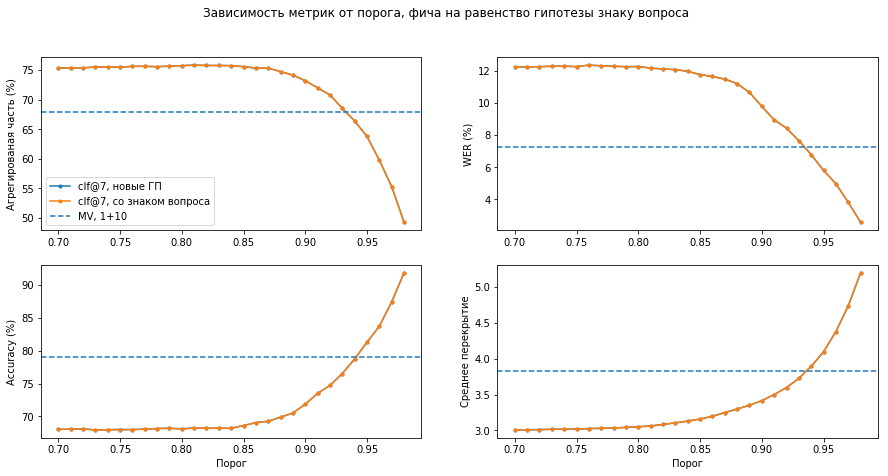

In [137]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, фича на равенство гипотезы знаку вопроса')
plt.subplot(221)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 1] * 100, 
         ".-", 
         label="clf@7, новые ГП")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf@7, со знаком вопроса")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_test_new_feature[:, 0], 
         scores_clf_test_new_feature[:, 4], 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_question_sign_assistant.png")
plt.show()

In [138]:
scores_clf_test_q[-1]

array([0.98      , 0.49225473, 0.02574476, 0.91841492, 5.19965577])

In [21]:
min_overlaps = (2, 3)
max_overlaps = [i for i in range(4, 11)]
metrics_all = {}

In [24]:
for min_i in min_overlaps:
    for max_i in max_overlaps:
        scores_clf_test = []
        print('min_i: {}\tmax_i: {}'.format(min_i, max_i))
        for treshhold in np.linspace(0.8, 0.98, 19):
            print(treshhold)
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            test_features, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            gs, 
                                            treshhold,
                                            min_cost=min_i,
                                            max_cost=max_i)
            scores_clf_test.append((treshhold, *metrics))
        scores_clf_test = np.array(scores_clf_test)
        metrics_all[(min_i, max_i)] = scores_clf_test

min_i: 2	max_i: 4
0.8
Aggregated: 75.2438%
WER: 13.5646%
Accuracy: 64.7350%
Mean overlap: 2.118
0.81
Aggregated: 74.9857%
WER: 13.3112%
Accuracy: 64.9962%
Mean overlap: 2.133
0.8200000000000001
Aggregated: 74.7275%
WER: 13.1282%
Accuracy: 64.9904%
Mean overlap: 2.164
0.8300000000000001
Aggregated: 74.4119%
WER: 12.9264%
Accuracy: 65.1889%
Mean overlap: 2.186
0.8400000000000001
Aggregated: 74.2111%
WER: 12.8238%
Accuracy: 65.2107%
Mean overlap: 2.212
0.85
Aggregated: 73.5800%
WER: 12.3876%
Accuracy: 65.9649%
Mean overlap: 2.245
0.86
Aggregated: 72.8629%
WER: 11.9680%
Accuracy: 66.6929%
Mean overlap: 2.281
0.87
Aggregated: 71.8302%
WER: 11.4110%
Accuracy: 67.8514%
Mean overlap: 2.317
0.88
Aggregated: 70.5967%
WER: 10.8333%
Accuracy: 68.7119%
Mean overlap: 2.36
0.89
Aggregated: 69.5353%
WER: 10.2103%
Accuracy: 70.1320%
Mean overlap: 2.427
0.9
Aggregated: 68.3018%
WER: 9.4018%
Accuracy: 71.7766%
Mean overlap: 2.505
0.91
Aggregated: 66.7240%
WER: 8.7051%
Accuracy: 73.3878%
Mean overlap: 2.5

Aggregated: 75.6168%
WER: 13.3134%
Accuracy: 64.4158%
Mean overlap: 2.251
0.85
Aggregated: 75.5307%
WER: 13.0389%
Accuracy: 65.0209%
Mean overlap: 2.298
0.86
Aggregated: 75.3873%
WER: 12.8598%
Accuracy: 65.4490%
Mean overlap: 2.359
0.87
Aggregated: 75.3873%
WER: 12.5693%
Accuracy: 65.8676%
Mean overlap: 2.432
0.88
Aggregated: 75.0717%
WER: 12.3723%
Accuracy: 66.3355%
Mean overlap: 2.514
0.89
Aggregated: 74.8709%
WER: 11.8501%
Accuracy: 67.1648%
Mean overlap: 2.623
0.9
Aggregated: 74.5267%
WER: 11.2416%
Accuracy: 68.2833%
Mean overlap: 2.772
0.91
Aggregated: 73.4653%
WER: 10.3933%
Accuracy: 69.9336%
Mean overlap: 2.916
0.92
Aggregated: 72.2892%
WER: 9.6210%
Accuracy: 71.5476%
Mean overlap: 3.1
0.9299999999999999
Aggregated: 70.5680%
WER: 8.5866%
Accuracy: 73.8618%
Mean overlap: 3.326
0.94
Aggregated: 68.4739%
WER: 7.4568%
Accuracy: 76.9166%
Mean overlap: 3.6
0.95
Aggregated: 66.2937%
WER: 6.4189%
Accuracy: 79.4461%
Mean overlap: 3.894
0.96
Aggregated: 62.9375%
WER: 5.4231%
Accuracy: 82.

Aggregated: 70.7975%
WER: 8.4251%
Accuracy: 74.7164%
Mean overlap: 3.598
0.9299999999999999
Aggregated: 68.5313%
WER: 7.6444%
Accuracy: 76.5174%
Mean overlap: 3.726
0.94
Aggregated: 66.3798%
WER: 6.7799%
Accuracy: 78.7381%
Mean overlap: 3.895
0.95
Aggregated: 63.7694%
WER: 5.8022%
Accuracy: 81.2865%
Mean overlap: 4.097
0.96
Aggregated: 59.7246%
WER: 4.9678%
Accuracy: 83.7176%
Mean overlap: 4.38
0.97
Aggregated: 55.2496%
WER: 3.8159%
Accuracy: 87.4351%
Mean overlap: 4.739
0.98
Aggregated: 49.2255%
WER: 2.5745%
Accuracy: 91.8415%
Mean overlap: 5.2
min_i: 3	max_i: 8
0.8
Aggregated: 75.7602%
WER: 12.2525%
Accuracy: 68.1181%
Mean overlap: 3.051
0.81
Aggregated: 75.8462%
WER: 12.1545%
Accuracy: 68.2300%
Mean overlap: 3.062
0.8200000000000001
Aggregated: 75.8176%
WER: 12.1050%
Accuracy: 68.1801%
Mean overlap: 3.085
0.8300000000000001
Aggregated: 75.8462%
WER: 12.0632%
Accuracy: 68.1921%
Mean overlap: 3.107
0.8400000000000001
Aggregated: 75.8462%
WER: 11.9611%
Accuracy: 68.1543%
Mean overlap: 

In [26]:
metrics_all.keys()

dict_keys([(2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)])

In [ ]:
metrics_all

In [27]:
import pickle

In [28]:
with open('overlaps_assistant_2019_09_26.pickle', 'wb') as f:
    pickle.dump(metrics_all, f)

In [29]:
with open('overlaps_assistant_2019_09_26.pickle', 'rb') as f:
    metrics_loaded = pickle.load(f)
metrics_loaded

{(2, 4): array([[0.8       , 0.75243832, 0.1356455 , 0.64735036, 2.11761331],
        [0.81      , 0.74985657, 0.13311198, 0.64996174, 2.13253012],
        [0.82      , 0.74727481, 0.13128197, 0.64990403, 2.16408491],
        [0.83      , 0.74411933, 0.12926351, 0.65188897, 2.1858864 ],
        [0.84      , 0.7421113 , 0.12823815, 0.65210669, 2.21227768],
        [0.85      , 0.73580034, 0.12387559, 0.65964912, 2.24526678],
        [0.86      , 0.7286288 , 0.11968044, 0.66692913, 2.28055077],
        [0.87      , 0.71830178, 0.11411014, 0.67851438, 2.31726908],
        [0.88      , 0.70596672, 0.10833267, 0.68711906, 2.36029834],
        [0.89      , 0.69535284, 0.10210307, 0.70132013, 2.42685026],
        [0.9       , 0.68301779, 0.09401779, 0.71776564, 2.50516351],
        [0.91      , 0.66724039, 0.08705096, 0.7338779 , 2.56741251],
        [0.92      , 0.64486517, 0.07825485, 0.75711744, 2.65461847],
        [0.93      , 0.61904762, 0.06962655, 0.78220575, 2.75100402],
        [0.9

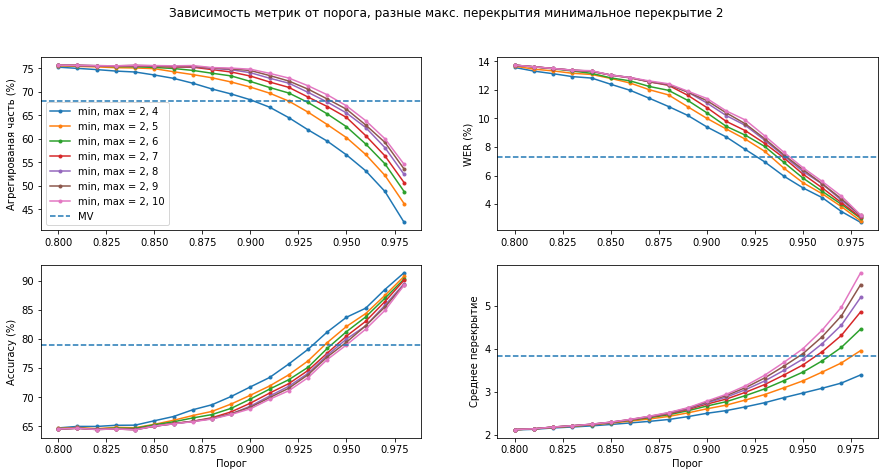

In [41]:
min_i = 2
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, разные макс. перекрытия минимальное перекрытие {}'.format(min_i))
plt.subplot(221)
for max_i in range(4, 11):
    plt.plot(metrics_all[(min_i, max_i)][:, 0], 
             metrics_all[(min_i, max_i)][:, 1] * 100, 
             ".-", 
             label="min, max = {}, {}".format(min_i, max_i))
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
for max_i in range(4, 11):
    plt.plot(metrics_all[(min_i, max_i)][:, 0], 
             metrics_all[(min_i, max_i)][:, 2] * 100, 
             ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
for max_i in range(4, 11):
    plt.plot(metrics_all[(min_i, max_i)][:, 0], 
             metrics_all[(min_i, max_i)][:, 3] * 100, 
             ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
for max_i in range(4, 11):
    plt.plot(metrics_all[(min_i, max_i)][:, 0], 
             metrics_all[(min_i, max_i)][:, 4], 
             ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_min2_diff_max.png")
plt.show()

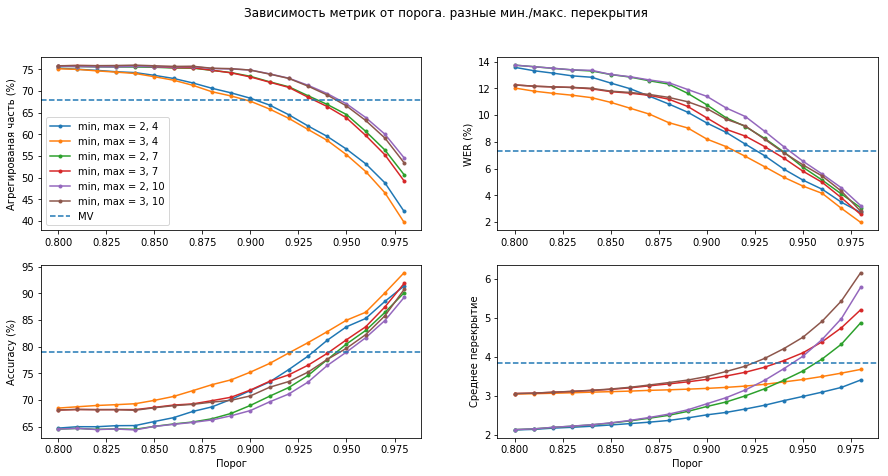

In [53]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога. разные мин./макс. перекрытия')
plt.subplot(221)

max_lower = 4
max_upper = 11
max_step = 3

for max_i in range(max_lower, max_upper, max_step):
    for min_i in range(2, 4):
        plt.plot(metrics_all[(min_i, max_i)][:, 0], 
                 metrics_all[(min_i, max_i)][:, 1] * 100, 
                 ".-", 
                 label="min, max = {}, {}".format(min_i, max_i))
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
for max_i in range(max_lower, max_upper, max_step):
    for min_i in range(2, 4):
        plt.plot(metrics_all[(min_i, max_i)][:, 0], 
                 metrics_all[(min_i, max_i)][:, 2] * 100, 
                 ".-", 
                 label="min, max = {}, {}".format(min_i, max_i))
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
for max_i in range(max_lower, max_upper, max_step):
    for min_i in range(2, 4):
        plt.plot(metrics_all[(min_i, max_i)][:, 0], 
                 metrics_all[(min_i, max_i)][:, 3] * 100, 
                 ".-", 
                 label="min, max = {}, {}".format(min_i, max_i))
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
for max_i in range(max_lower, max_upper, max_step):
    for min_i in range(2, 4):
        plt.plot(metrics_all[(min_i, max_i)][:, 0], 
                 metrics_all[(min_i, max_i)][:, 4], 
                 ".-", 
                 label="min, max = {}, {}".format(min_i, max_i))
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_diff_min_max7.png")
plt.show()

In [51]:
metrics_all[(3, 7)][-5]

array([0.94      , 0.66379805, 0.06779945, 0.78738116, 3.89472174])

In [60]:
key = 'https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus'
test_features[key][1][0][''][0][253]

-1

In [129]:
base_line = []

metrics = evaluate_metrics_clf_(valid_rows, 
                                test_features, 
                                'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                gs,
                                0.948,
                                min_cost=3,
                                max_cost=7)
base_line += [treshhold, *metrics]
base_line = np.array(base_line)

Aggregated: 64.4005%
WER: 6.0870%
Accuracy: 80.6236%
Mean overlap: 4.057


In [130]:
base_line

array([9.80000000e-01, 6.44004590e-01, 6.08703160e-02, 8.06236080e-01,
       4.05708548e+00, 1.15820000e+04])

In [131]:
with open('base_line_assistant_2019_10_08.pickle', 'wb') as f:
    pickle.dump(base_line, f)

In [123]:
needed_points = []
for over, metrics in metrics_all.items():
    prev = [1] * 6
    for threshold, aggregated, wer, acc, mean in metrics:
        if aggregated > base_line[1] and aggregated < prev[2]:
            prev = [over, threshold, aggregated, wer, acc, mean]
    needed_points.append(prev)   

In [125]:
needed_points

[[(2, 4),
  0.92,
  0.6448651749856569,
  0.07825484764542937,
  0.7571174377224199,
  2.6546184738955825],
 [(2, 5),
  0.9299999999999999,
  0.6566265060240963,
  0.07704641350210971,
  0.762341633901267,
  2.940619621342513],
 [(2, 6),
  0.94,
  0.6528973034997131,
  0.06925444596443228,
  0.7838312829525483,
  3.2630522088353415],
 [(2, 7),
  0.95,
  0.6454388984509466,
  0.06096396005210595,
  0.8048888888888889,
  3.6310958118187036],
 [(2, 8),
  0.95,
  0.6549053356282272,
  0.0628839590443686,
  0.7998247919404292,
  3.7690763052208833],
 [(2, 9),
  0.95,
  0.6629374641422834,
  0.06418918918918919,
  0.7944612721765469,
  3.8938611589214],
 [(2, 10),
  0.95,
  0.6701090074584051,
  0.06549413735343383,
  0.7898116438356164,
  4.008892713711991],
 [(3, 4),
  0.91,
  0.6580608146873207,
  0.07640886782873582,
  0.7685265911072363,
  3.2091222030981066],
 [(3, 5),
  0.9299999999999999,
  0.6514629948364888,
  0.07002967359050445,
  0.7842360193747248,
  3.485370051635112],
 [(3, 6